In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile,ClassicalRegister,QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [ ]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True)

In [3]:
# Get the number of logical CPU cores available
num_cores = os.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


In [4]:
BNF_GRAMMAR = grape.Grammar("grammars/grover.bnf")

In [5]:
# Define evaluation constants
NUM_SHOTS = 1024
SUCCESS_THRESHOLD = 0.48
GATE_PENALTY_WEIGHT = 0.02
TARGET_STATE = "000"

In [6]:
LOG_DIR = "logs_marked_state_IBM_000_1024"
os.makedirs(LOG_DIR, exist_ok=True)

In [7]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    # For each qubit where the marked state is '0', apply X gate.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Apply a multi-controlled phase flip (using Hadamard and mcx)
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    # Undo the X gates.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"


In [8]:
class CircuitEvaluator:
    def __init__(self, shots: int = NUM_SHOTS, log_dir: str = LOG_DIR):
        """
        Initialize the evaluator with simulation parameters and logging directory.
        """
        self.shots = shots
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        """
        Decodes an individual's genome into a phenotype code string.
        Returns:
            A string containing the code if decoding is successful,
            or None if invalid.
        """
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            phenotype_code = ind.phenotype
            if isinstance(phenotype_code, list):
                phenotype_code = "".join(phenotype_code)
            # Replace literal \n with actual newlines and clean quotes
            cleaned_code = re.sub(r'\\n', '\n', phenotype_code)
            cleaned_code = re.sub(r'^"|"$', '', cleaned_code)
            cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)

            # Inject named registers for compatibility with Sampler V2
            cleaned_code = re.sub(
                r"qc\s*=\s*QuantumCircuit\(\s*3\s*,\s*3\s*\)",
                "qr = QuantumRegister(3, name='q')\ncr = ClassicalRegister(3, name='cr')\nqc = QuantumCircuit(qr, cr)",
                cleaned_code
            )
            return cleaned_code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        """
        Executes the phenotype code to produce a QuantumCircuit.
        Returns:
            The QuantumCircuit if 'qc' is found in the execution context,
            otherwise None.
        """
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str) -> dict:
        """
        Simulates the circuit and returns performance metrics for the given marked state.
        
        Args:
            circuit (QuantumCircuit): The circuit to simulate.
            marked_state (str): The state to evaluate.
        
        Returns:
            dict: Contains counts, p_marked, error, gate_count, and depth.
        """
        simulator = QasmSimulator()
        compiled = transpile(circuit, simulator, optimization_level=0)
        result = simulator.run(compiled, shots=self.shots).result()
        counts = result.get_counts()
        # Reverse bitstrings to match the expected format.
        corrected = {k[::-1]: v for k, v in counts.items()}
        total = sum(corrected.values())
        p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
        error = 1 - p_marked
        return {
            "counts": corrected,
            "p_marked": p_marked,
            "error": error,
            "gate_count": compiled.size(),
            "depth": compiled.depth()
        }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        """
        Logs the evaluation details for an individual to JSON and CSV files.
        """
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth"]].to_csv(log_file_csv, index=False)

In [9]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    """Inject oracle code into the phenotype string."""
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

In [10]:
def fitness_function_specialized_state_000(
    phenotype_str,
    shots=NUM_SHOTS,
    threshold=SUCCESS_THRESHOLD,
    gate_penalty_weight=GATE_PENALTY_WEIGHT,
    target_state=TARGET_STATE,
    log_states=True
):
    if not isinstance(phenotype_str, str):
        return (float('inf'), []) if log_states else float('inf')
    
    evaluator = CircuitEvaluator(shots=shots)
    logs = []
    
    oracle_code = generate_oracle_for_state(target_state)
    modified_code = inject_oracle(phenotype_str, oracle_code)
    qc = evaluator.execute_circuit(modified_code)
    if qc is None:
        return (float('inf'), []) if log_states else float('inf')
    
    result = evaluator.simulate_circuit(qc, target_state)
    p_marked = result["p_marked"]
    error = 1 - p_marked
    miss = 1 if error > threshold else 0
    gate_count = result.get("gate_count", 0)
    
    fitness_score = 10 * miss + error + gate_penalty_weight * gate_count
    
    if log_states:
        logs.append({
            "state": target_state,
            "p_marked": p_marked,
            "error": error,
            "gate_count": gate_count,
            "oracle": oracle_code,
            "code": modified_code,
            "counts": result["counts"],
            "depth": result.get("depth", None)
        })
        return (fitness_score, logs)
    else:
        return fitness_score

In [11]:
def plot_single_state_histogram(log):
    """Plot a histogram of measurement counts for a single marked state."""
    counts = log.get("counts", {})
    if not counts or sum(counts.values()) == 0:
        print("No valid counts to plot.")
        return
    plt.figure(figsize=(6, 4))
    plot_histogram(counts, title=f"Counts for Marked State {log['state']}")
    plt.show()

In [12]:
POPULATION_SIZE    = 1000
MAX_GENERATIONS    = 100
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION = 'list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [13]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

pool = multiprocessing.Pool(num_cores)
toolbox.register("map", pool.map)

In [14]:
evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR)

def evaluate_with_logging(individual, pts_train=None):
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    # Evaluate with logs enabled.
    fitness_val, logs = fitness_function_specialized_state_000(
        phenotype_str, 
        shots=NUM_SHOTS, 
        threshold=SUCCESS_THRESHOLD, 
        gate_penalty_weight=GATE_PENALTY_WEIGHT,
        target_state=TARGET_STATE, 
        log_states=True
    )
    gen = getattr(individual, "generation", "unknown")
    evaluator.log_evaluation(logs, gen, individual)
    return (fitness_val,)

toolbox.register("evaluate", evaluate_with_logging)

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 172

[Generation 0] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


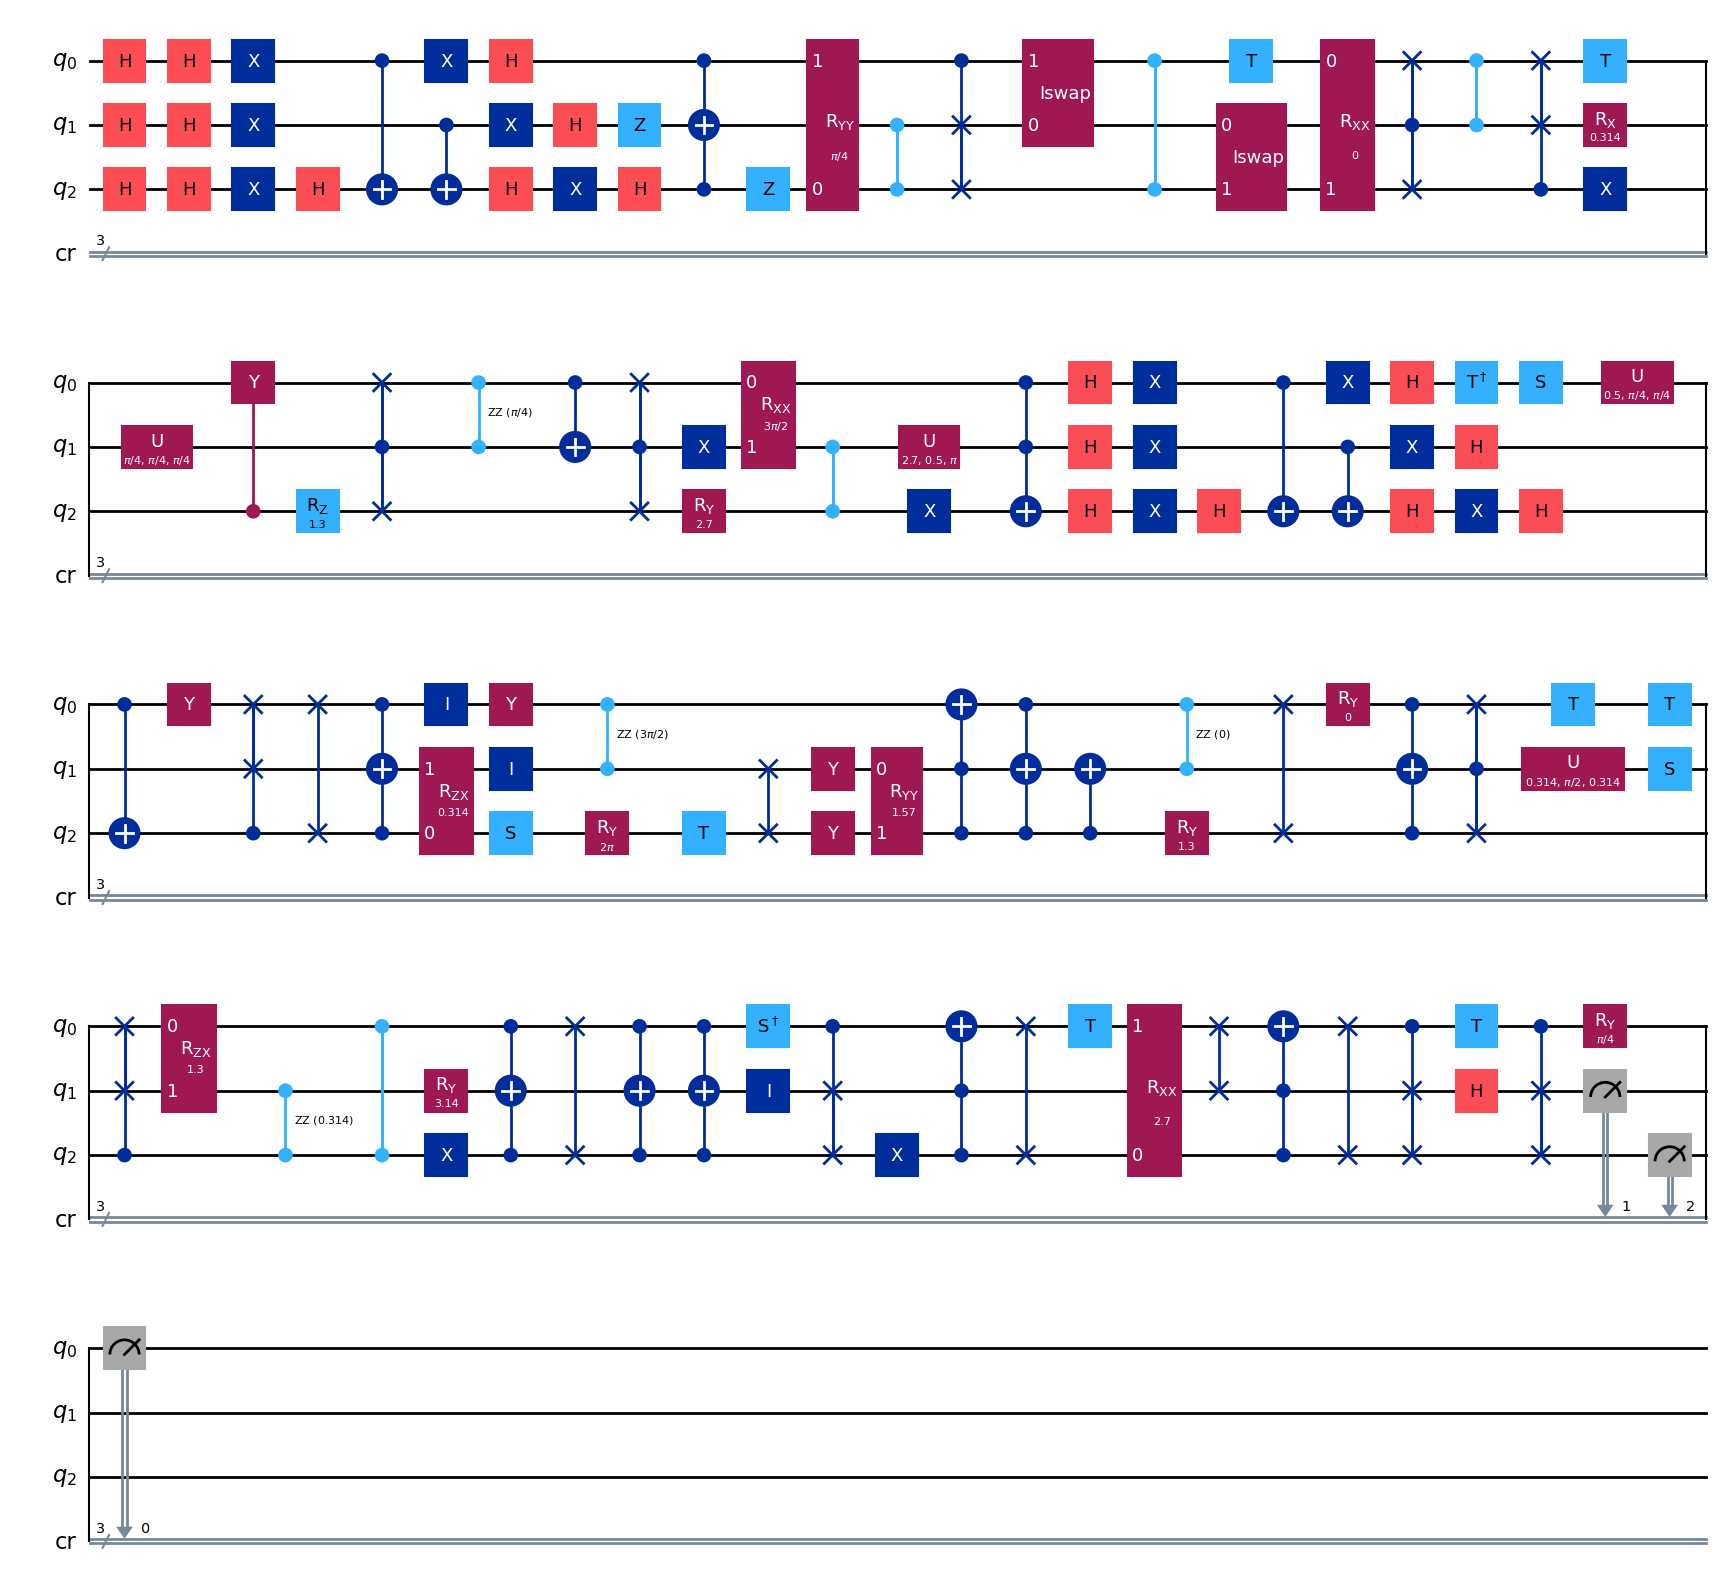

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 97

[Generation 1] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


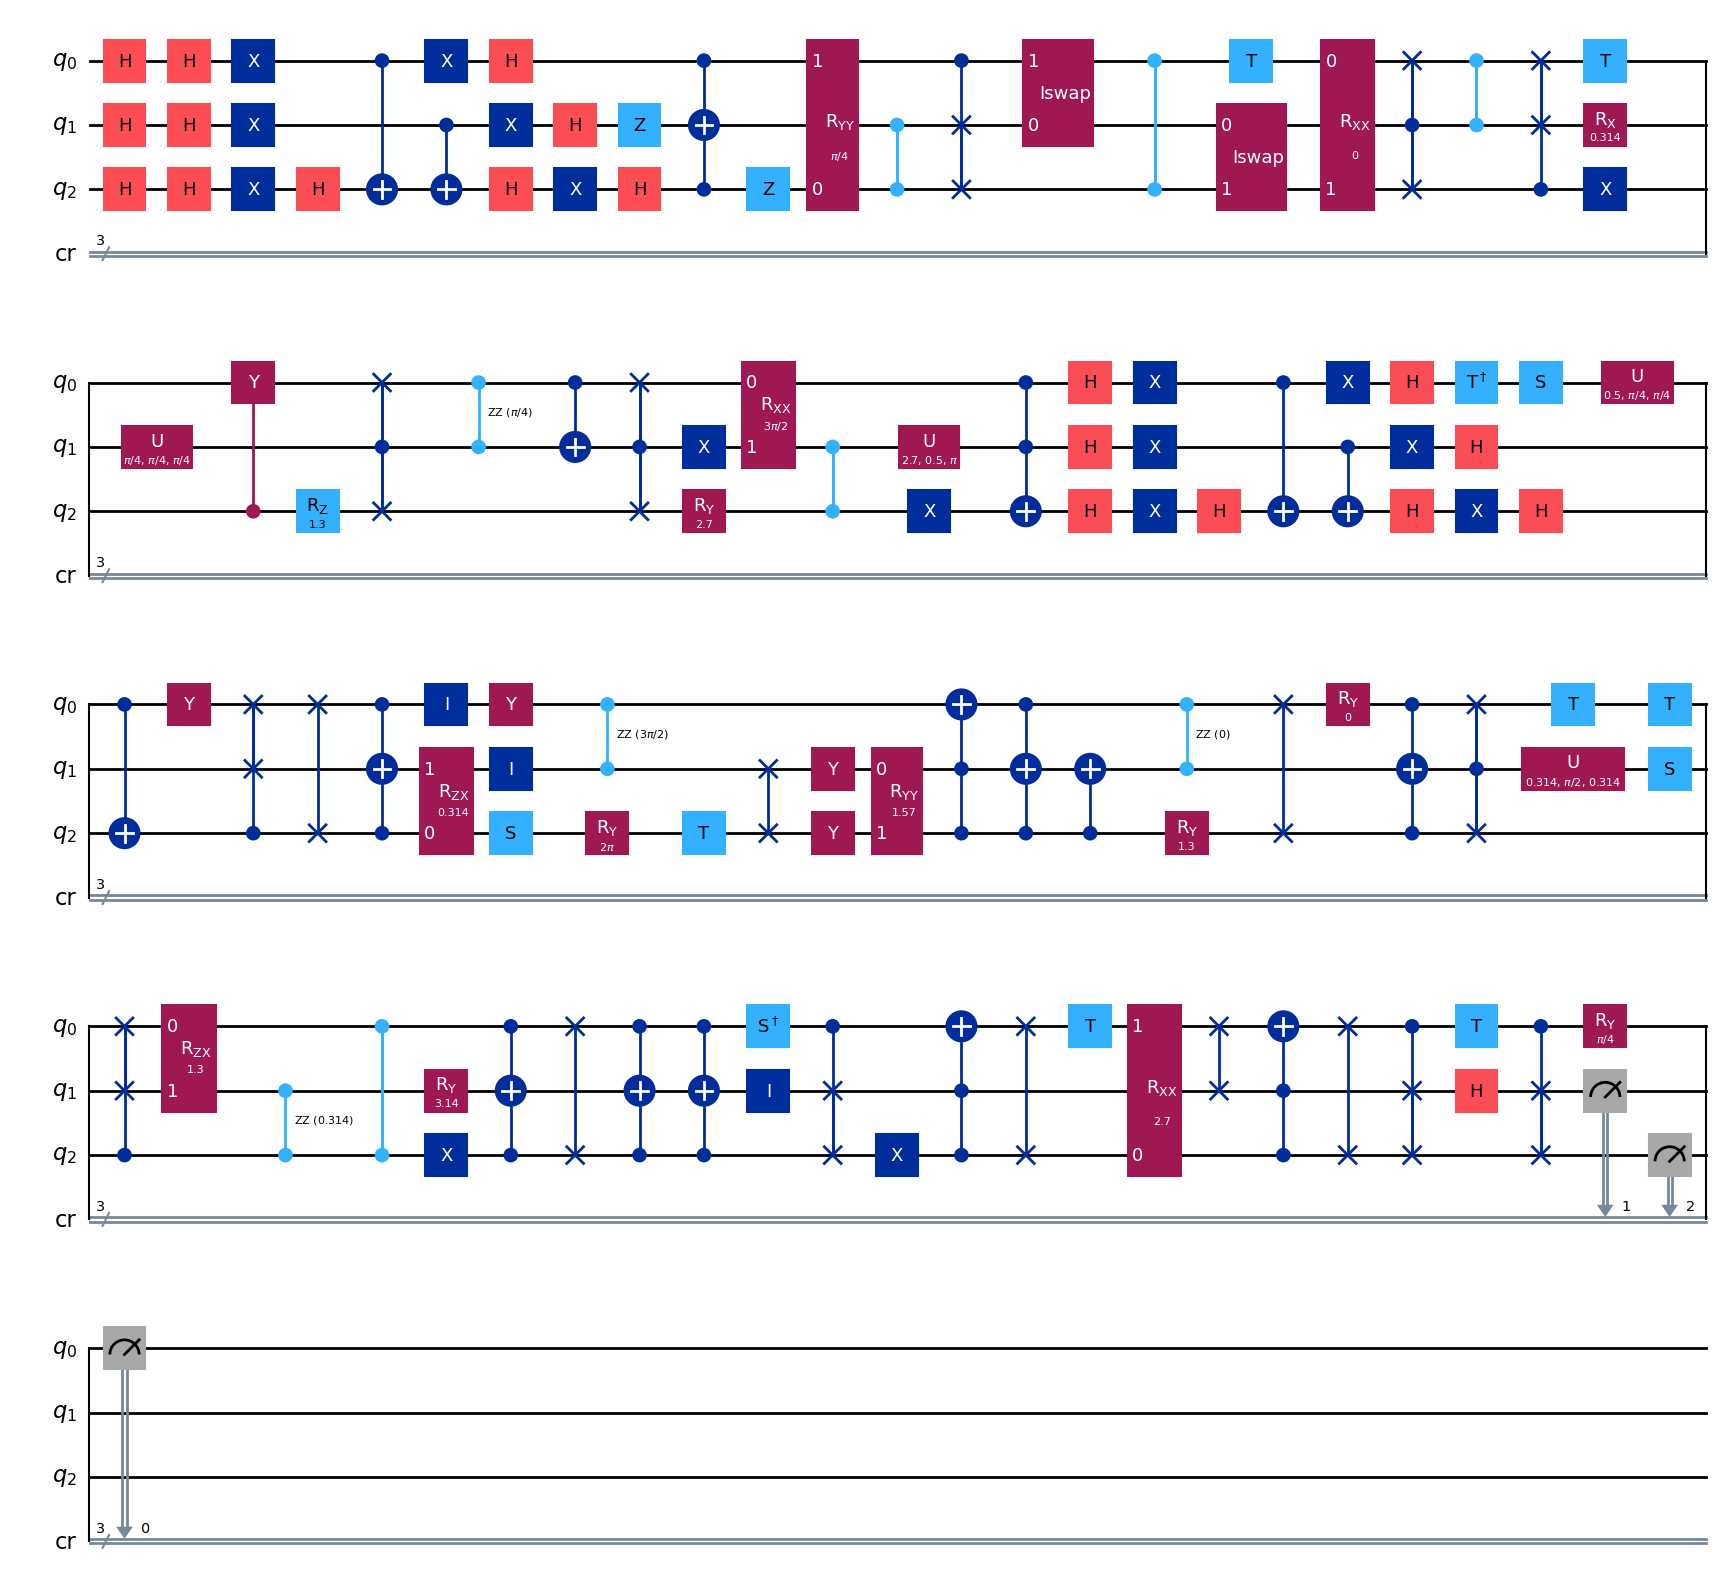

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 55

[Generation 2] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


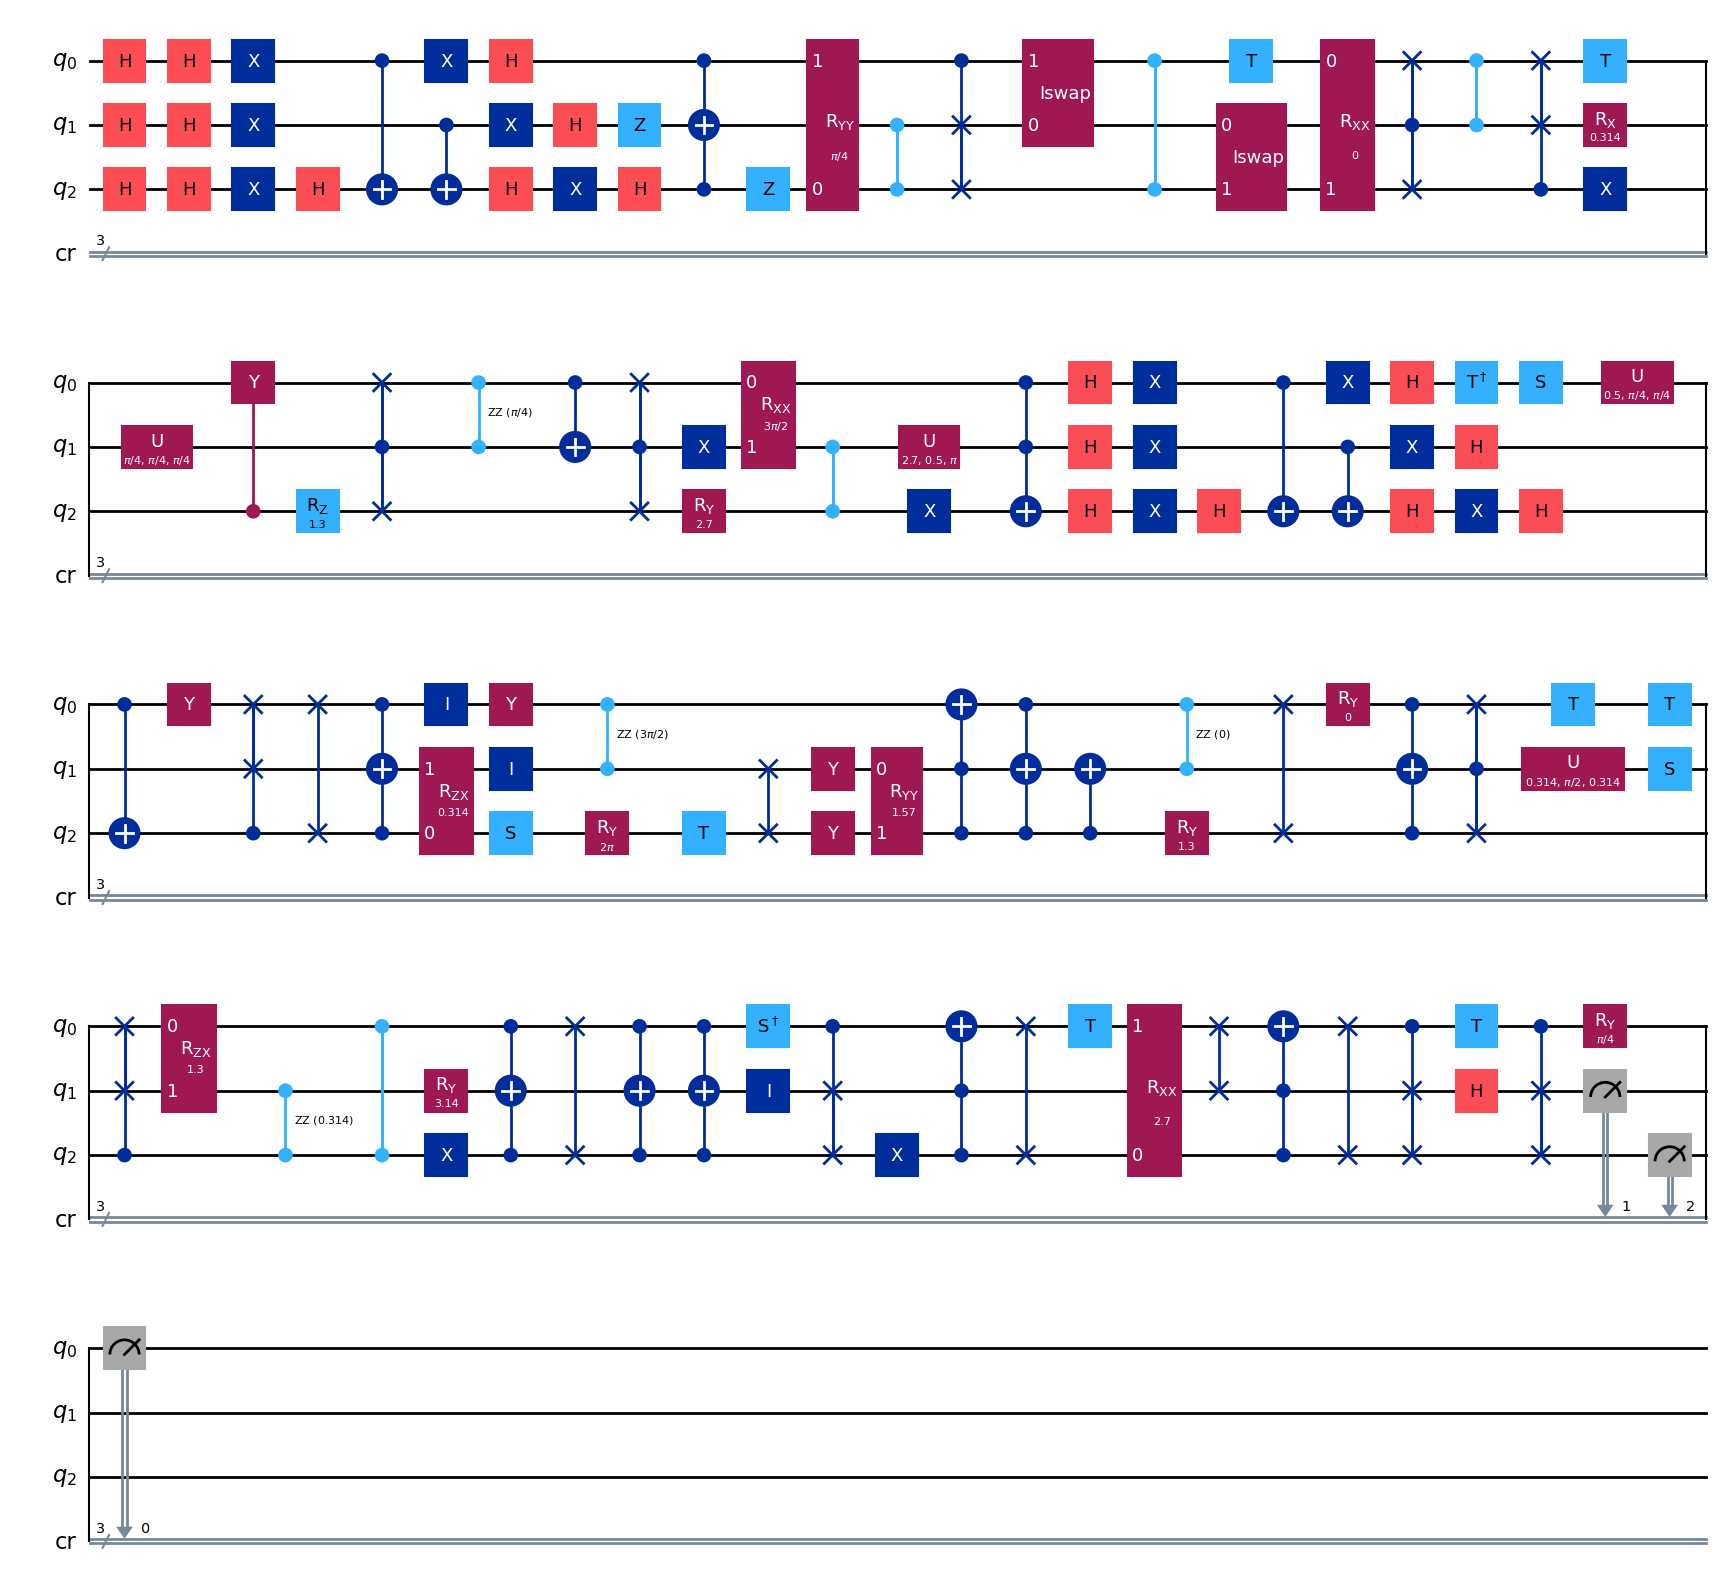

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 45

[Generation 3] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


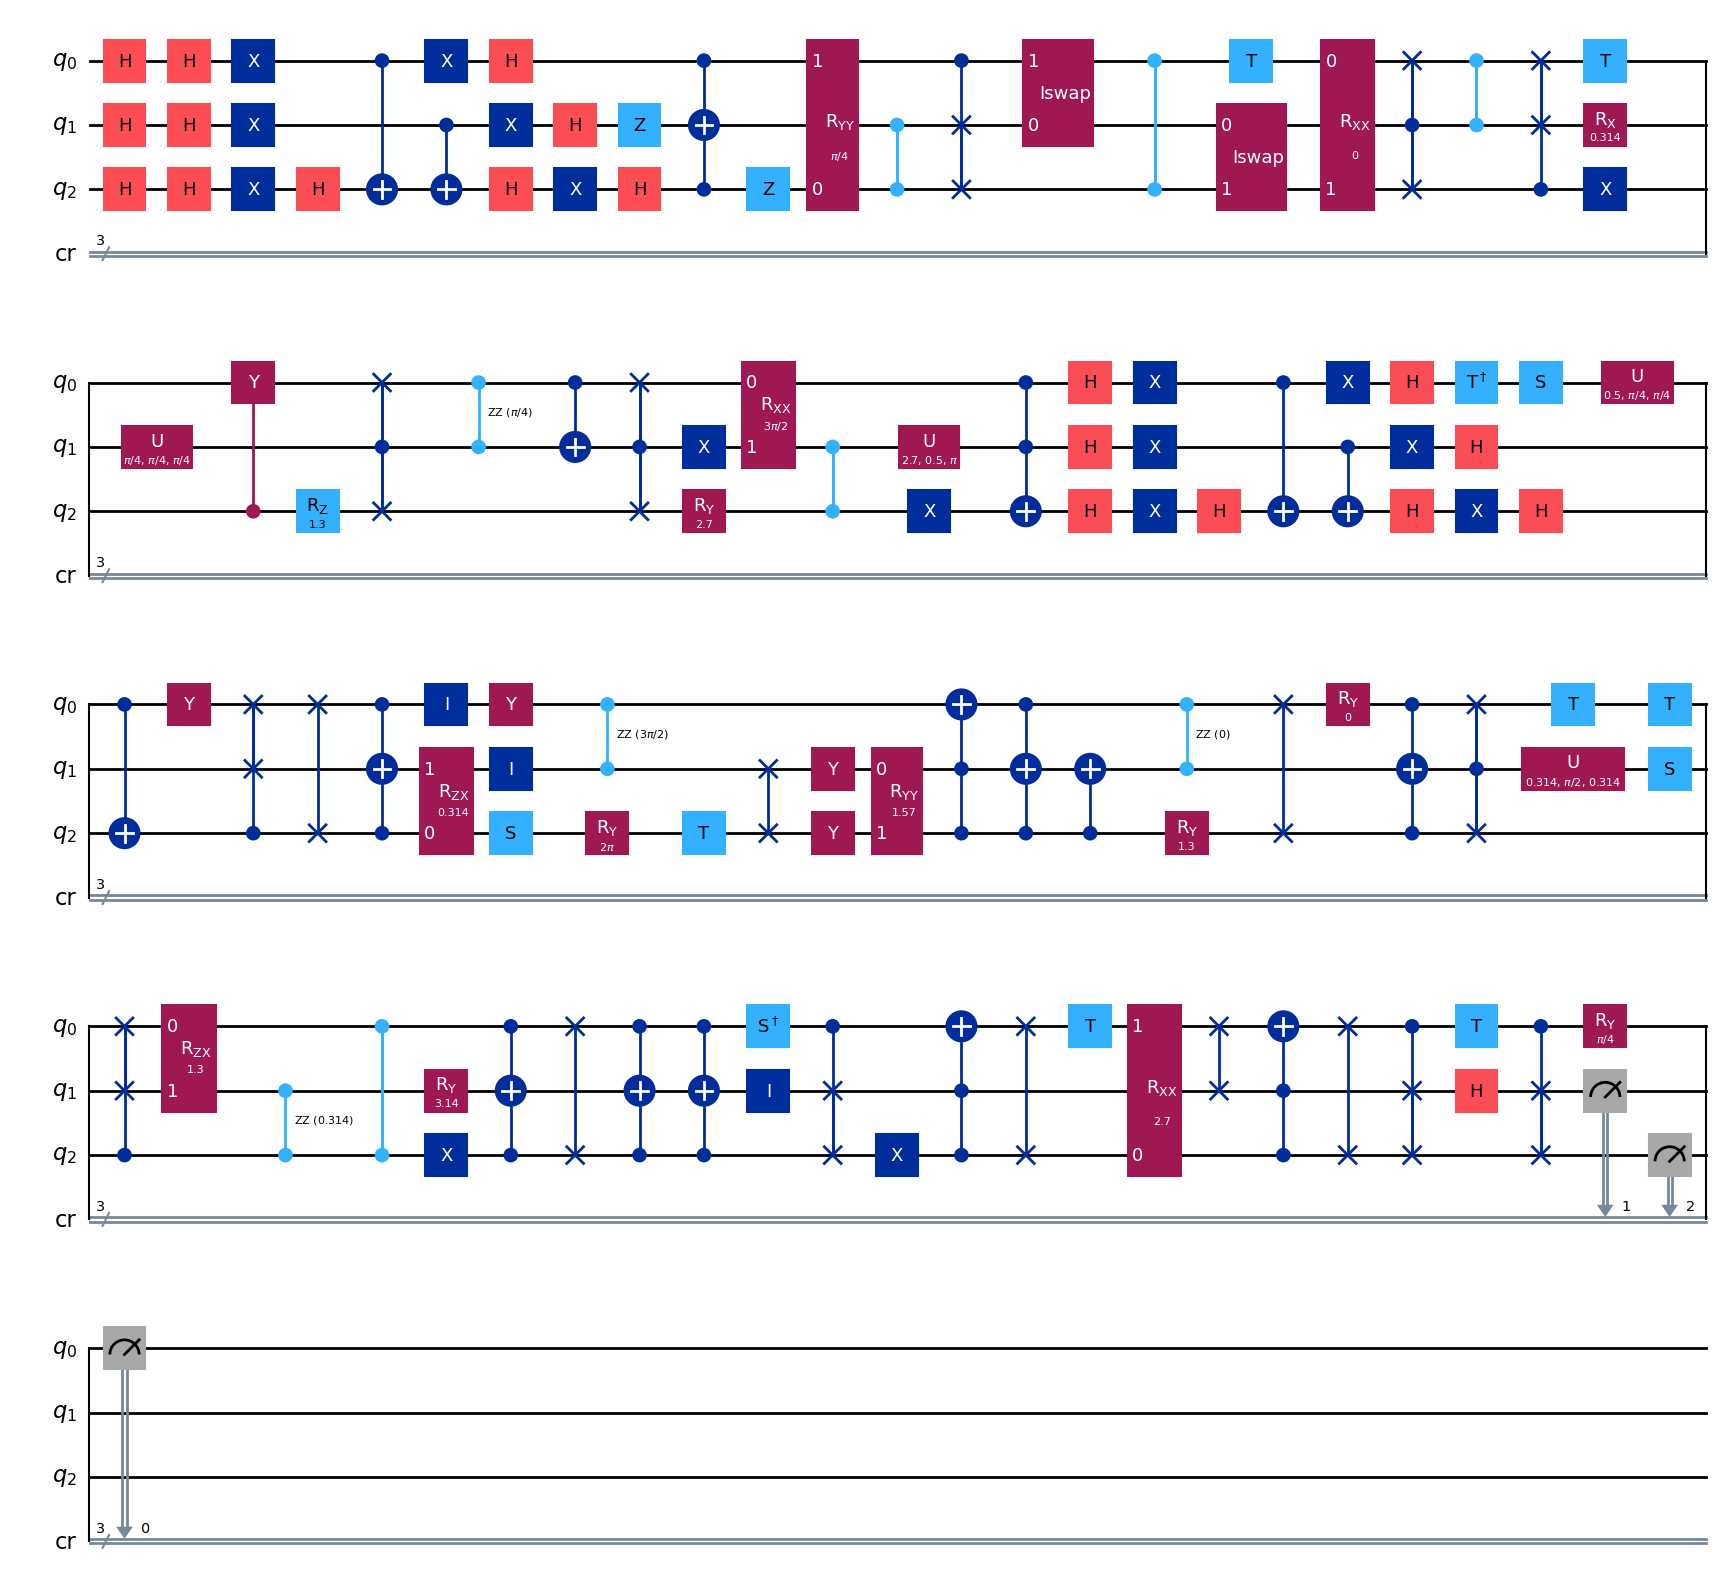

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 41

[Generation 4] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


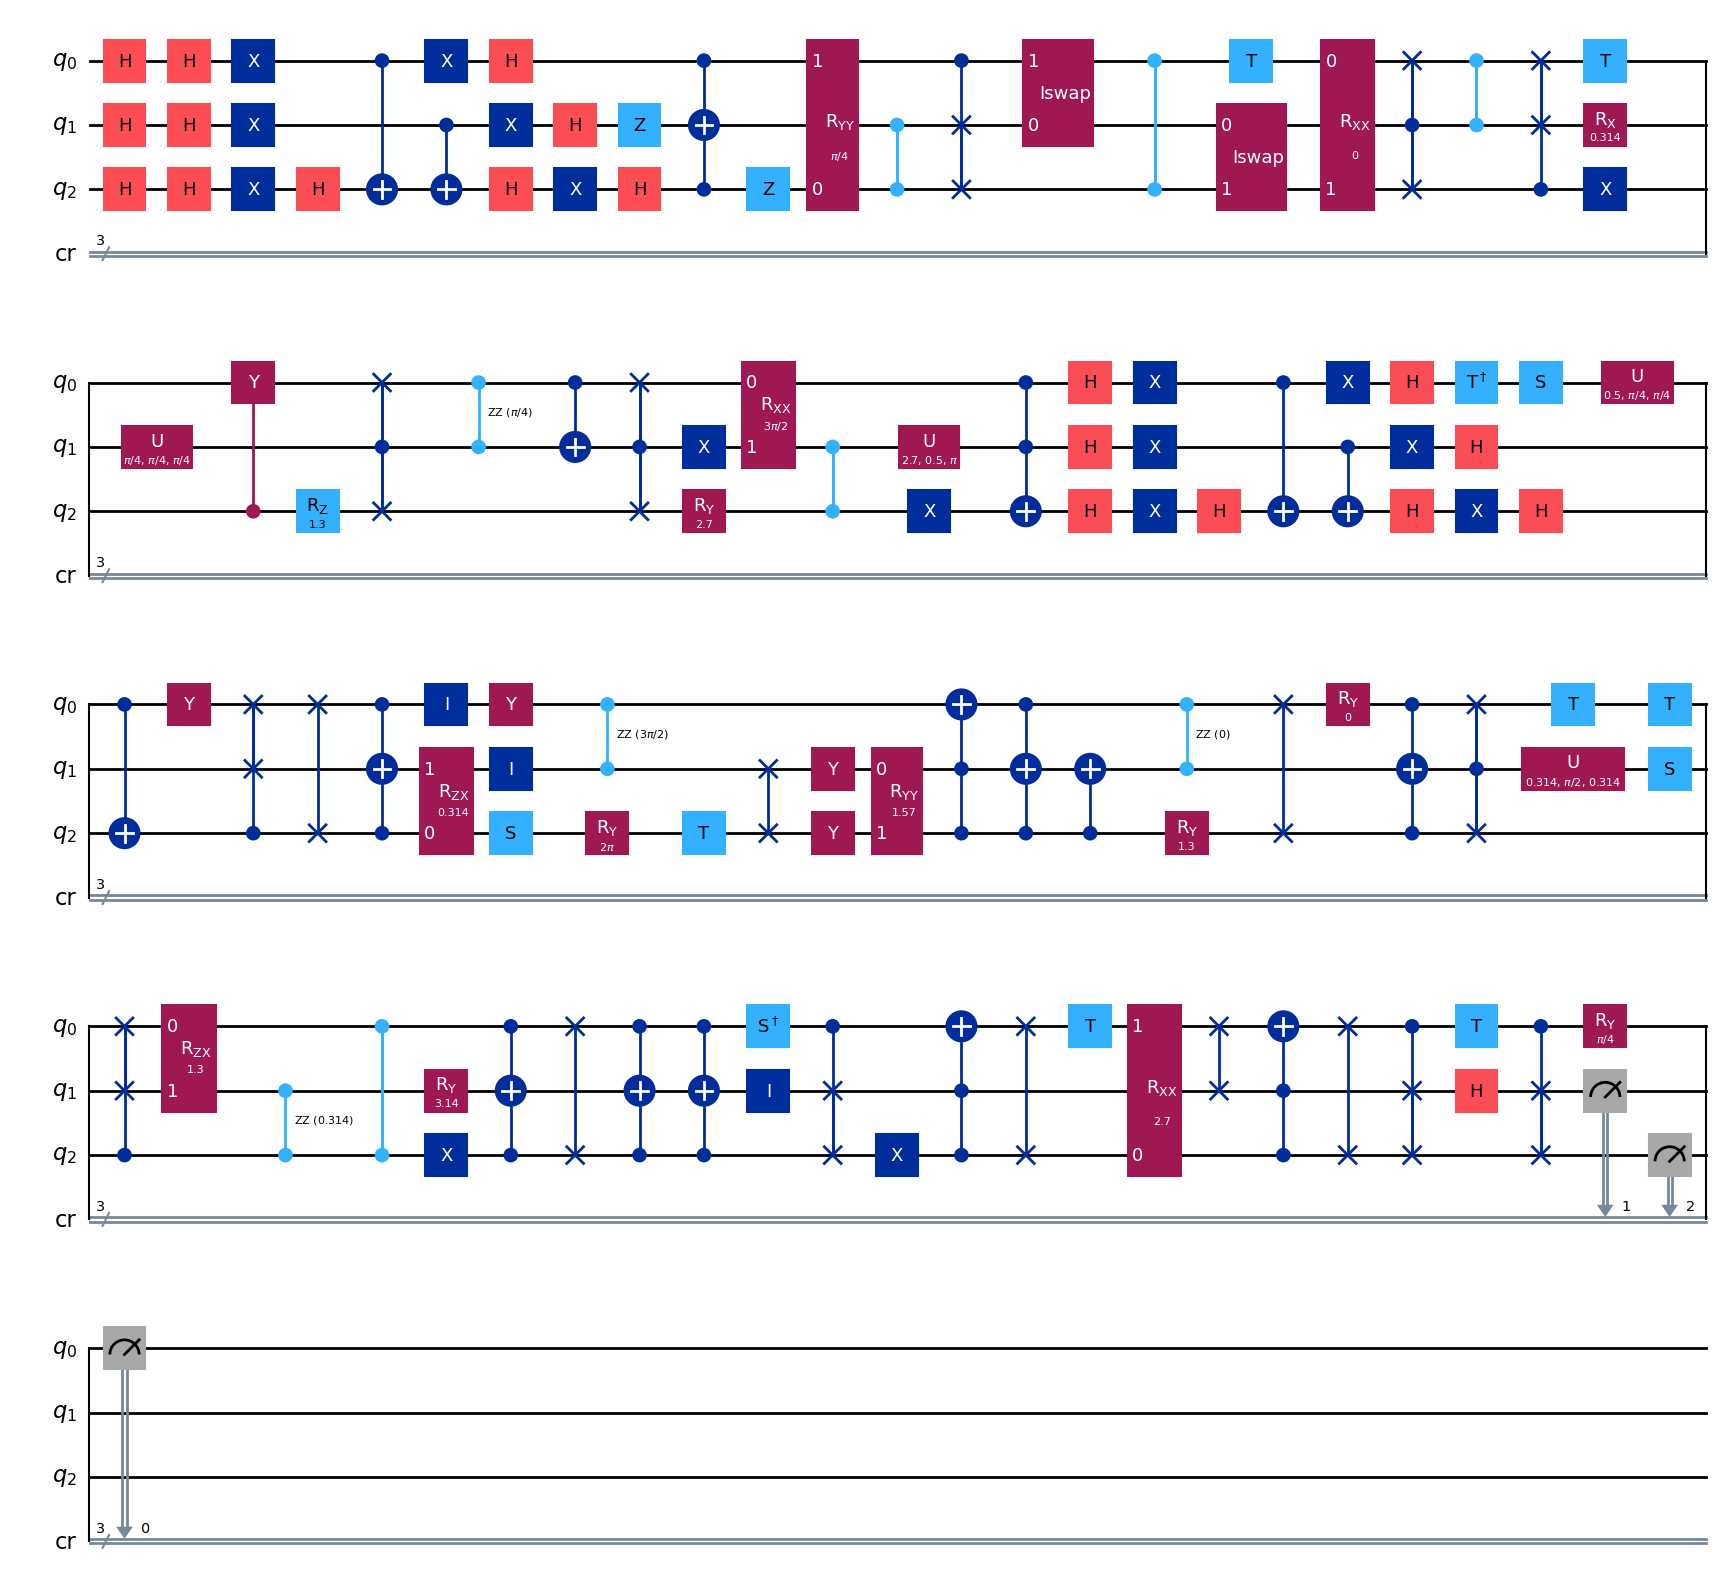

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 45

[Generation 5] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


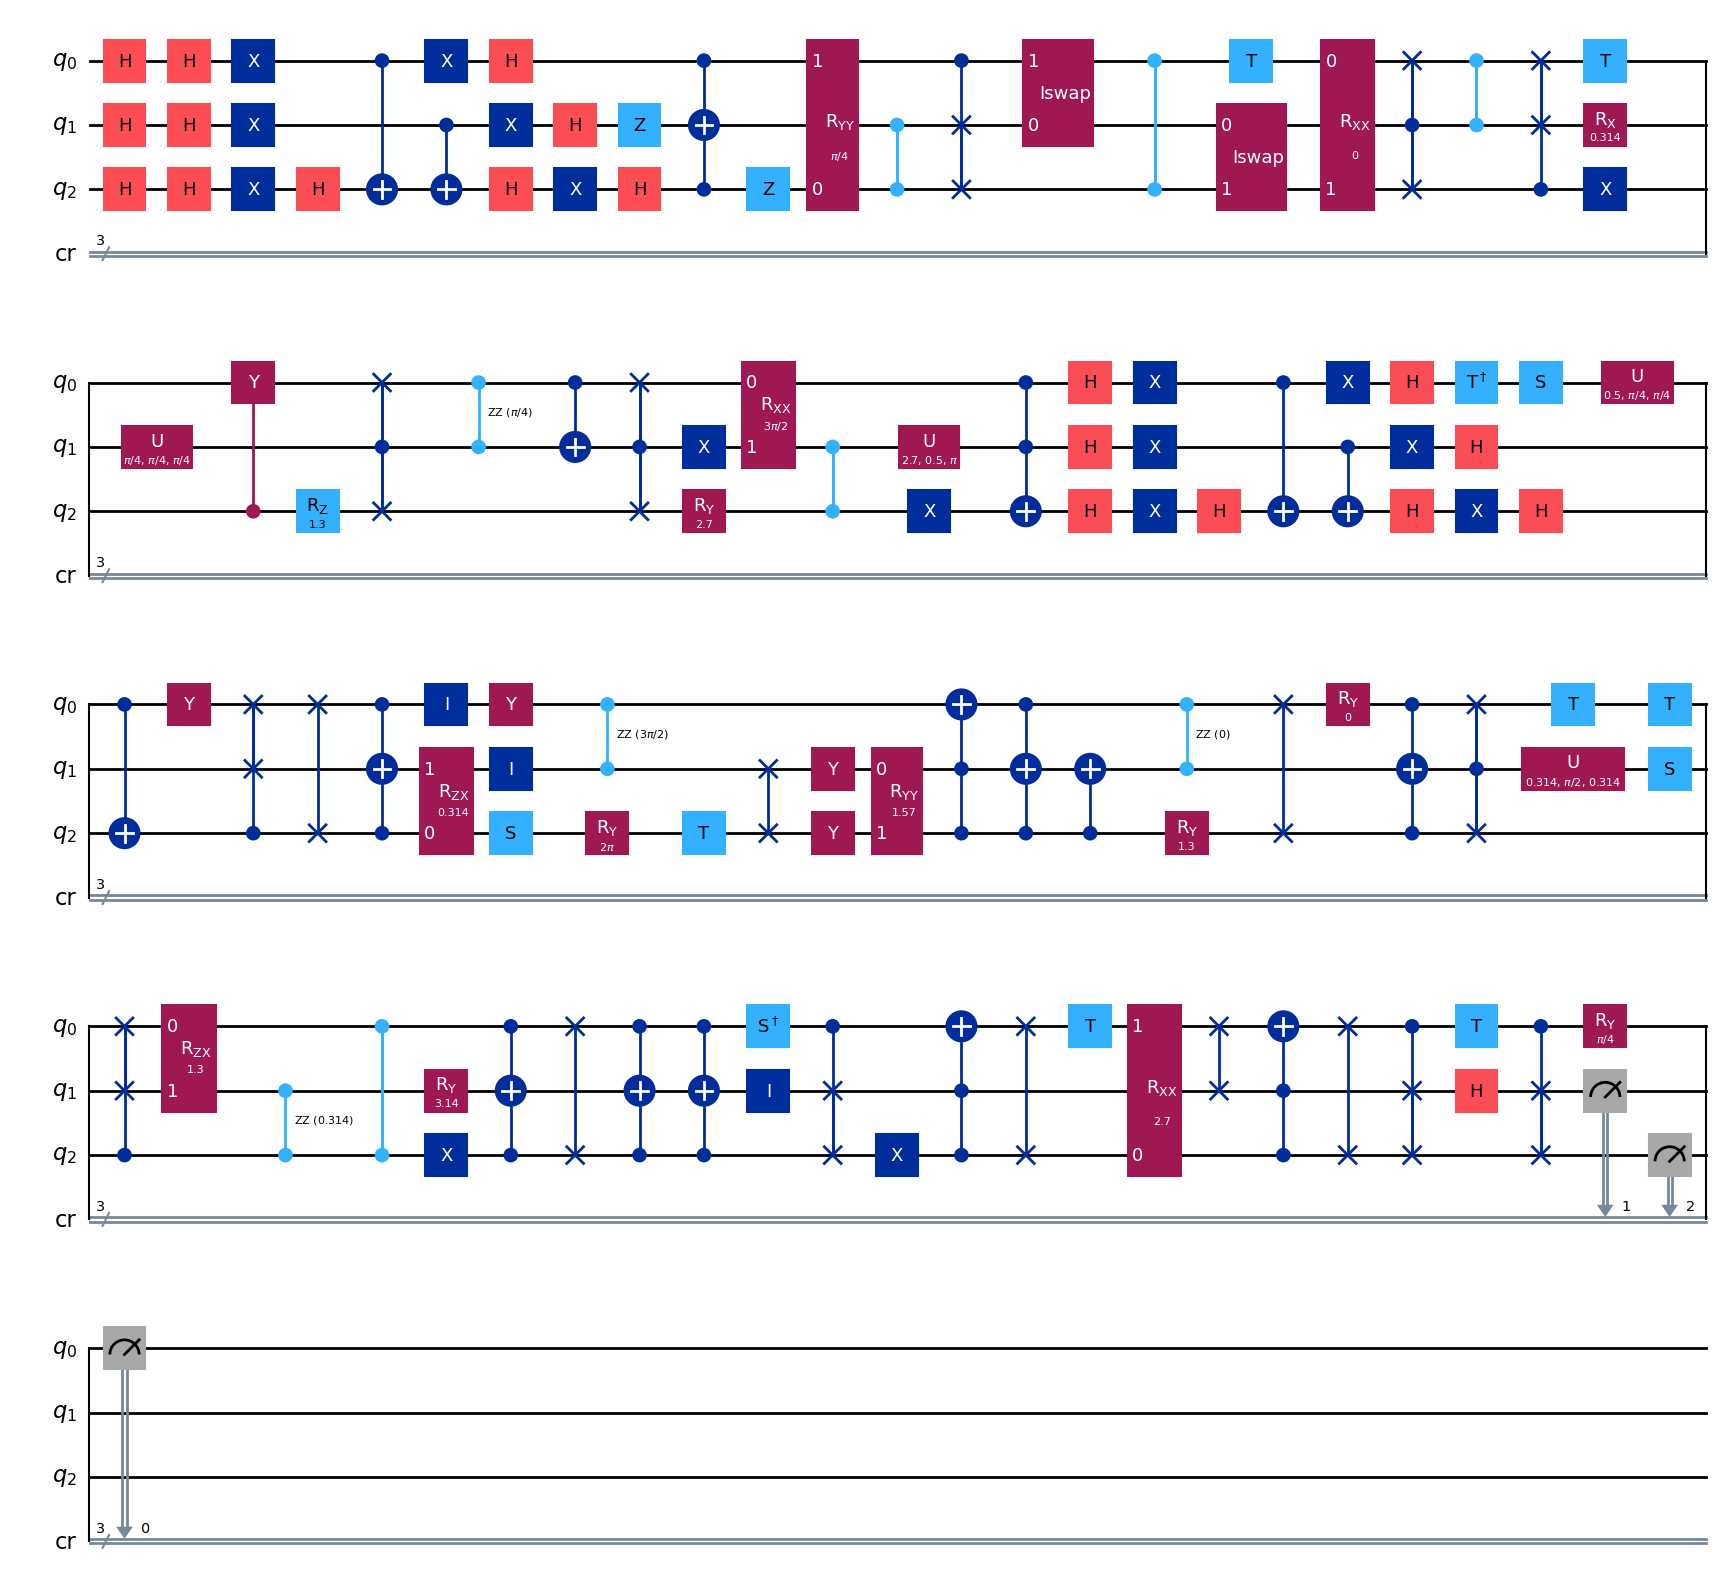

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 33

[Generation 6] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


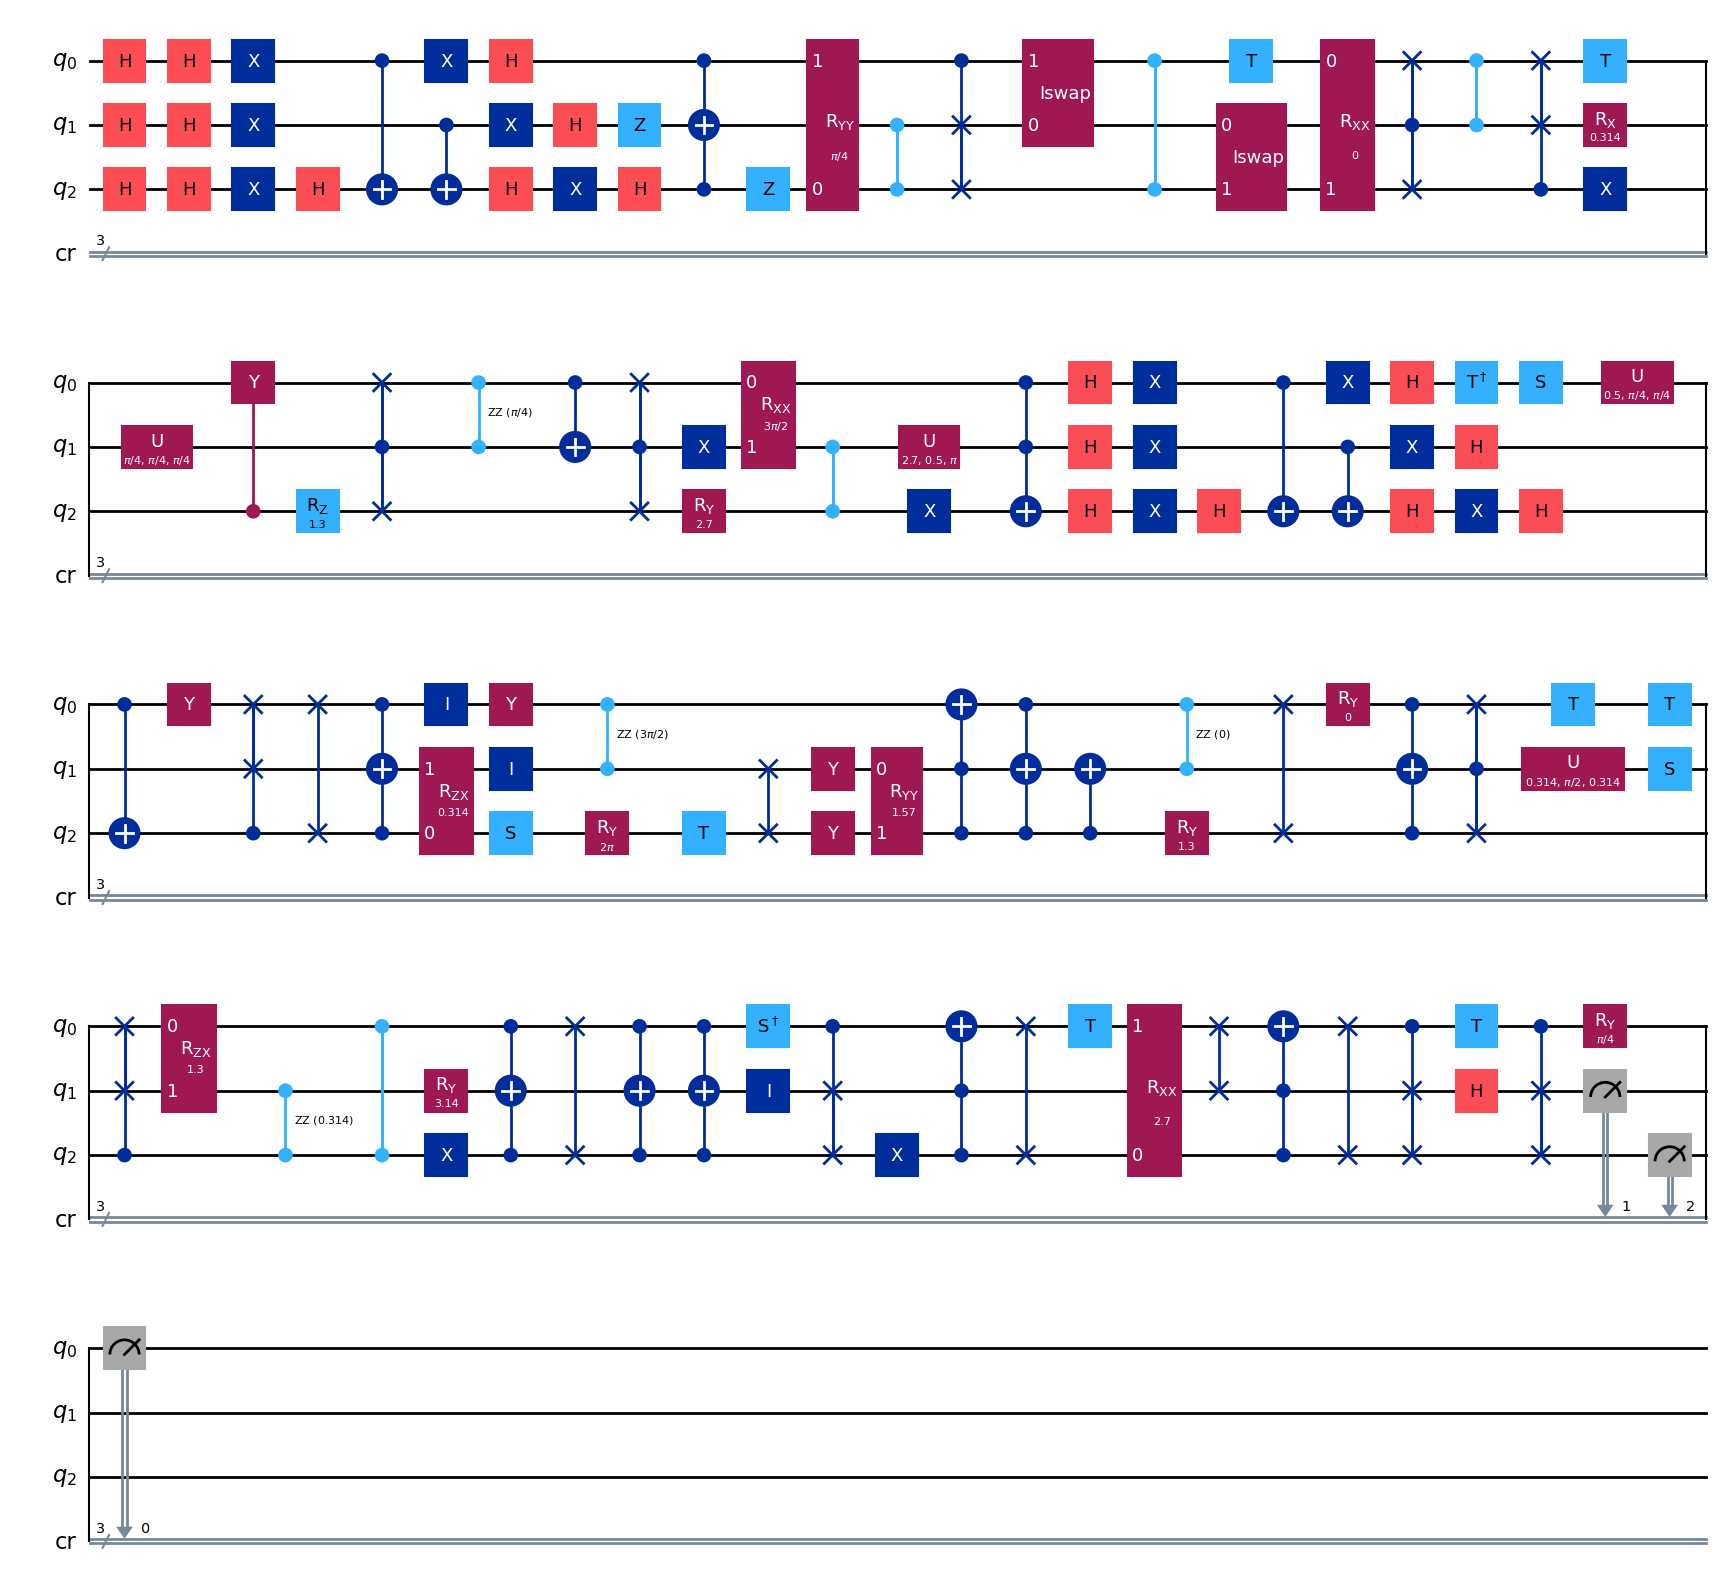

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 23

[Generation 7] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


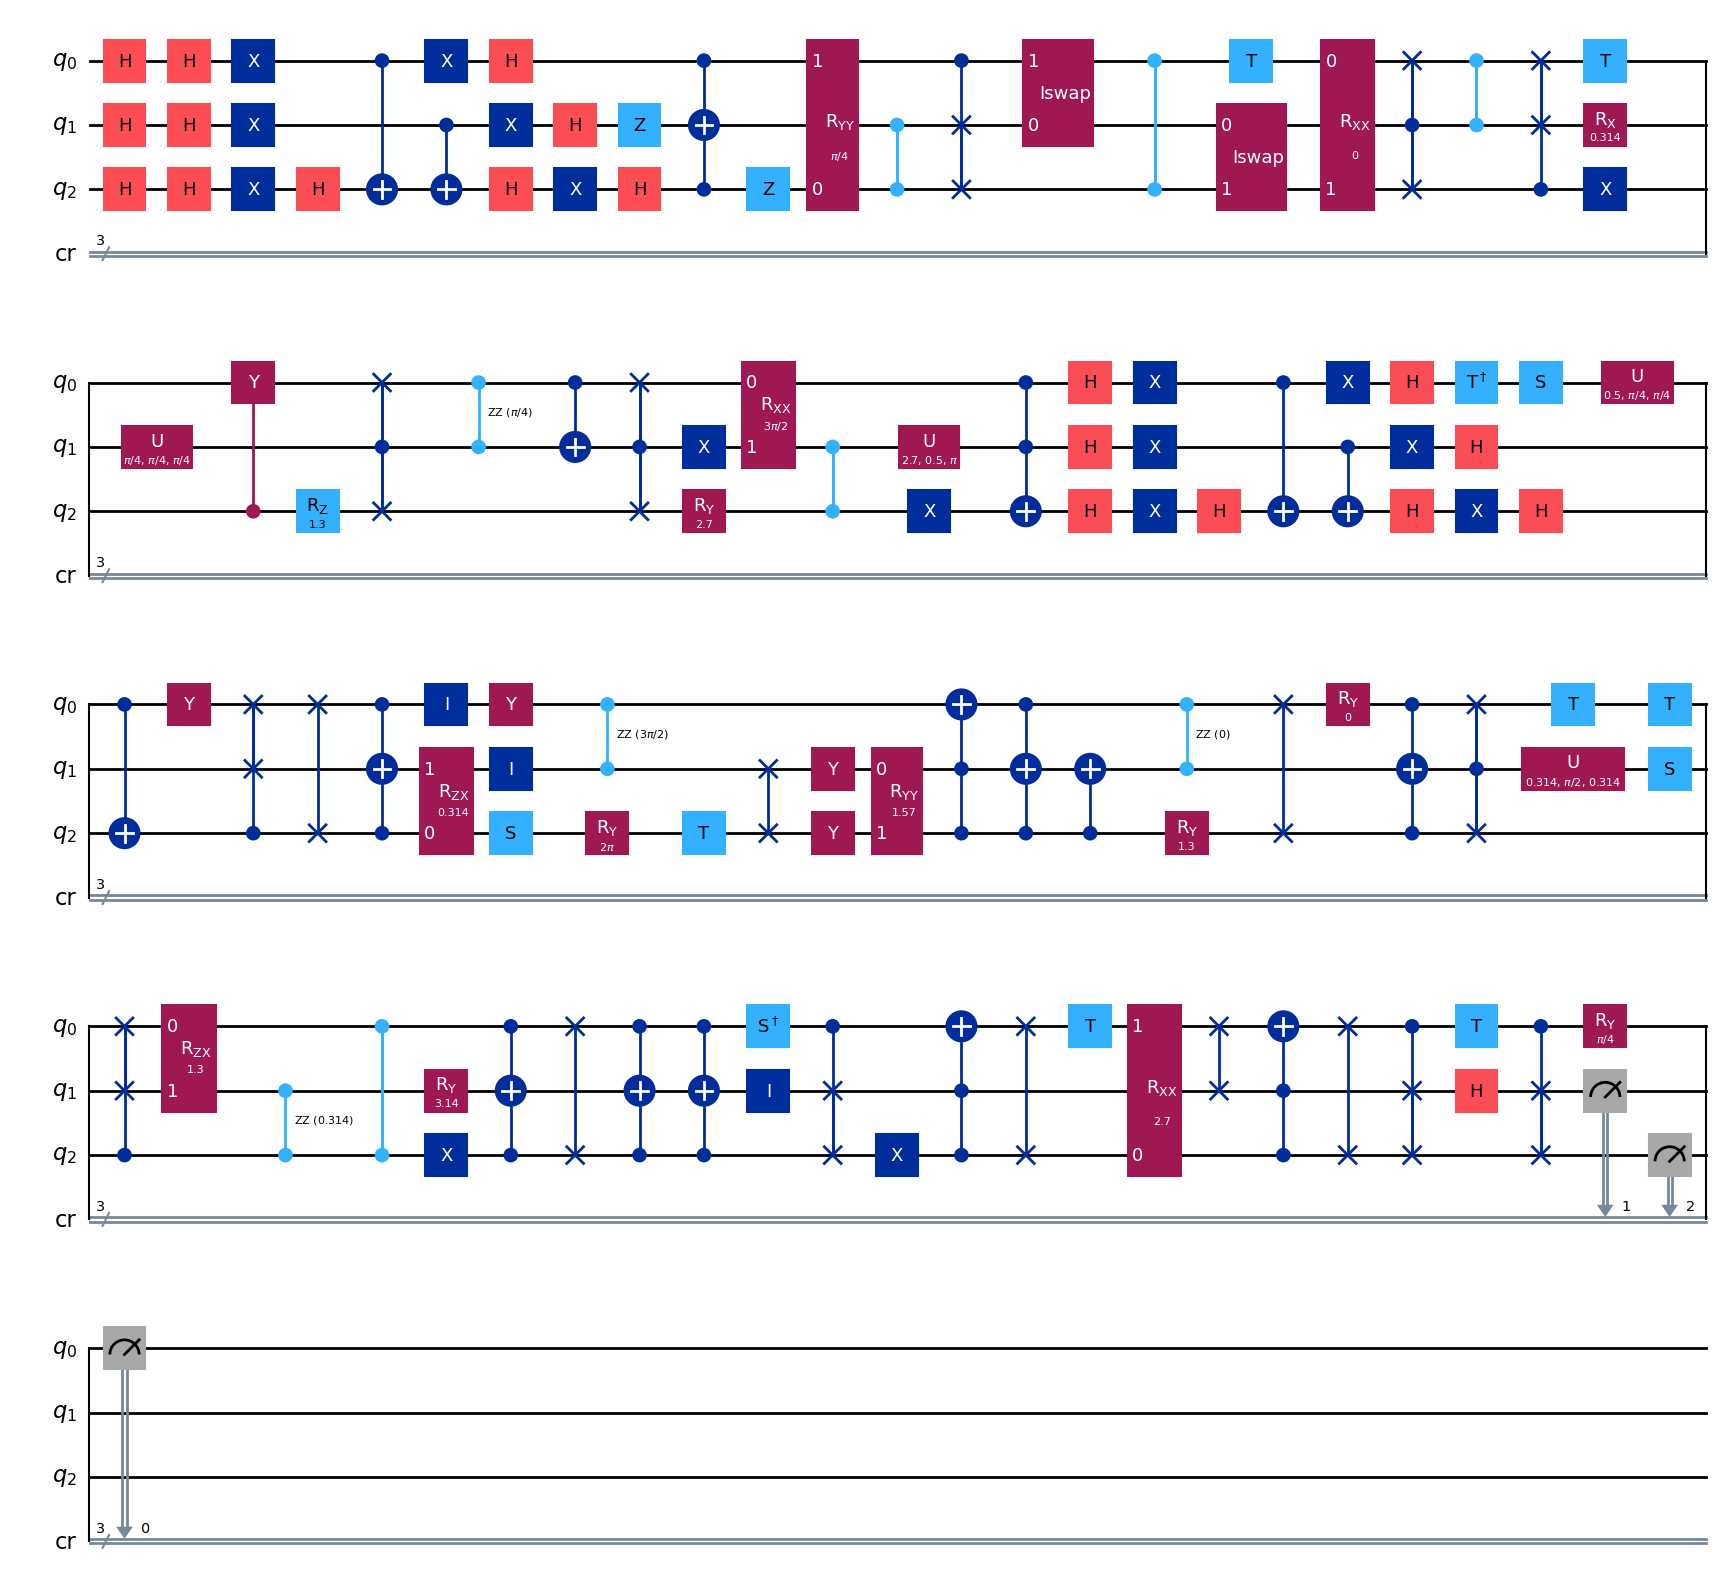

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 19

[Generation 8] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


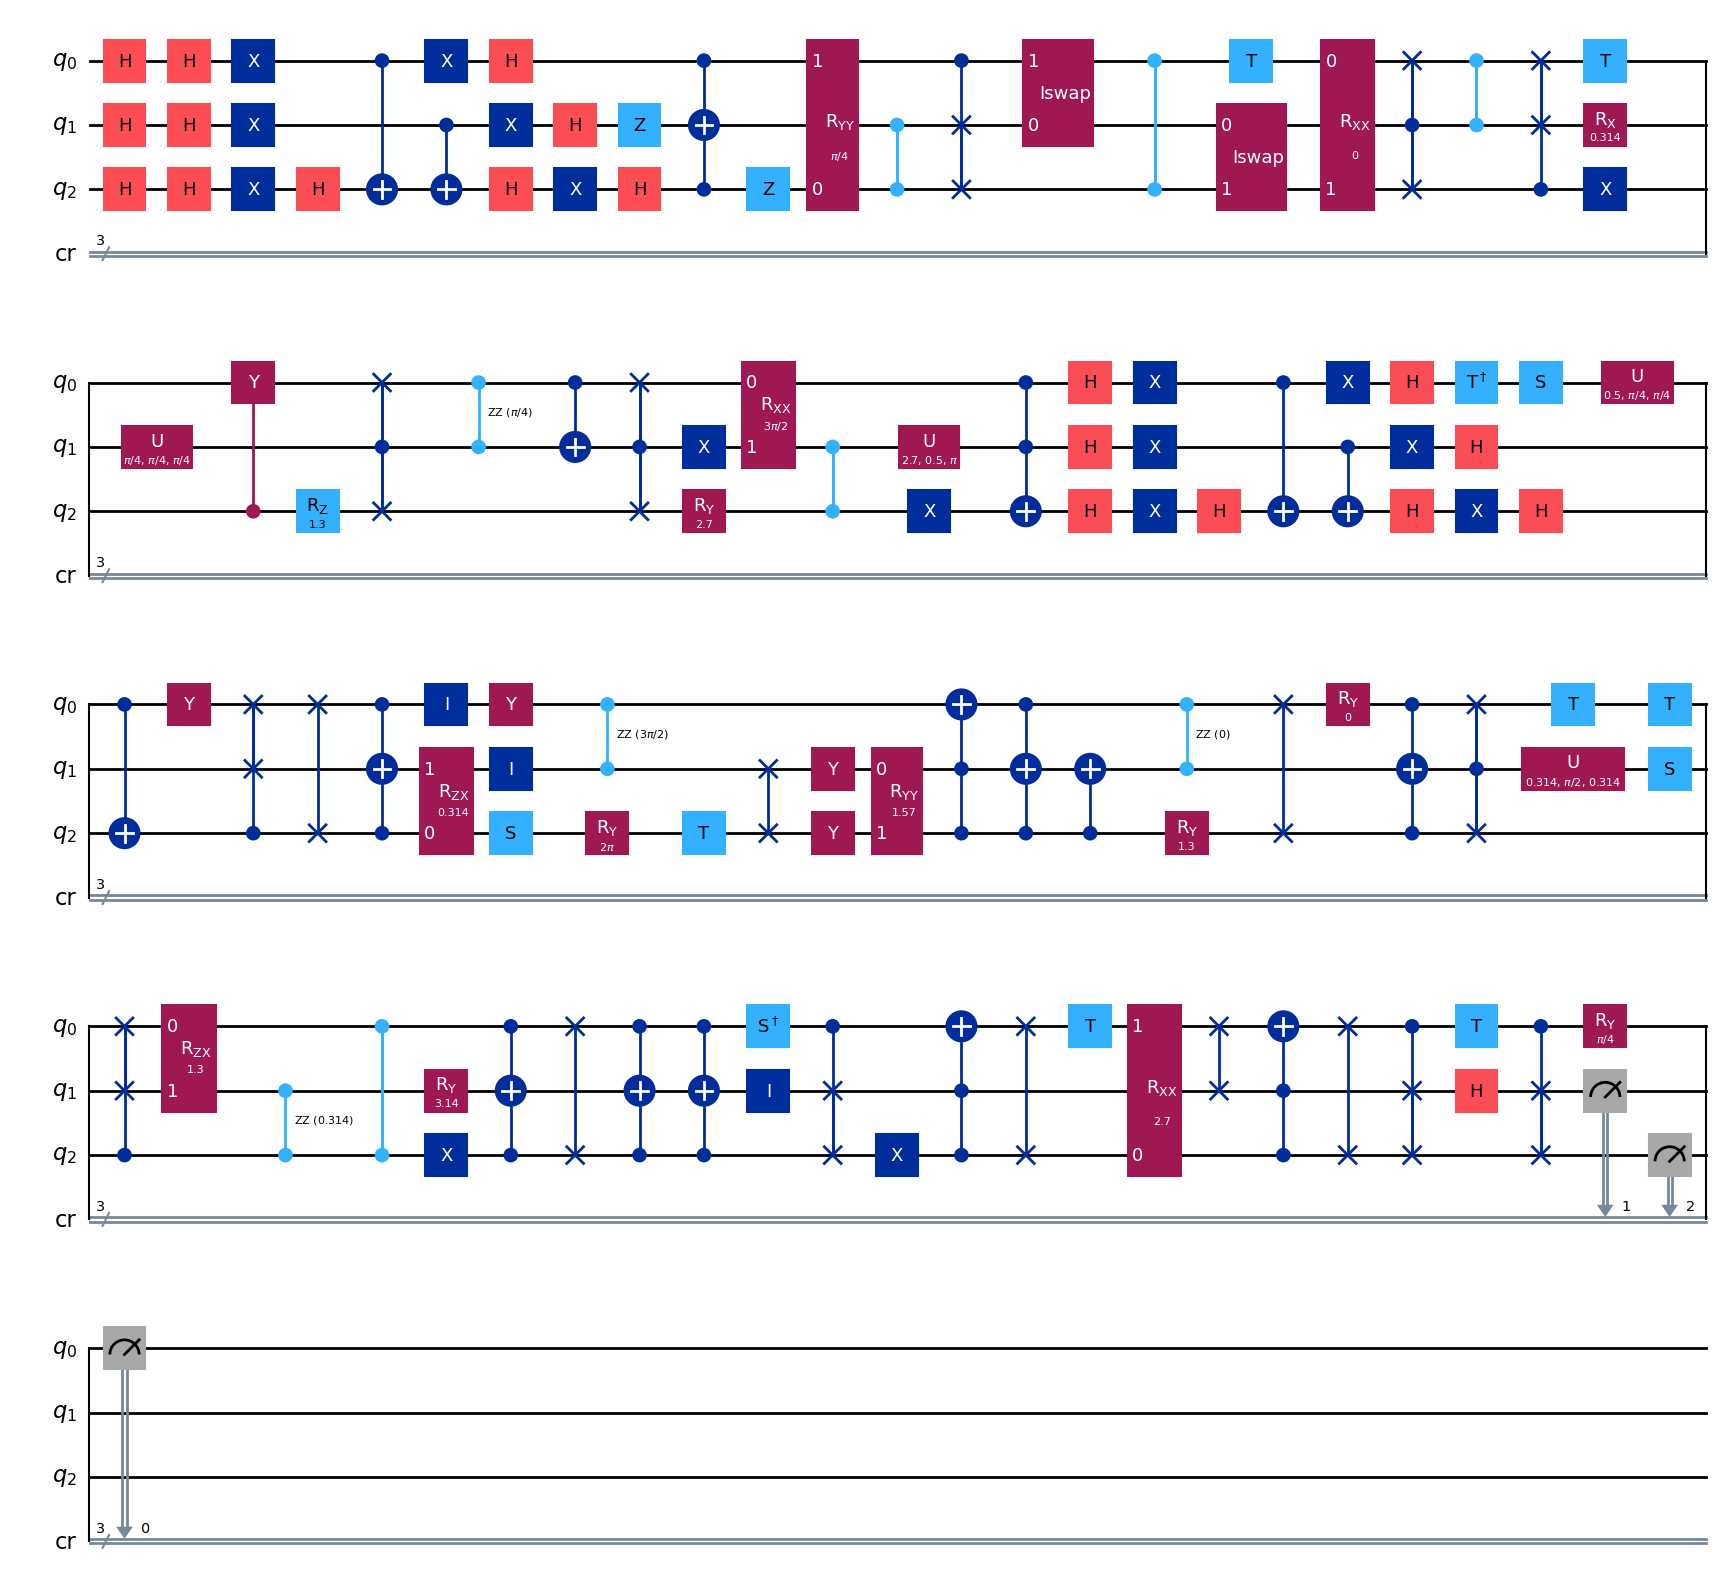

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 12

[Generation 9] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


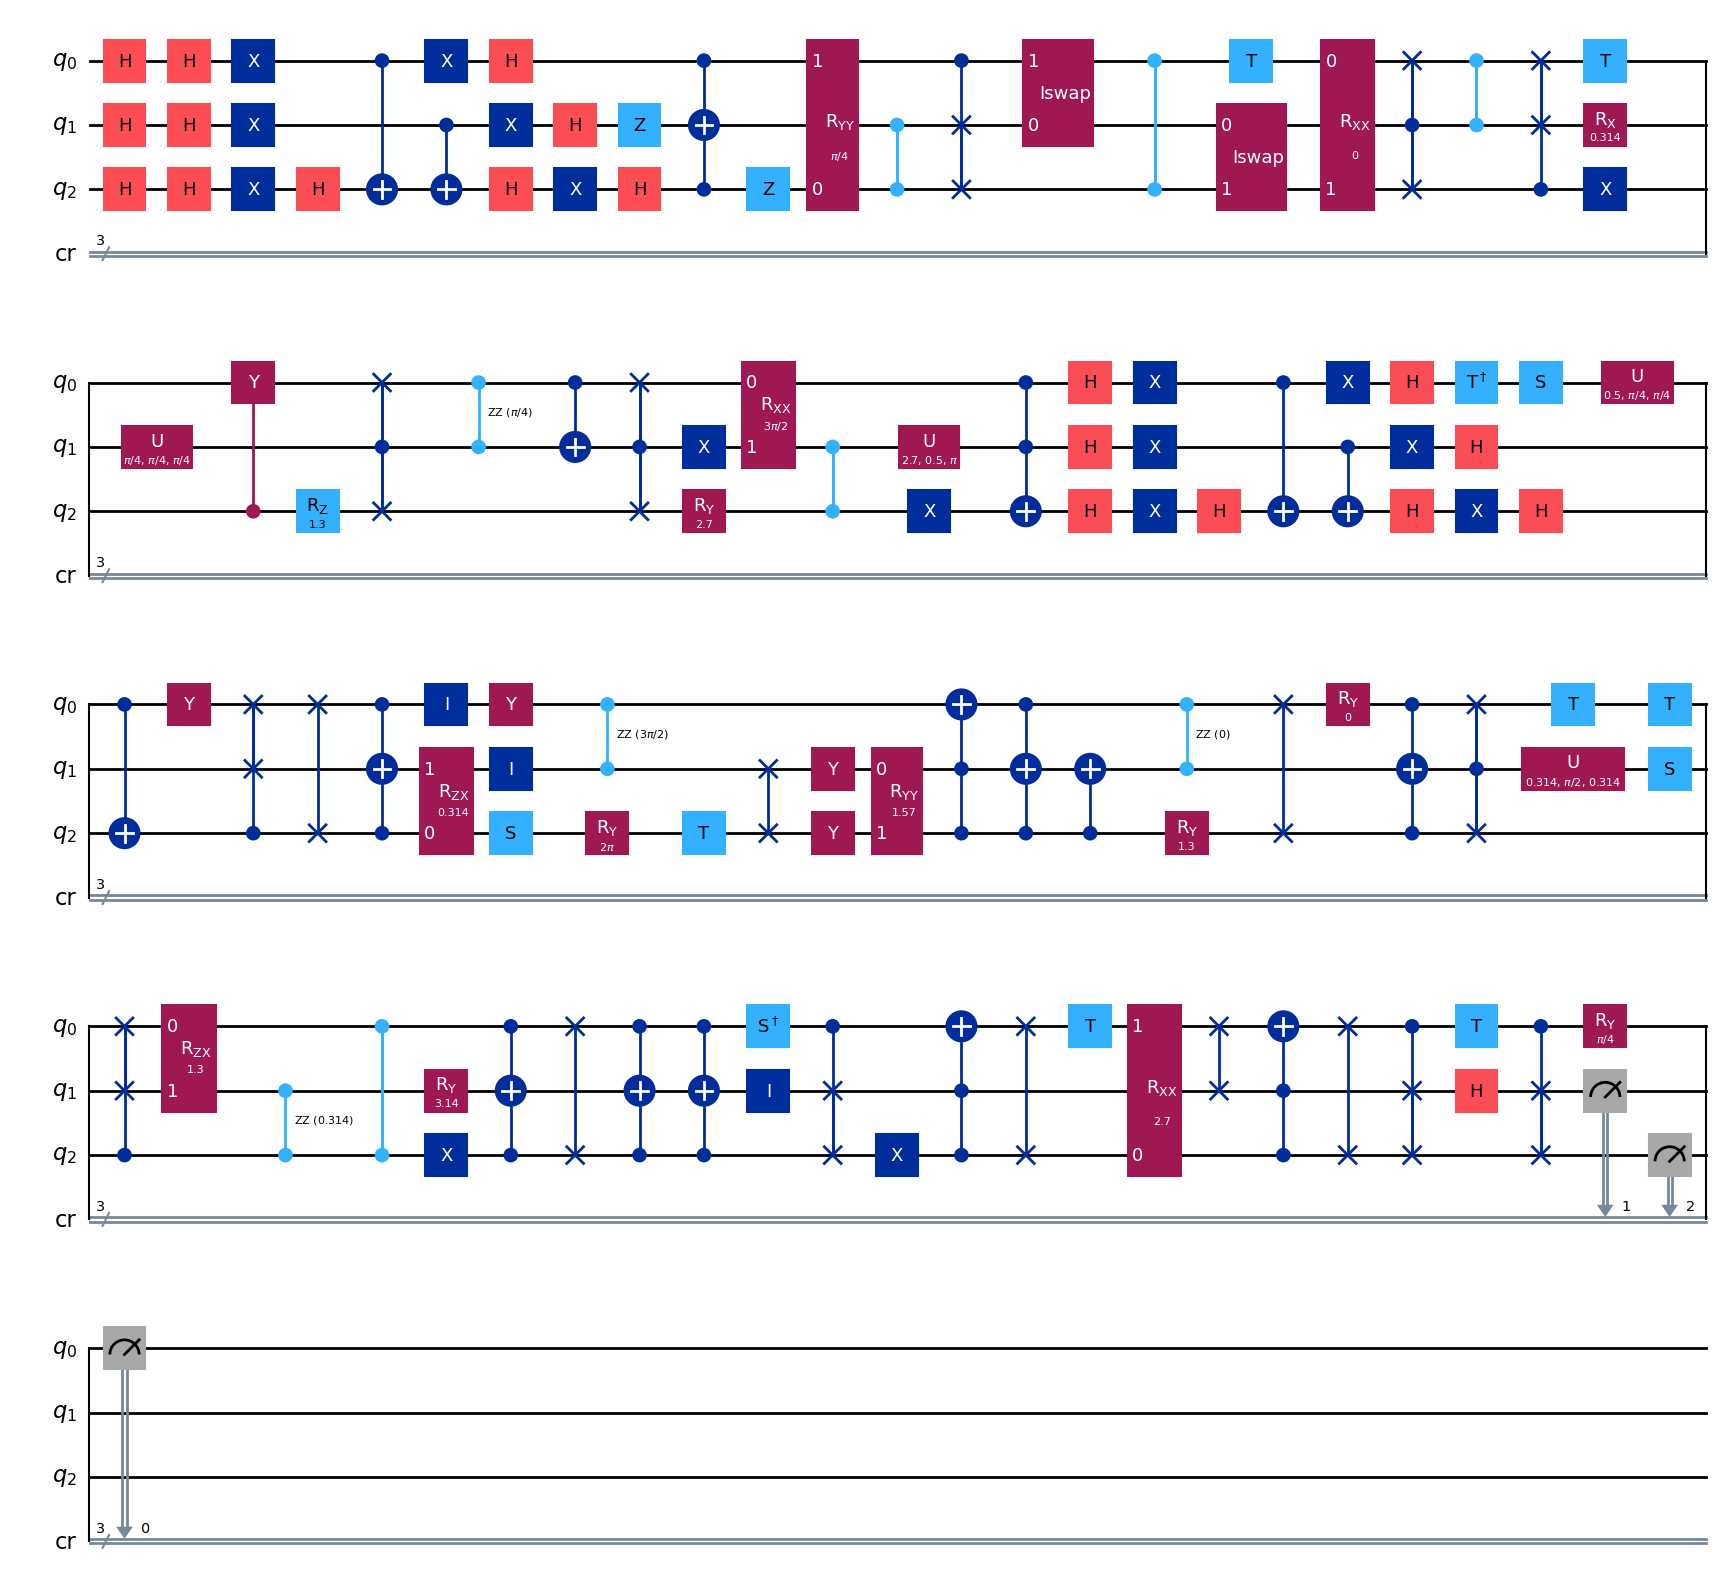

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 14

[Generation 10] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


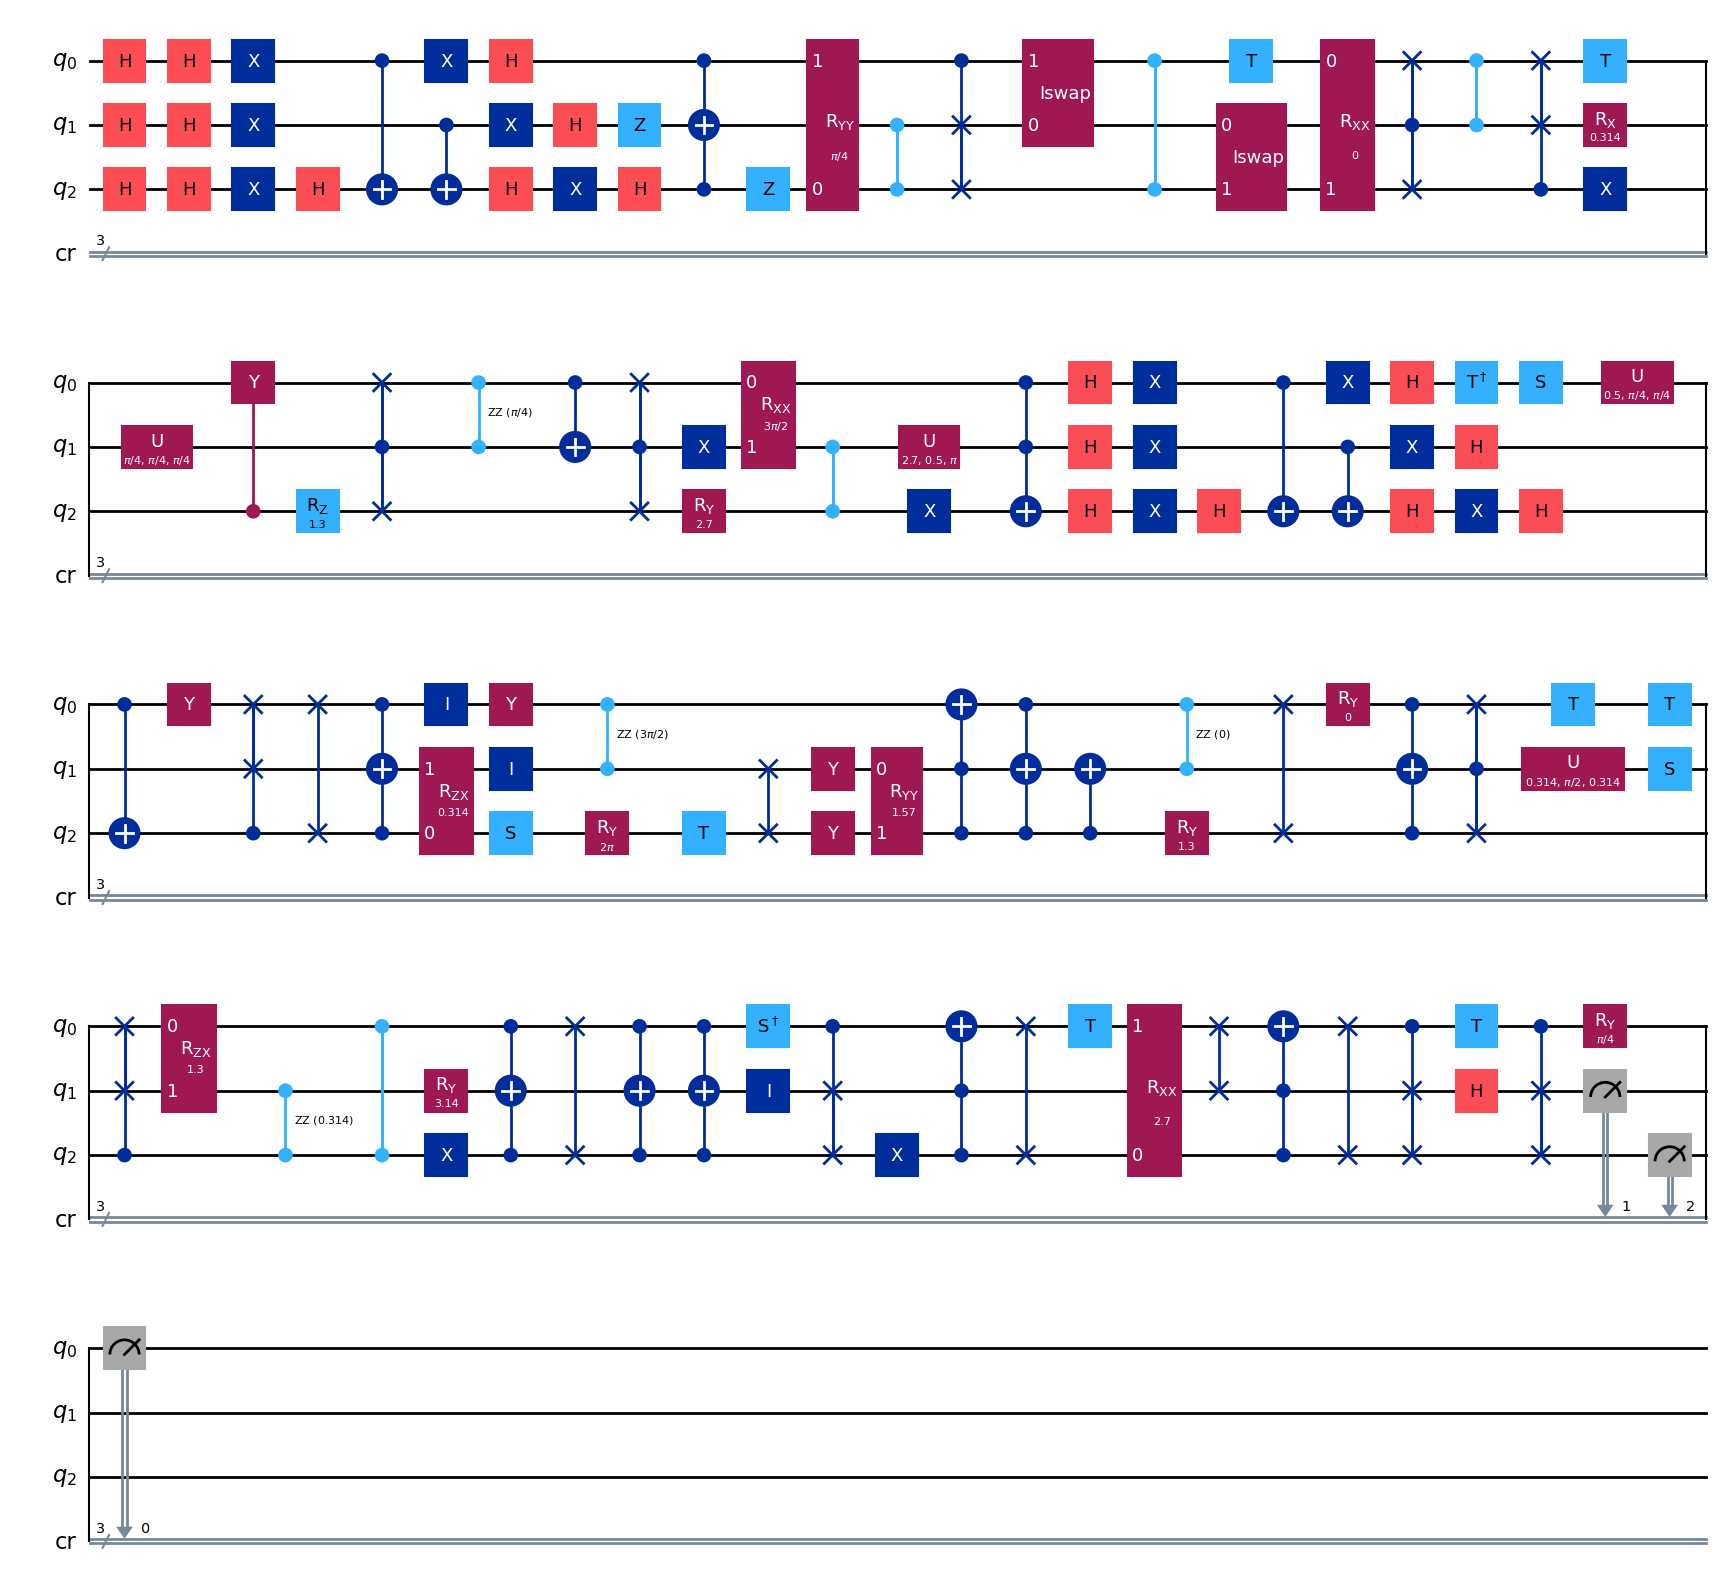

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 18

[Generation 11] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


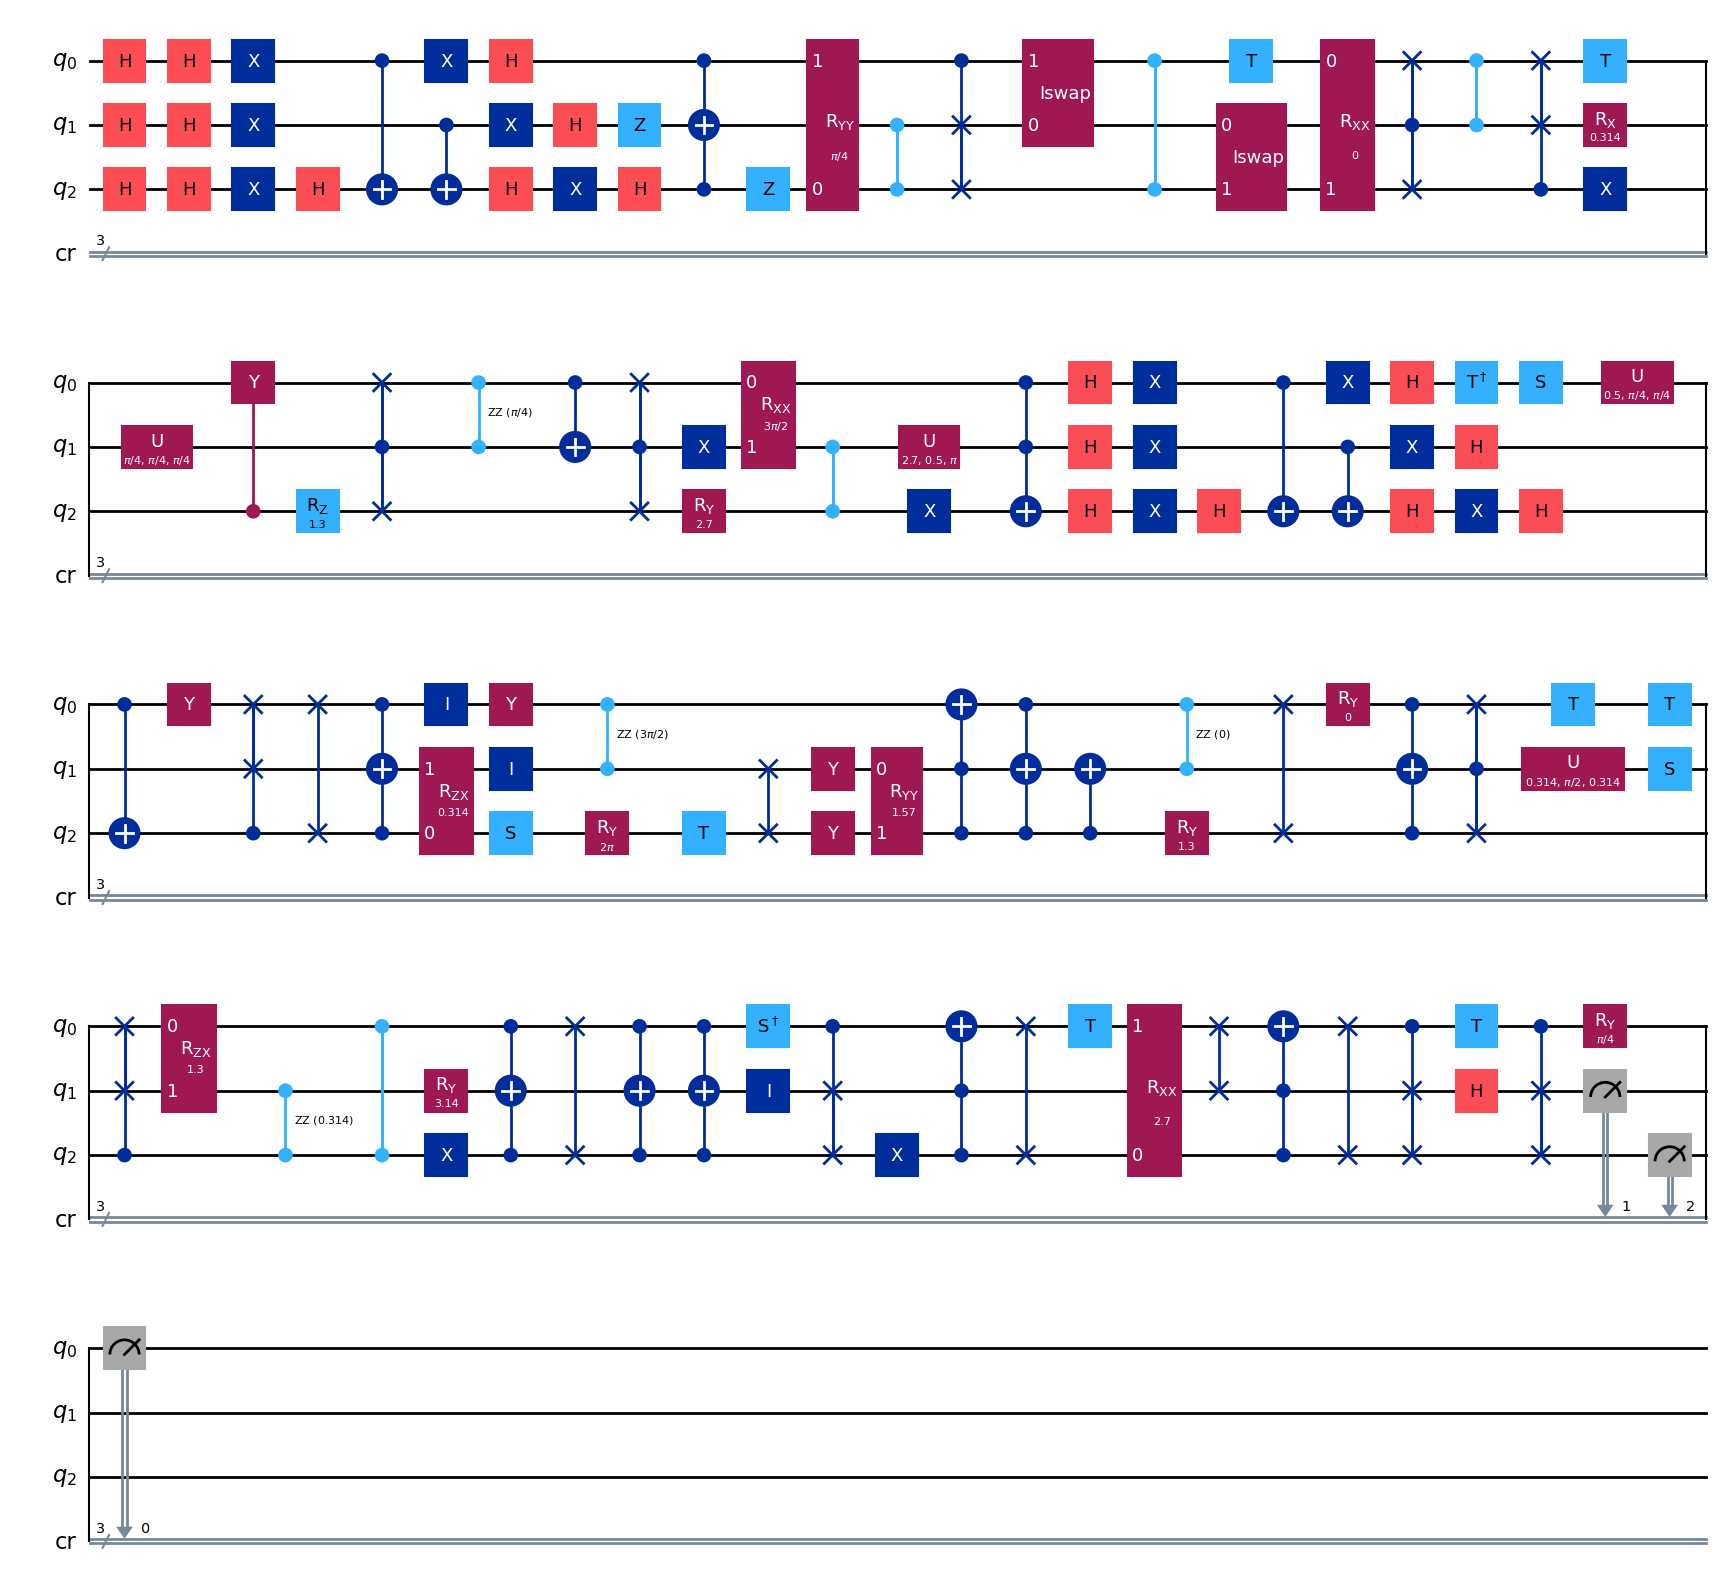

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 12

[Generation 12] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


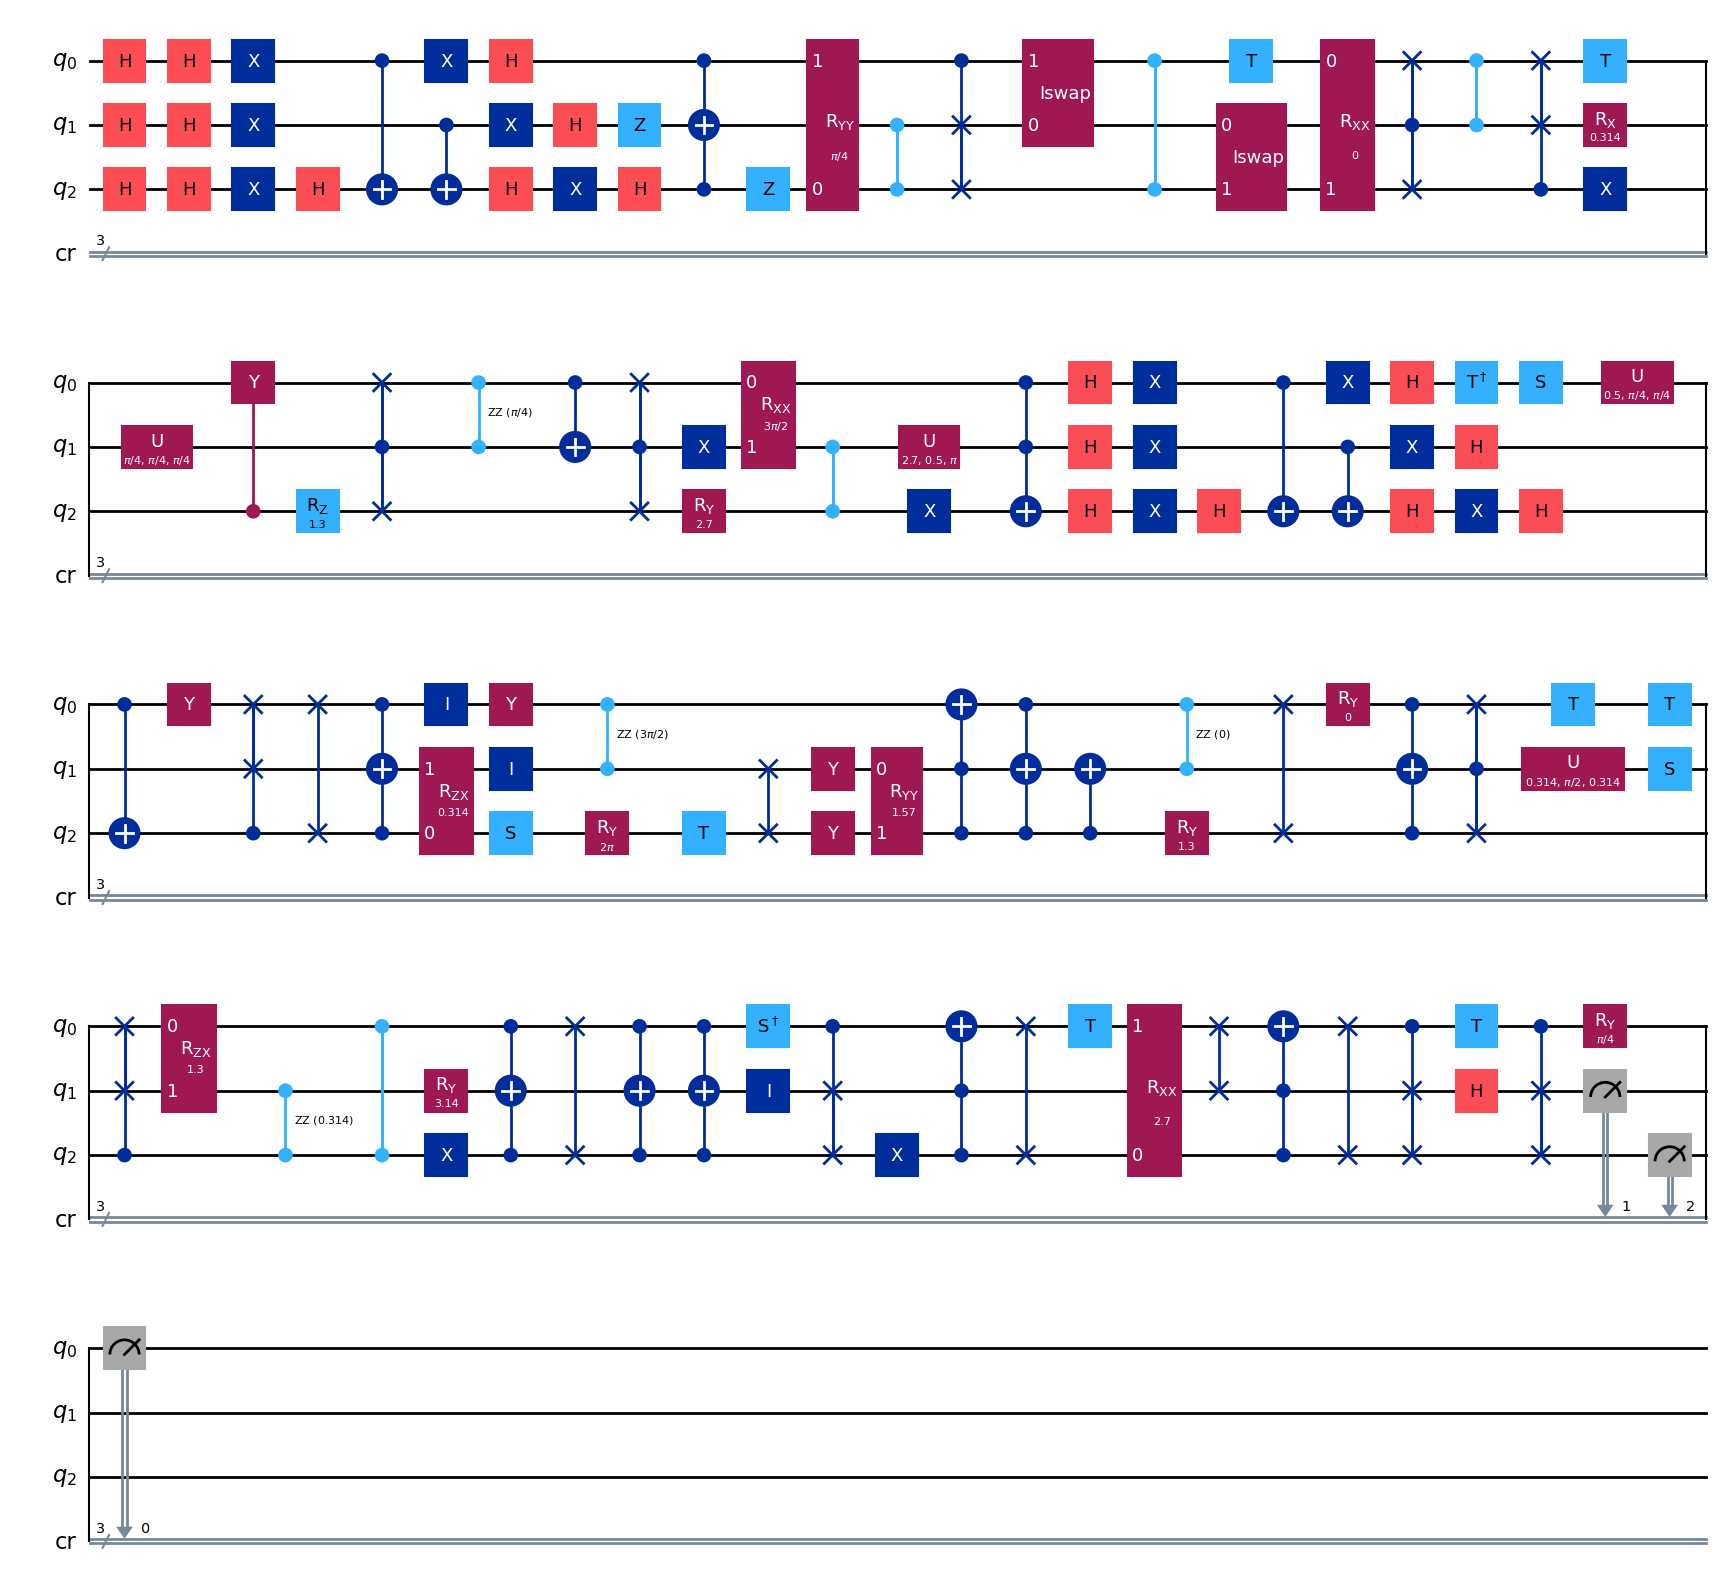

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 5

[Generation 13] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


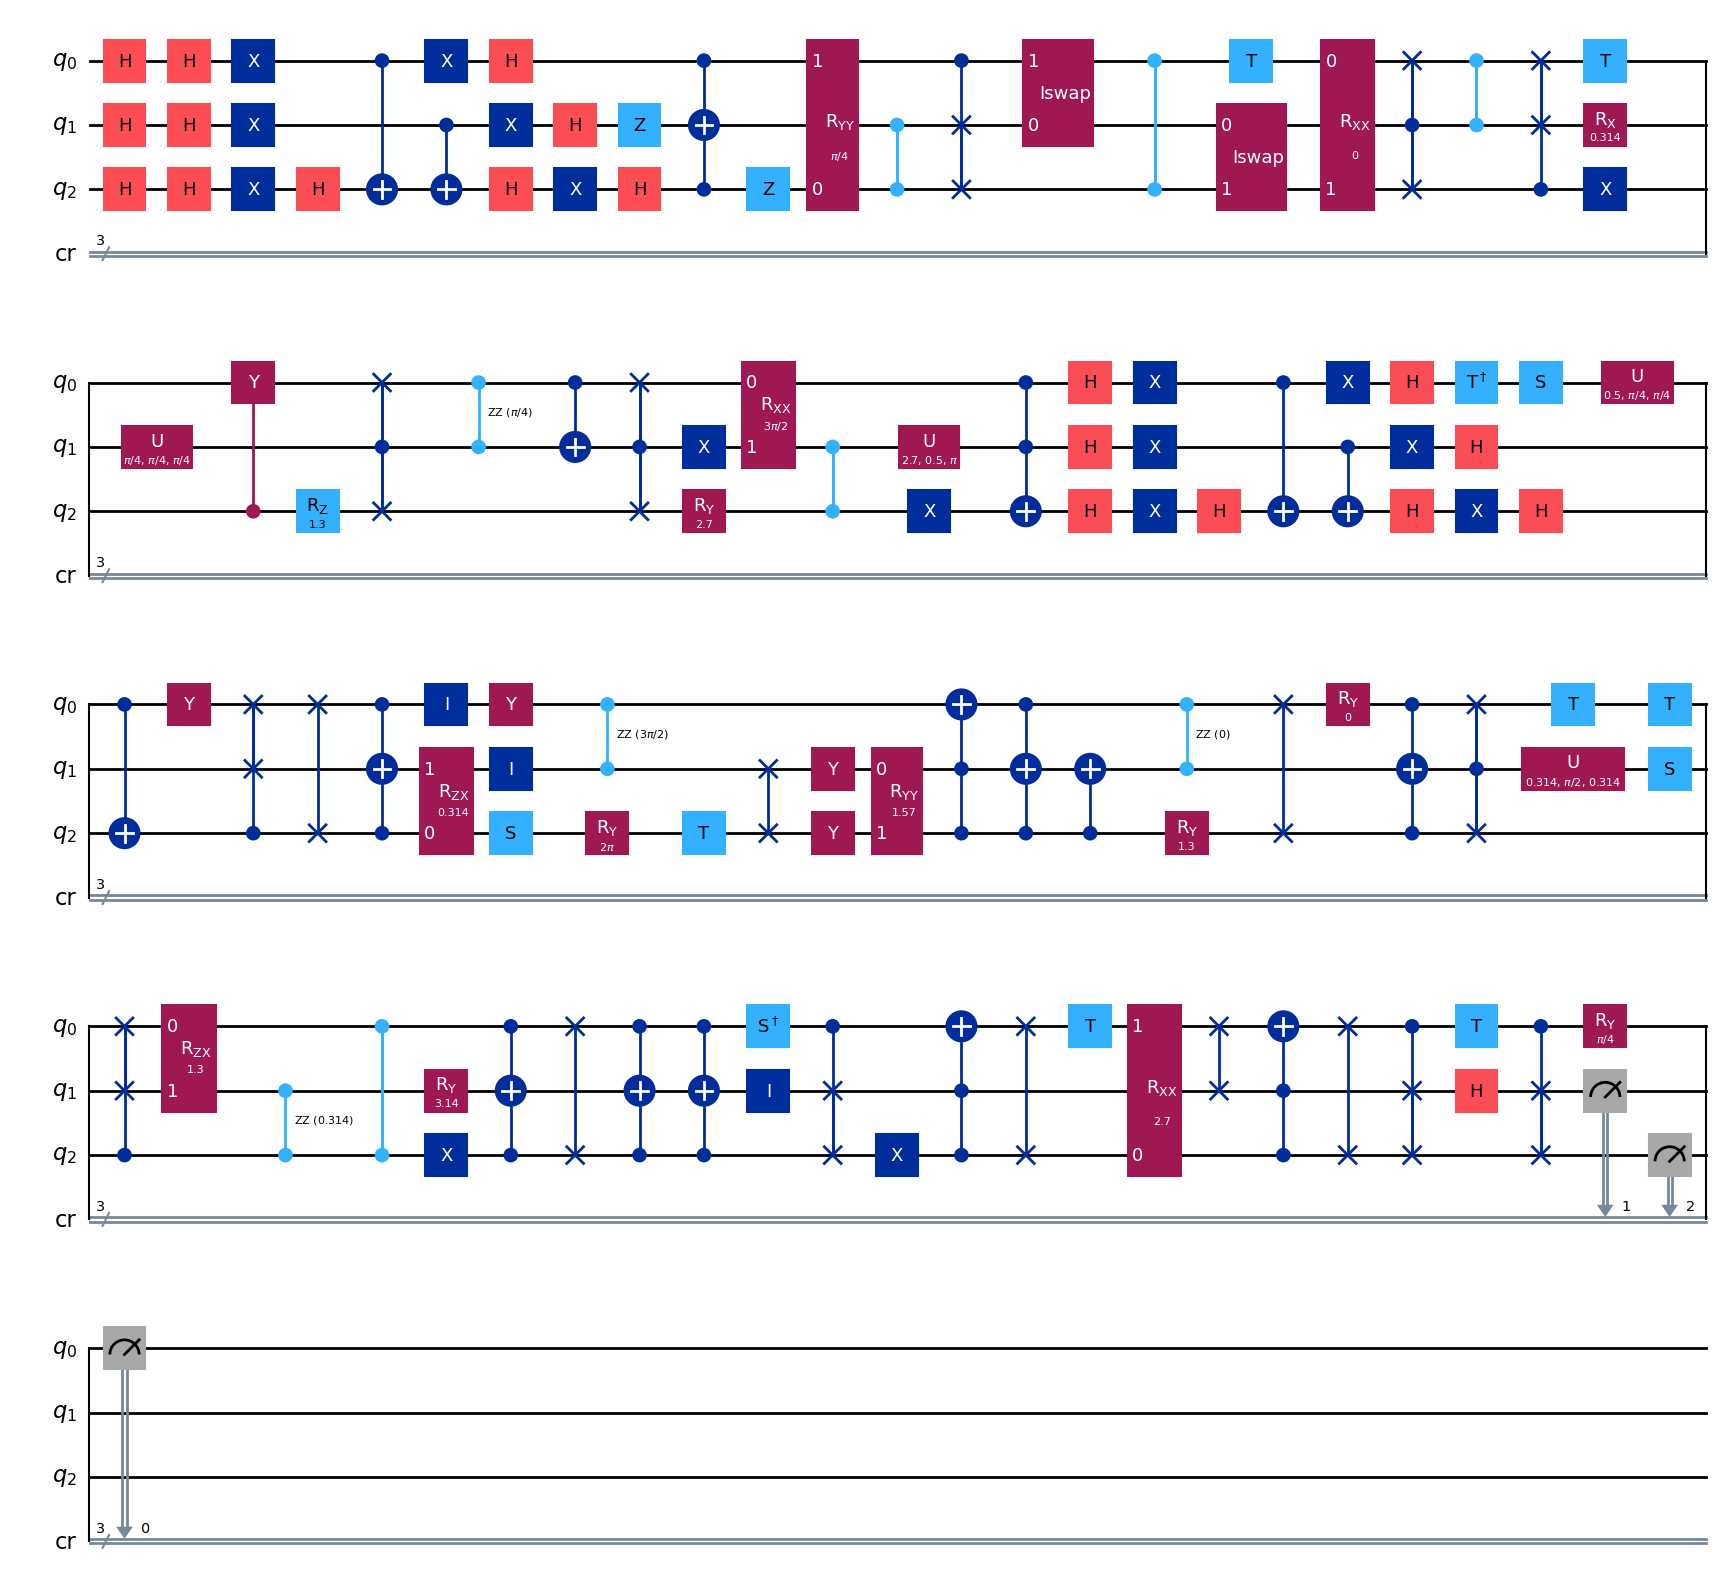

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 8

[Generation 14] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


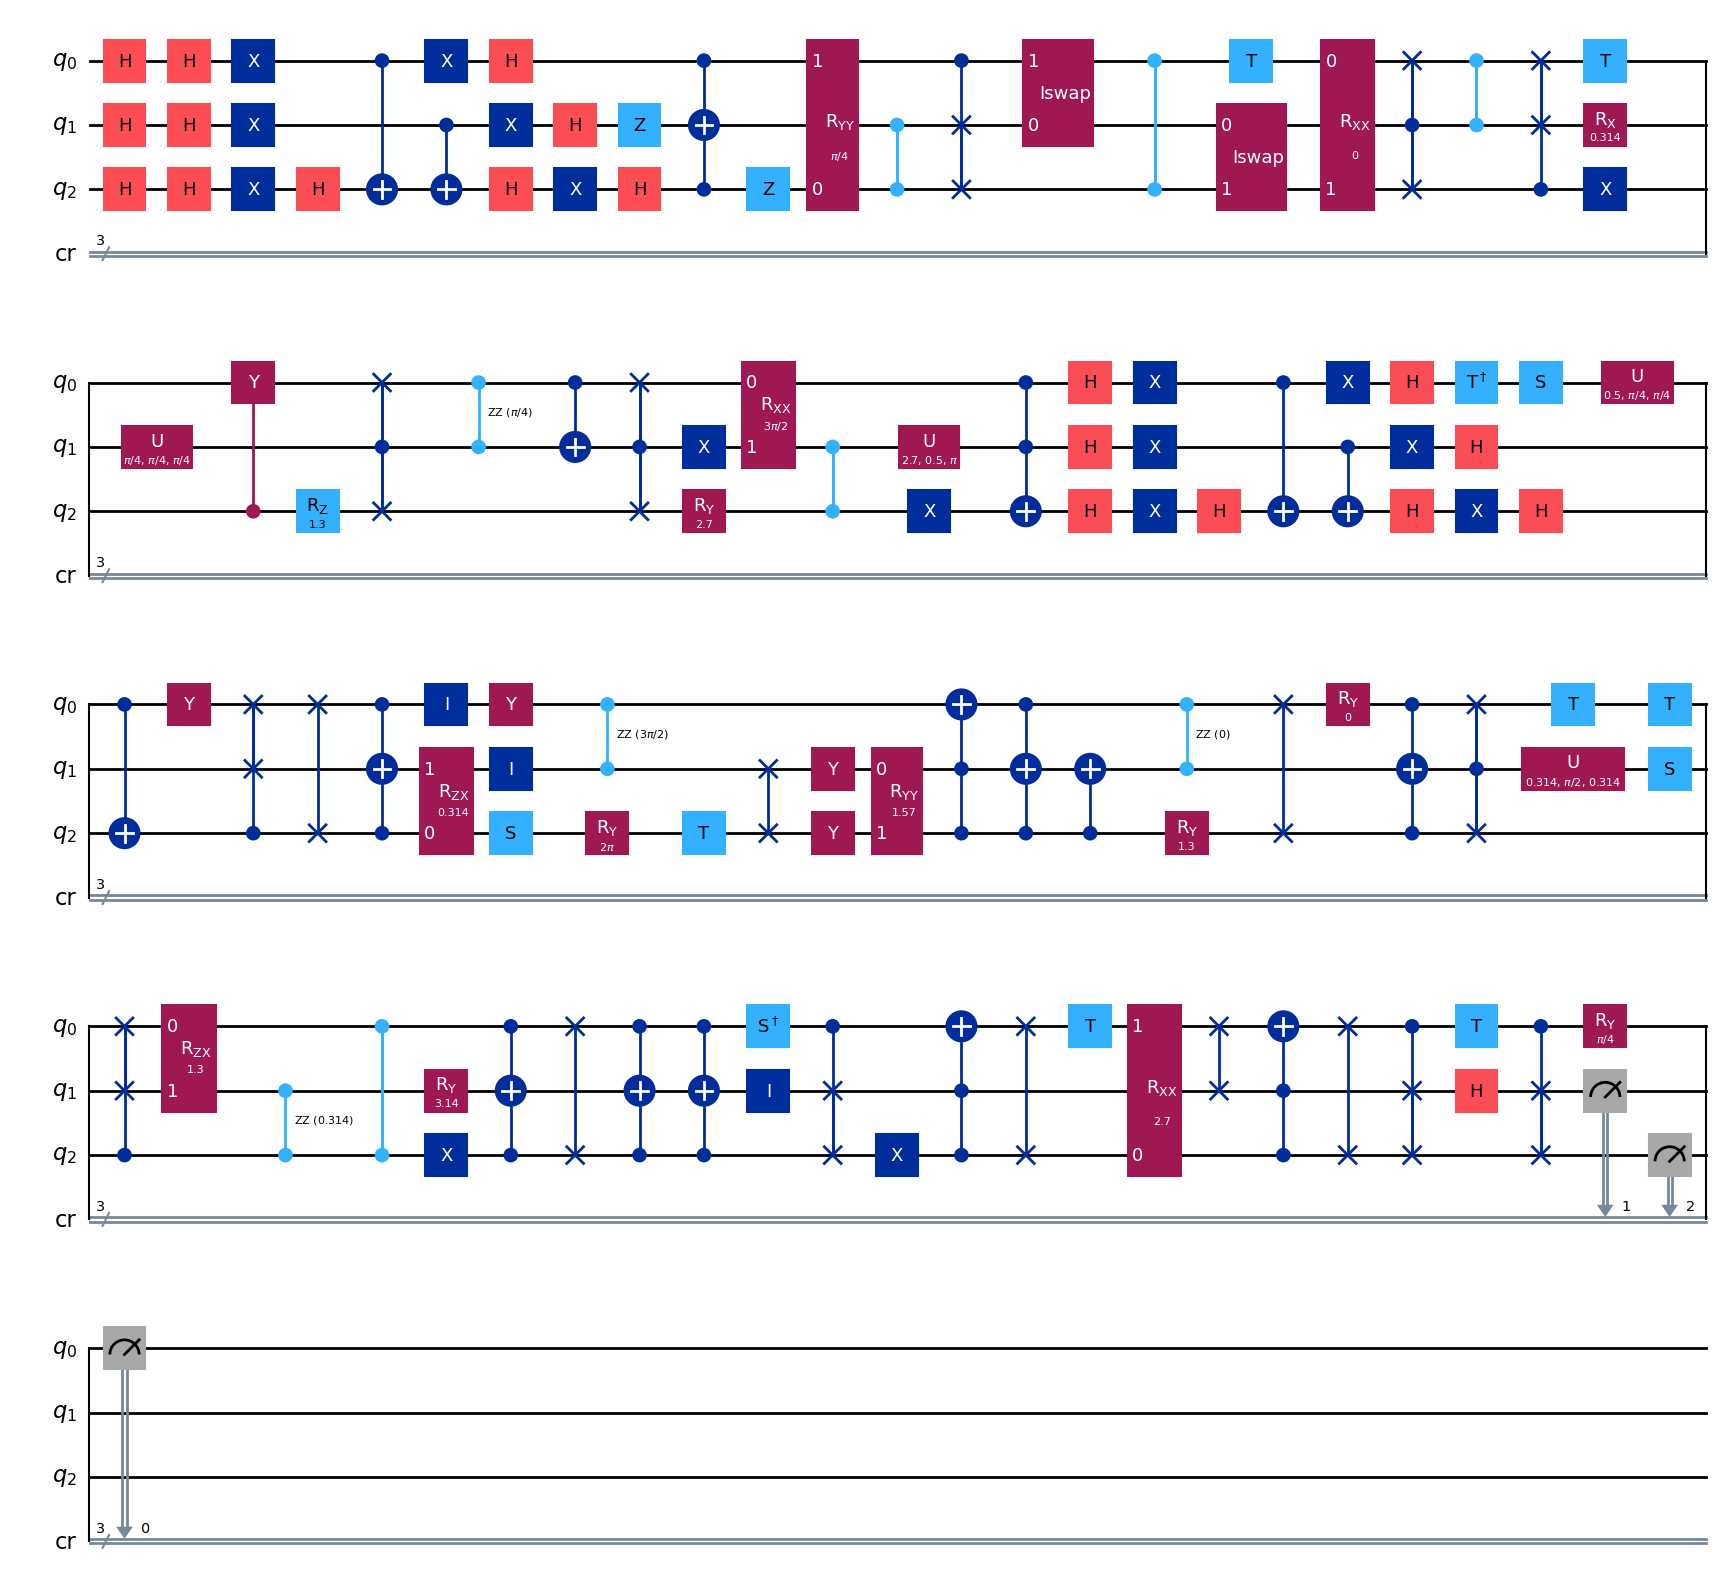

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 3

[Generation 15] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


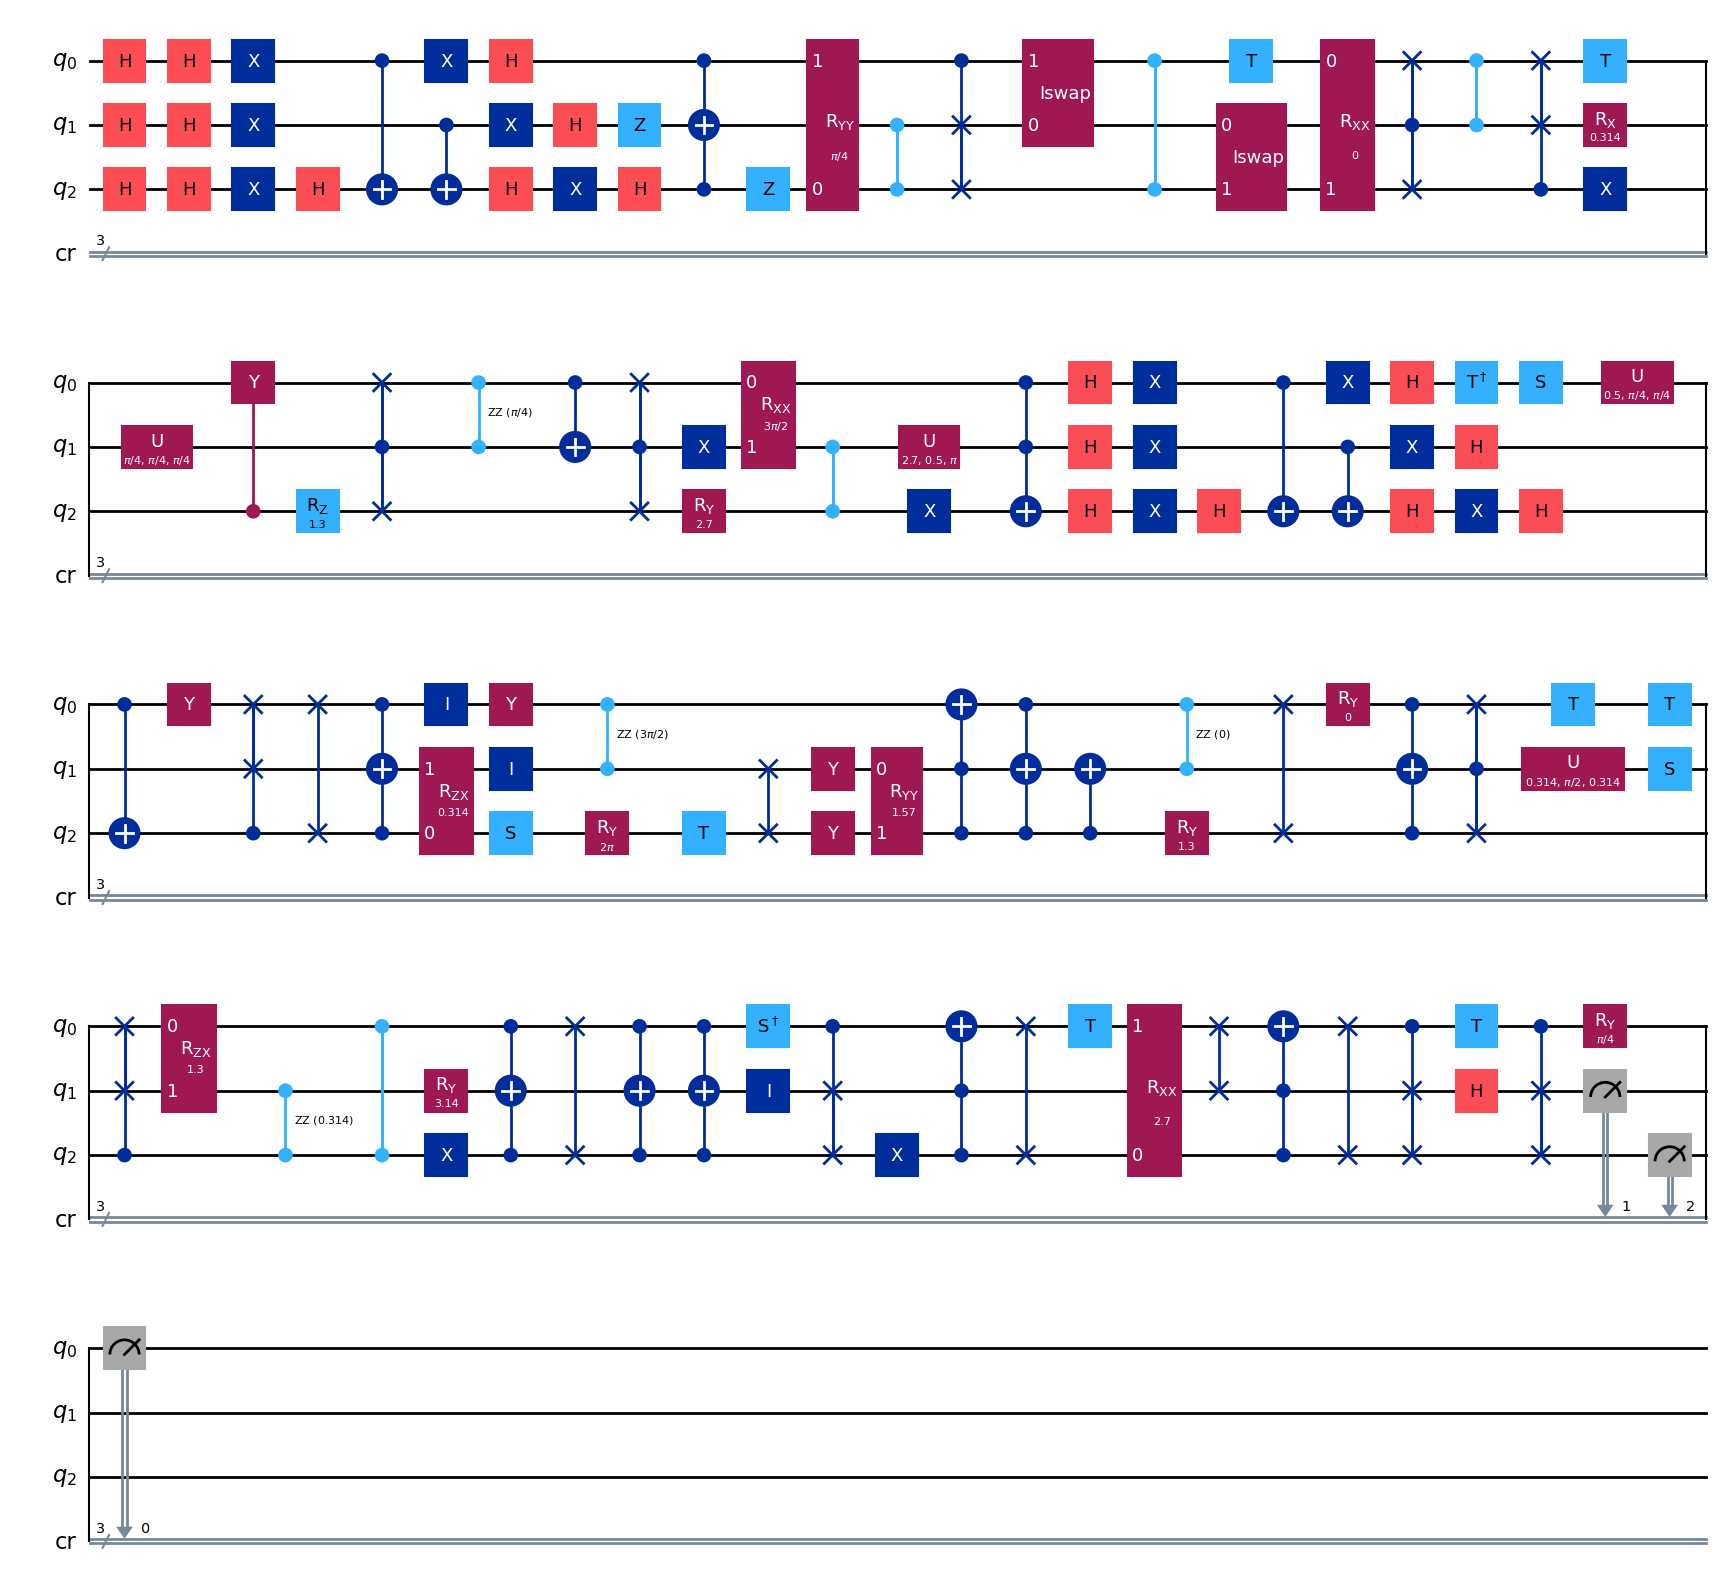

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 3

[Generation 16] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


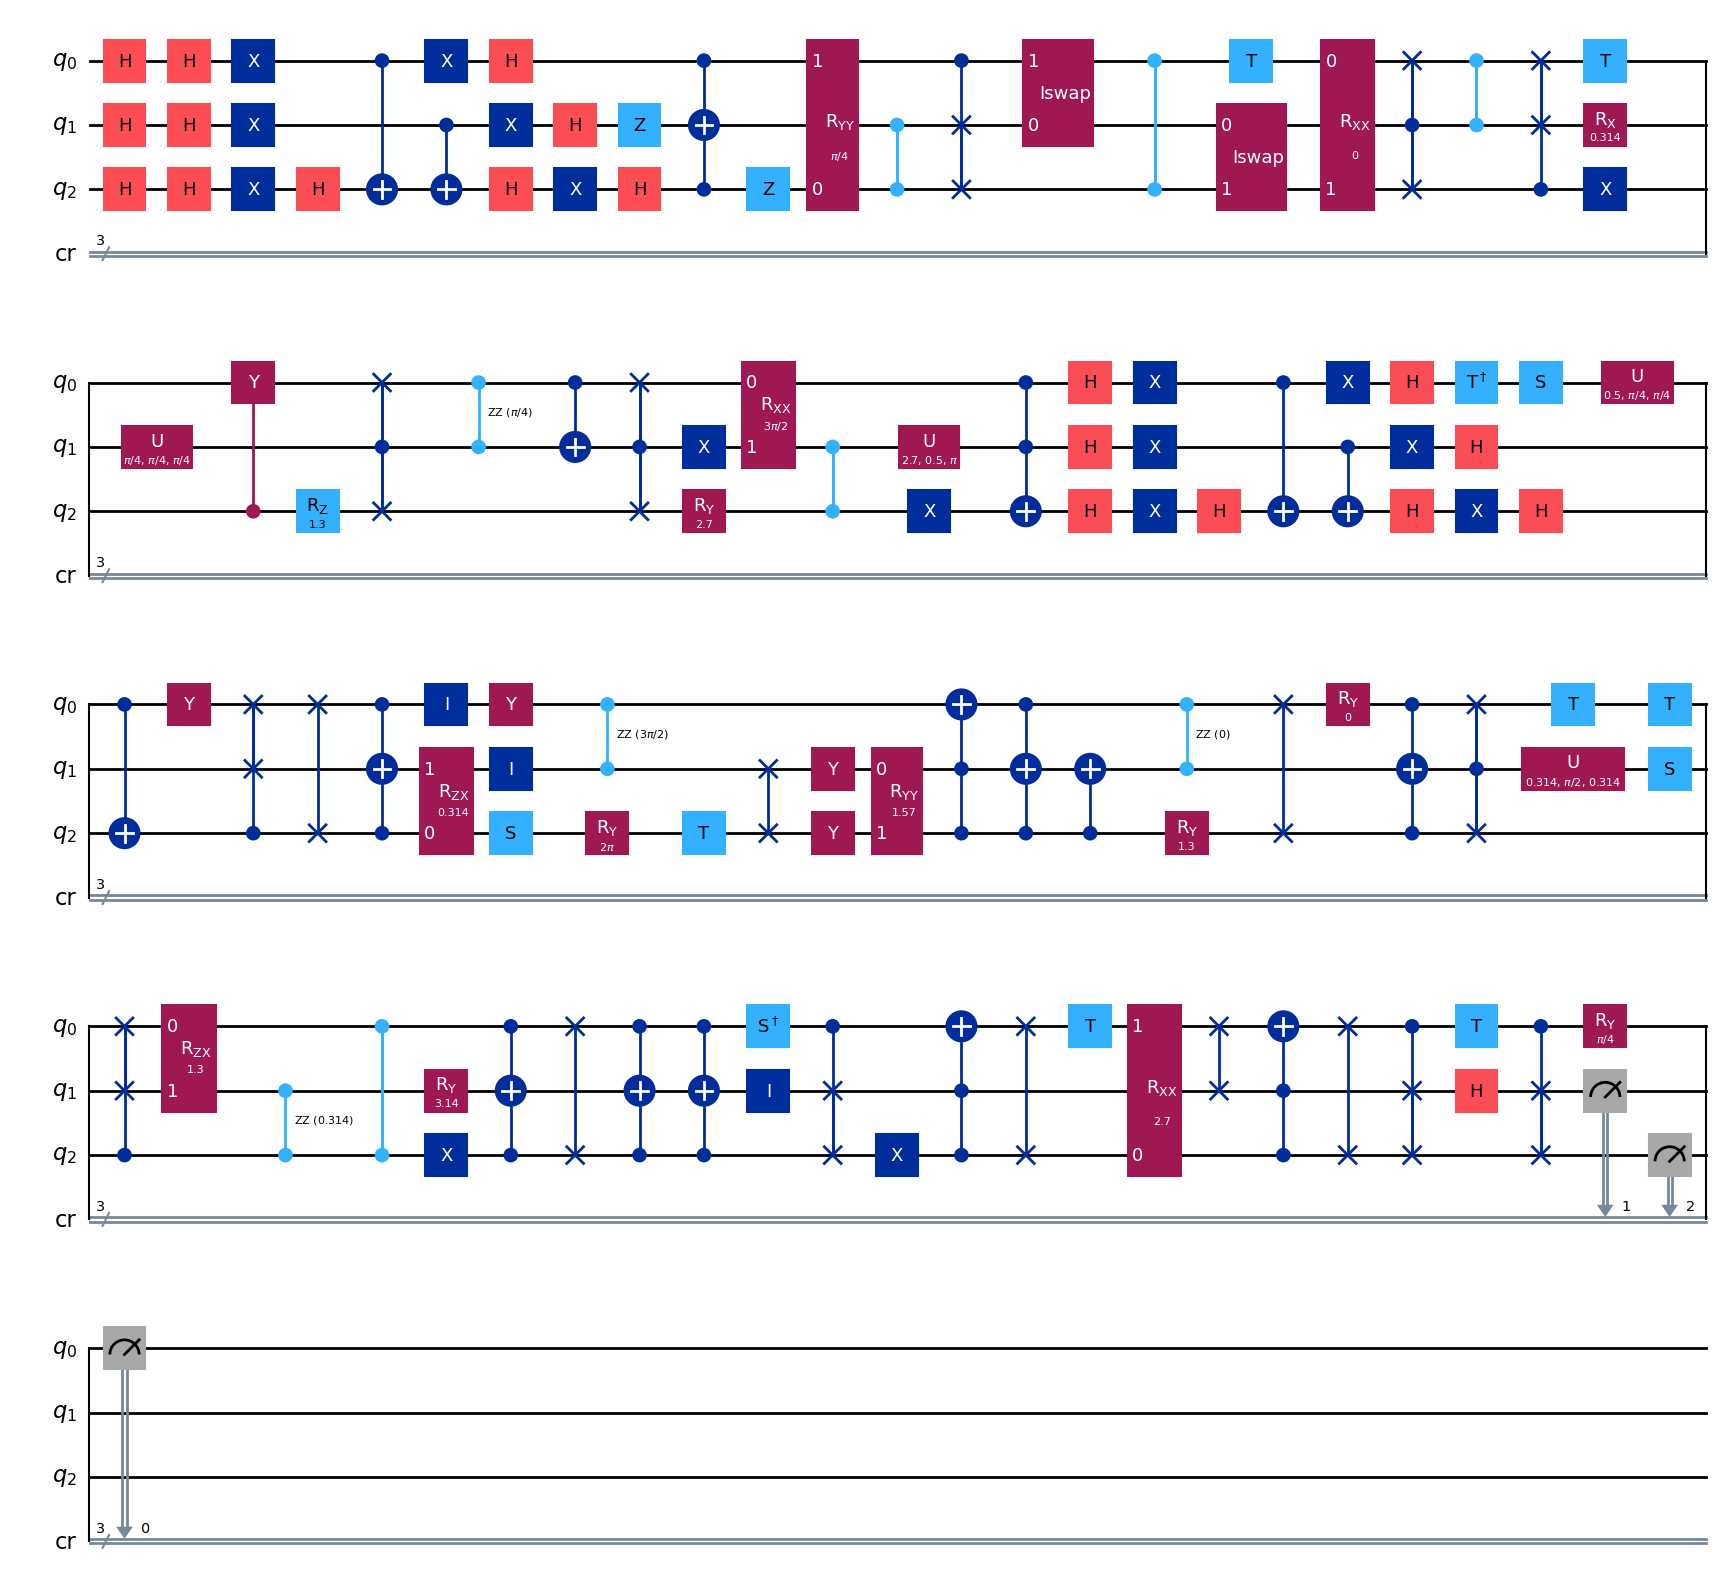

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 6

[Generation 17] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


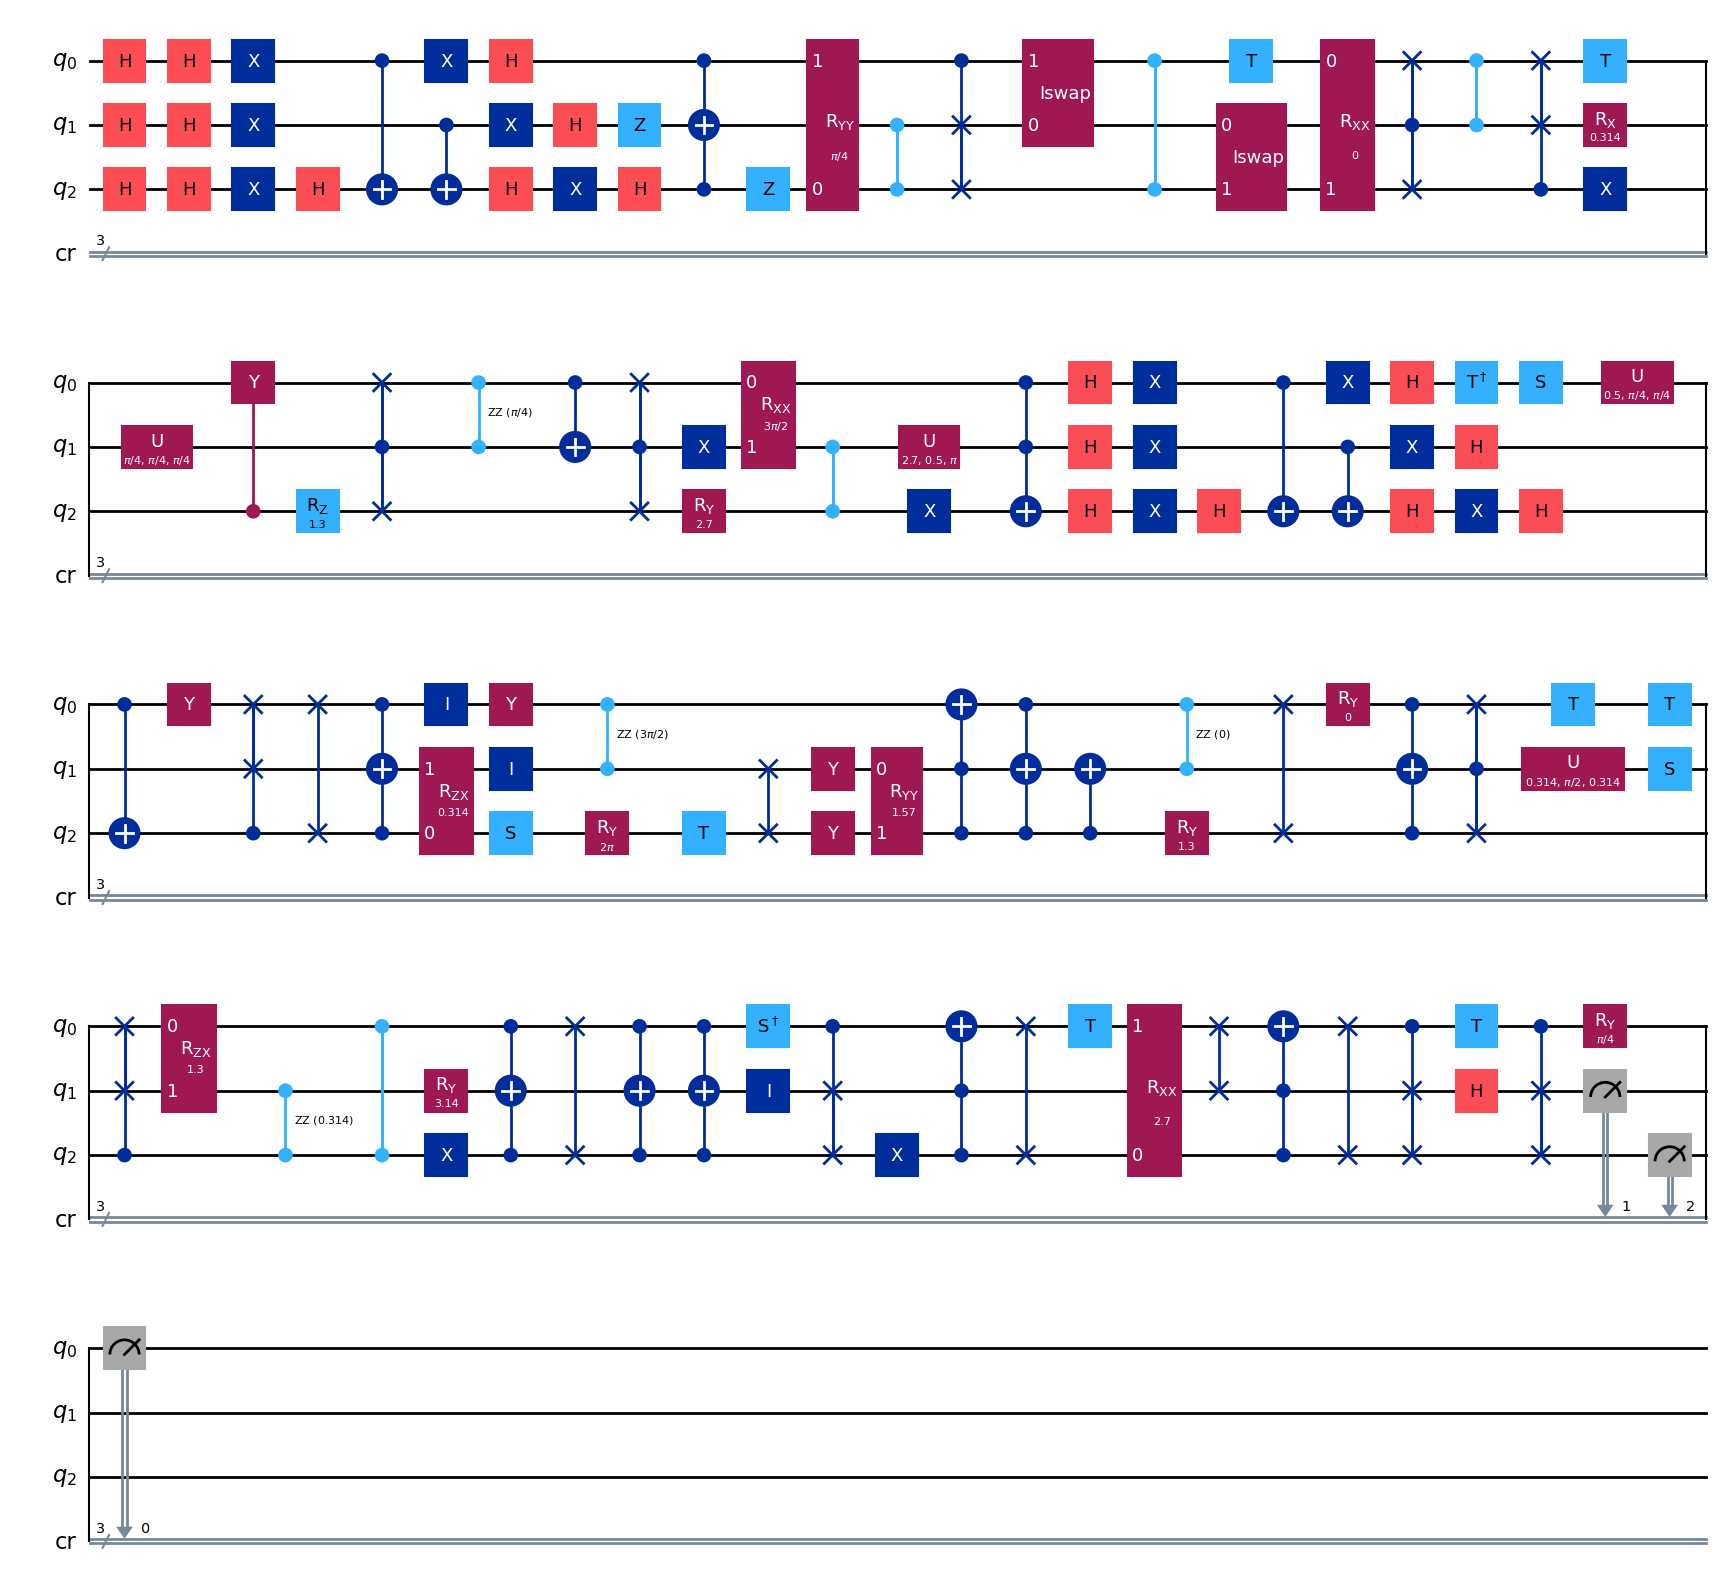

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 2

[Generation 18] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


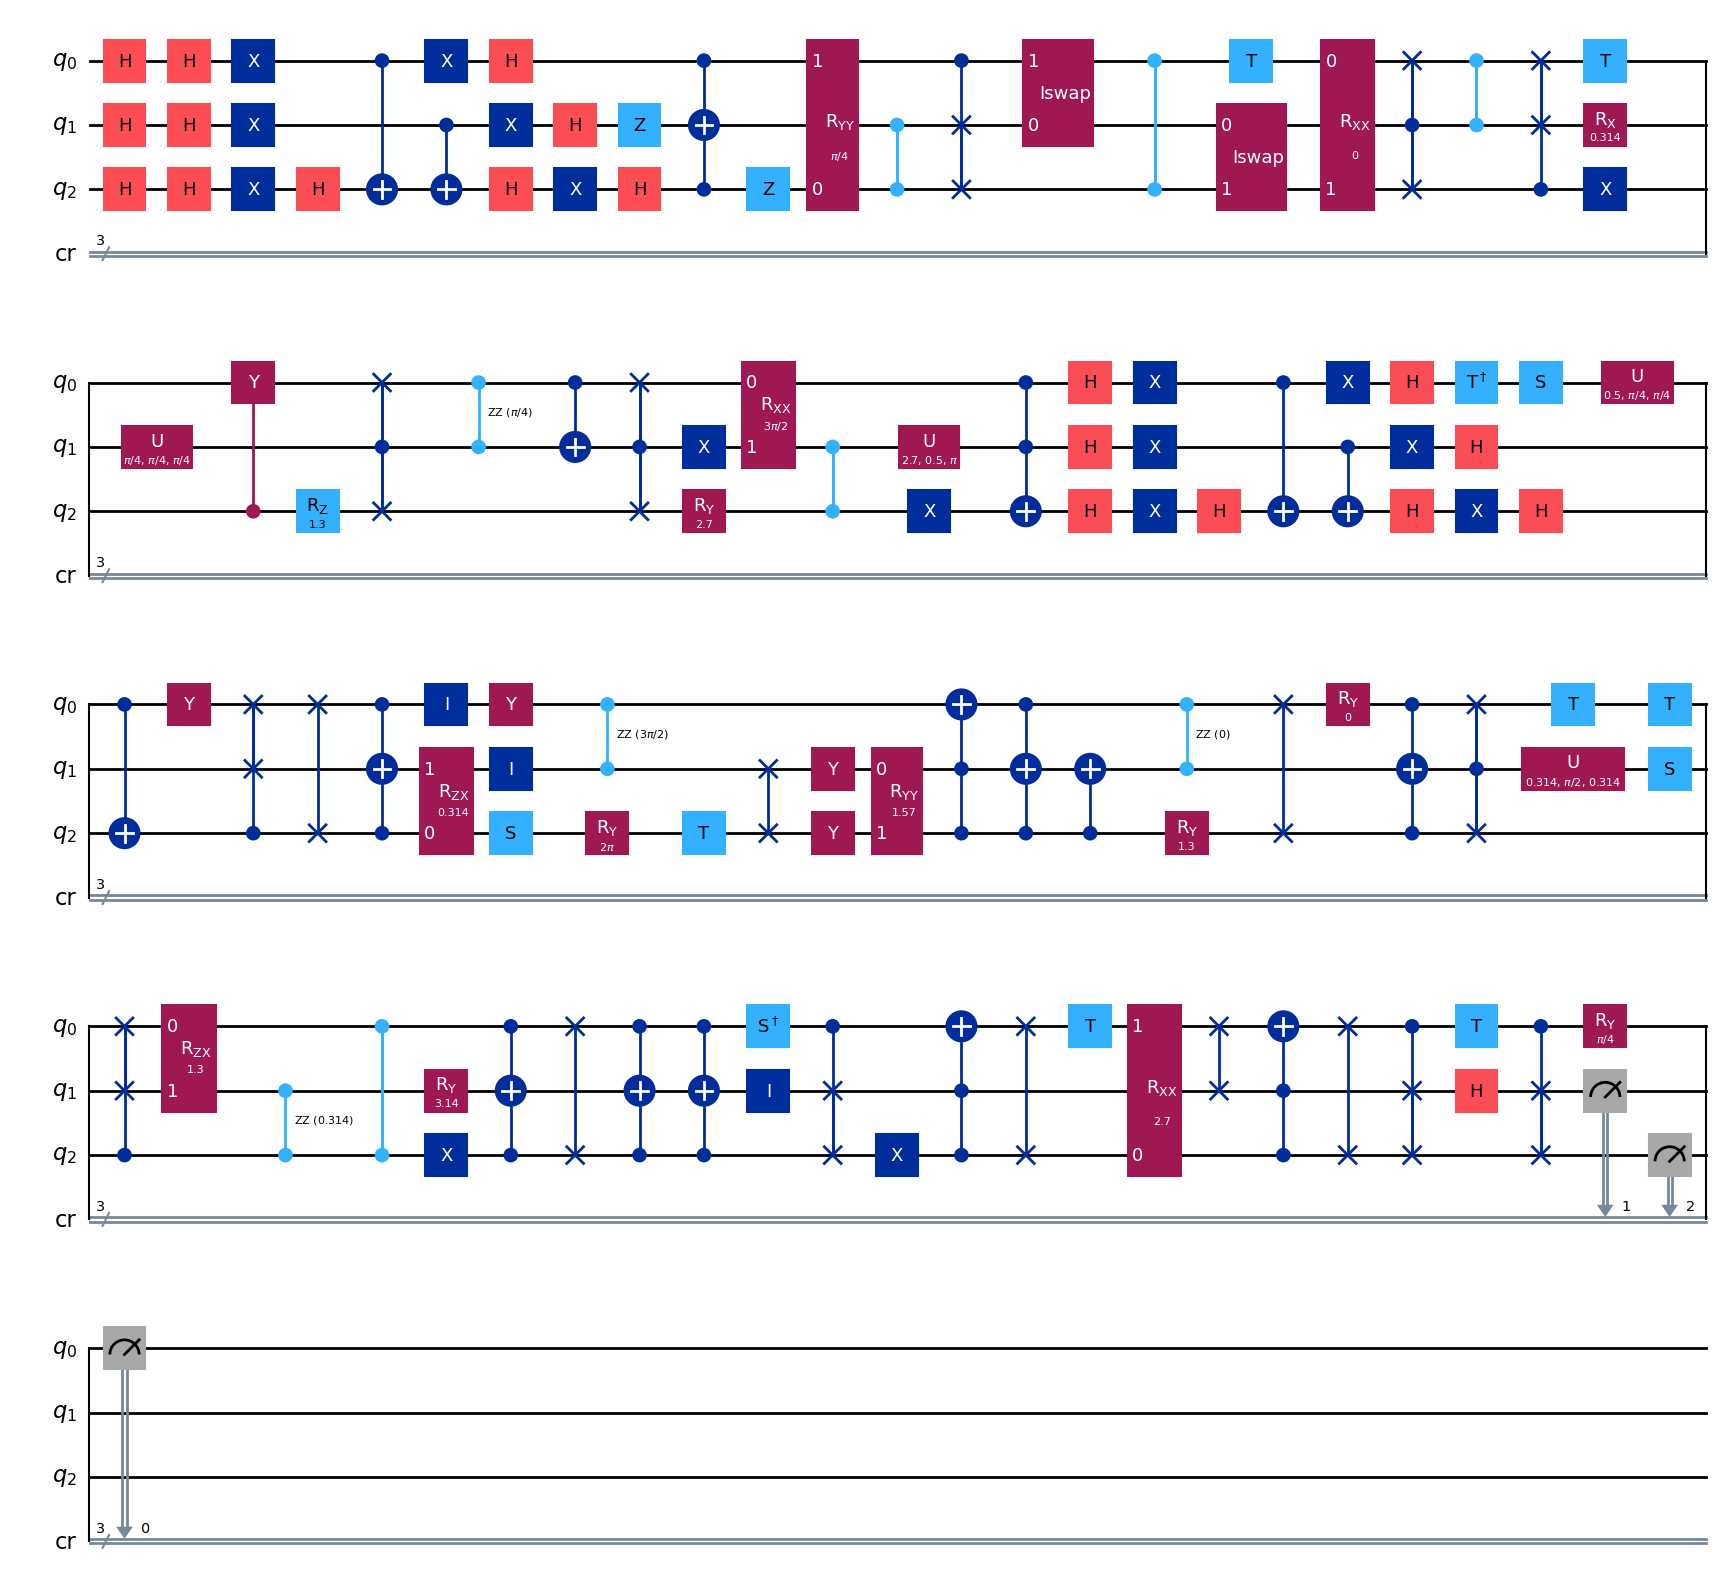

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 4

[Generation 19] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


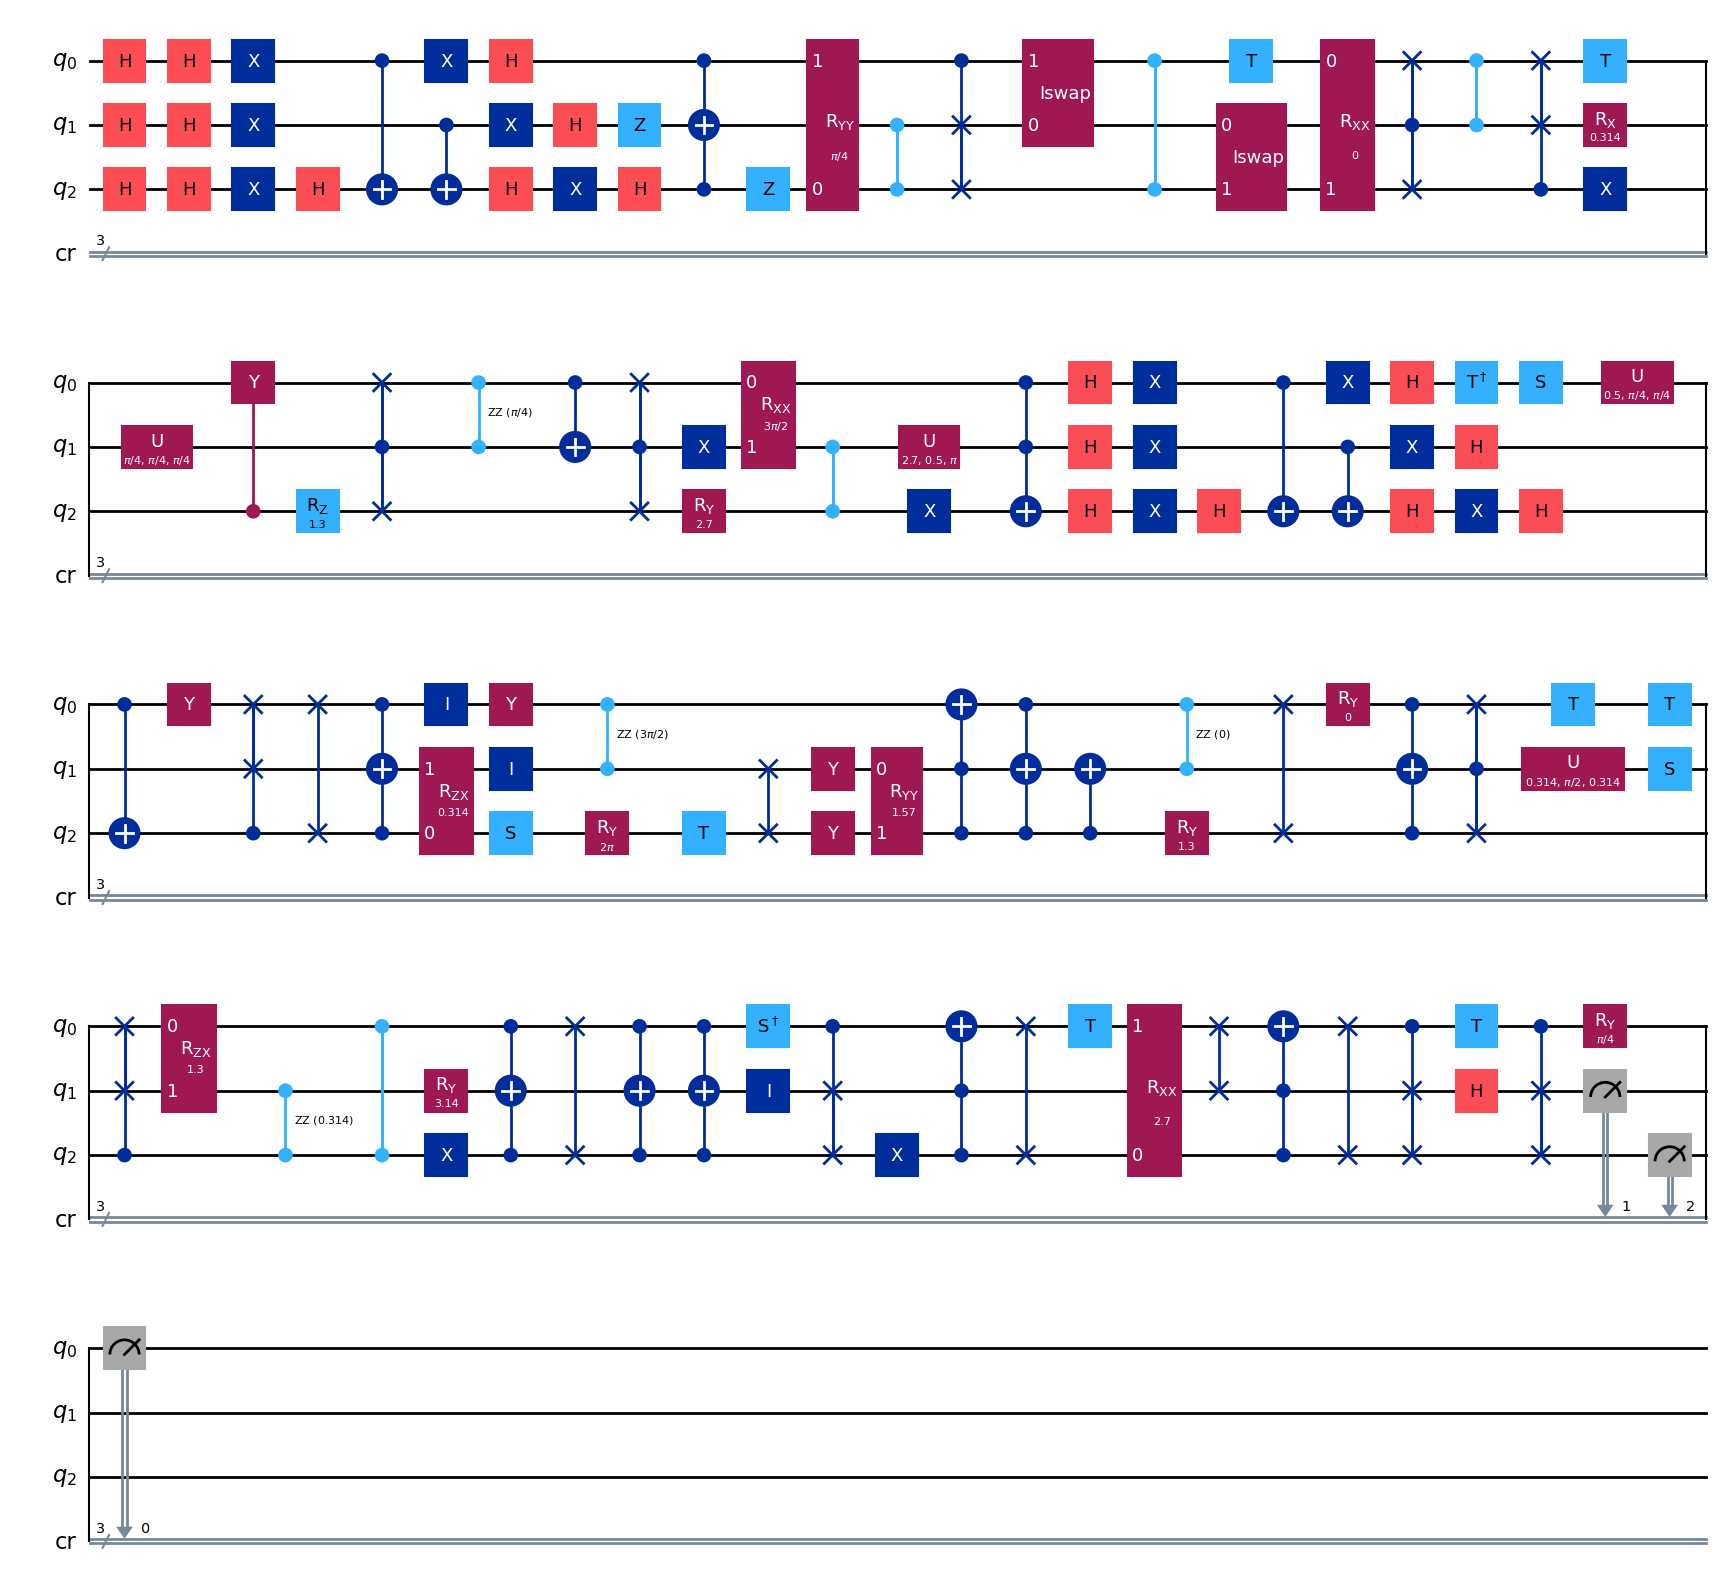

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 3

[Generation 20] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


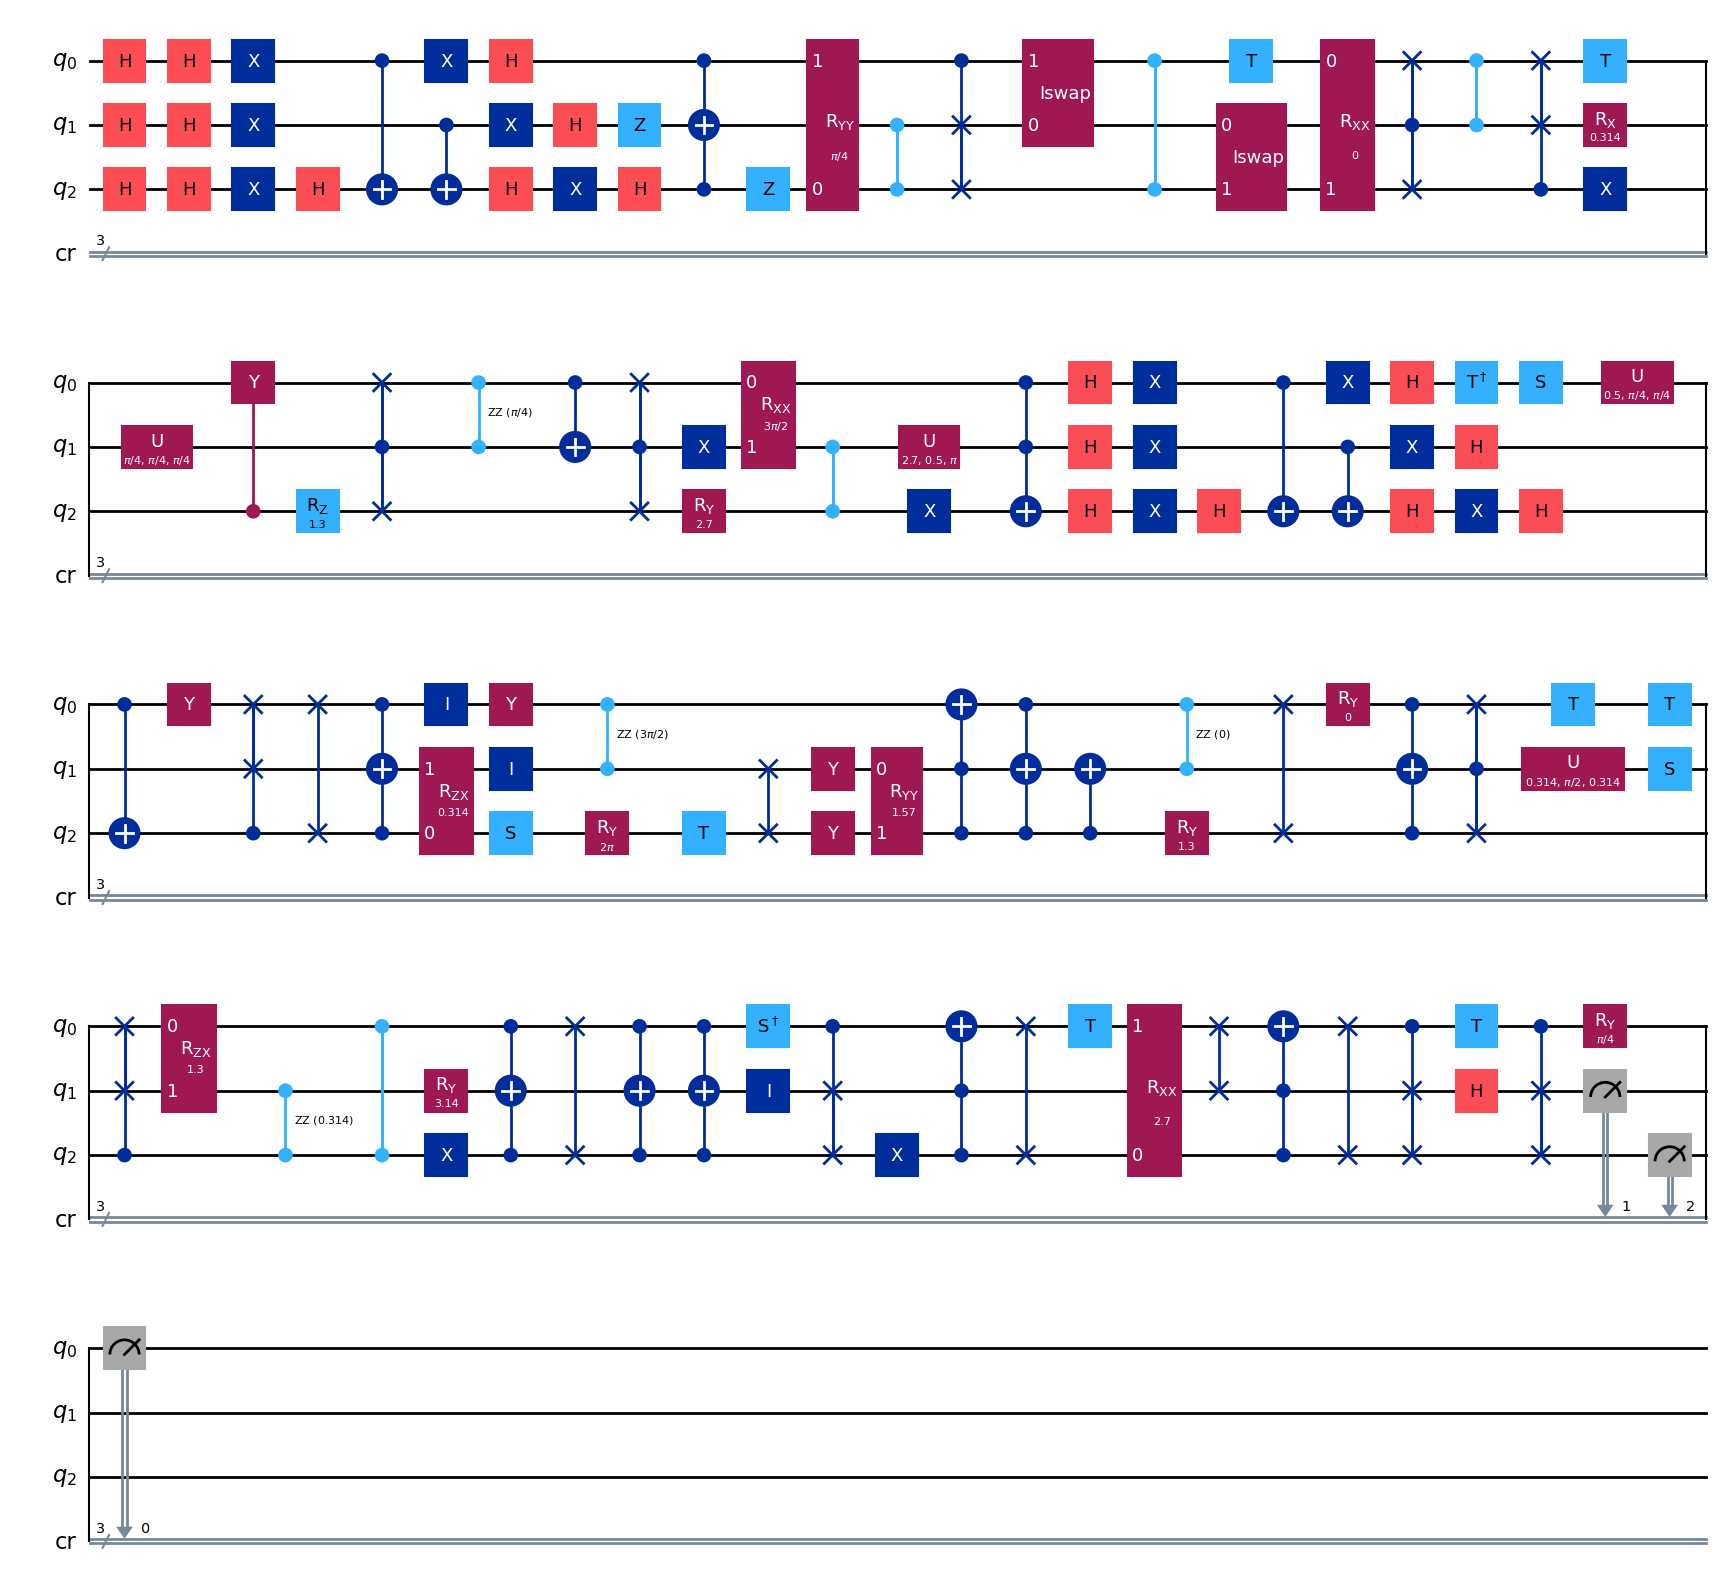

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 3

[Generation 21] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


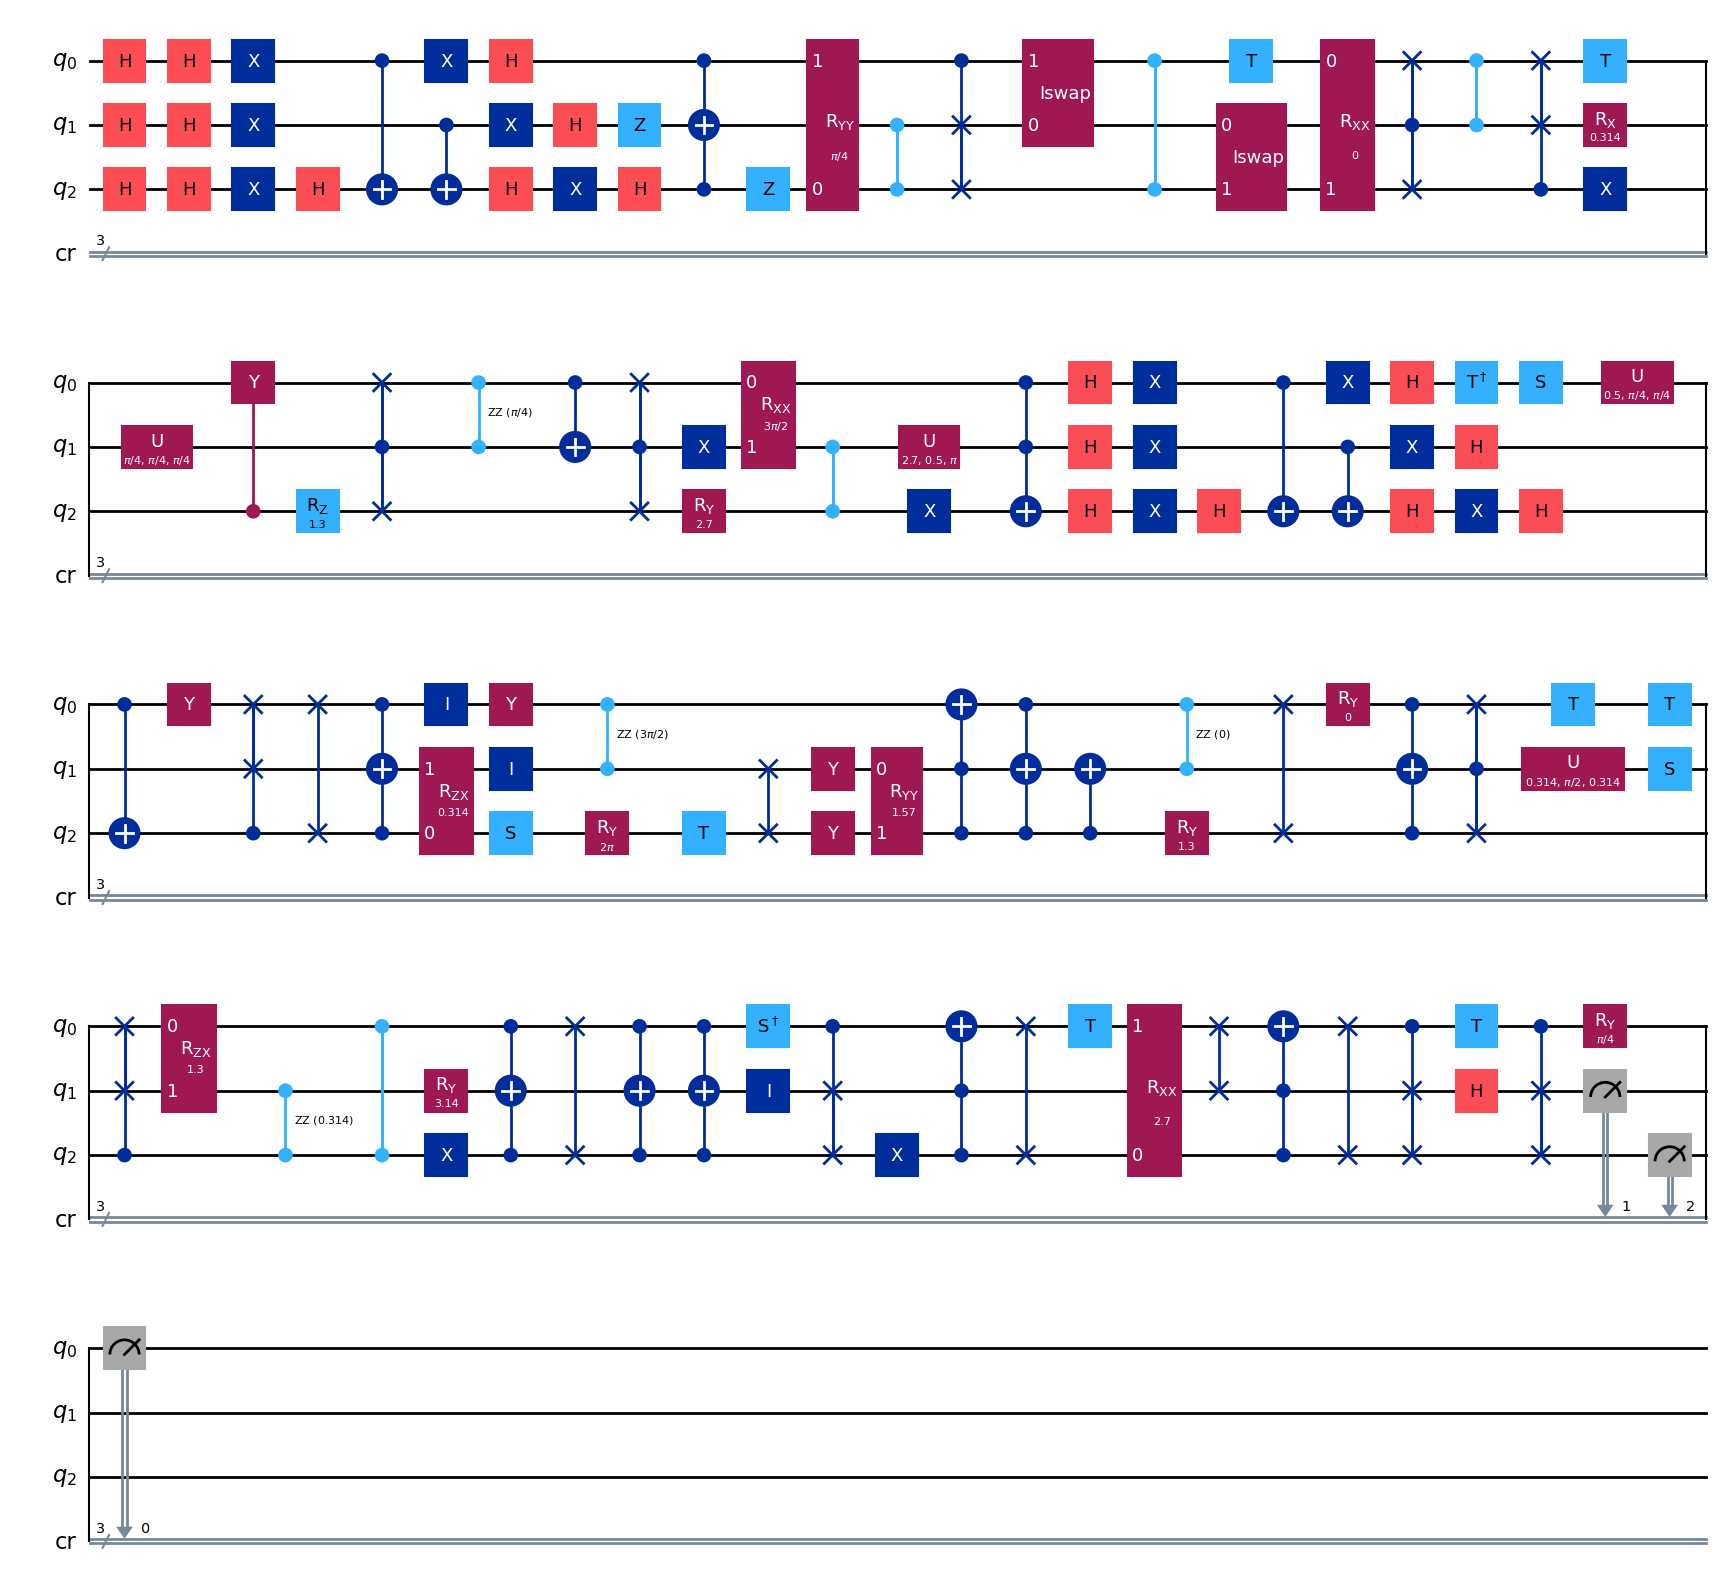

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 2

[Generation 22] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


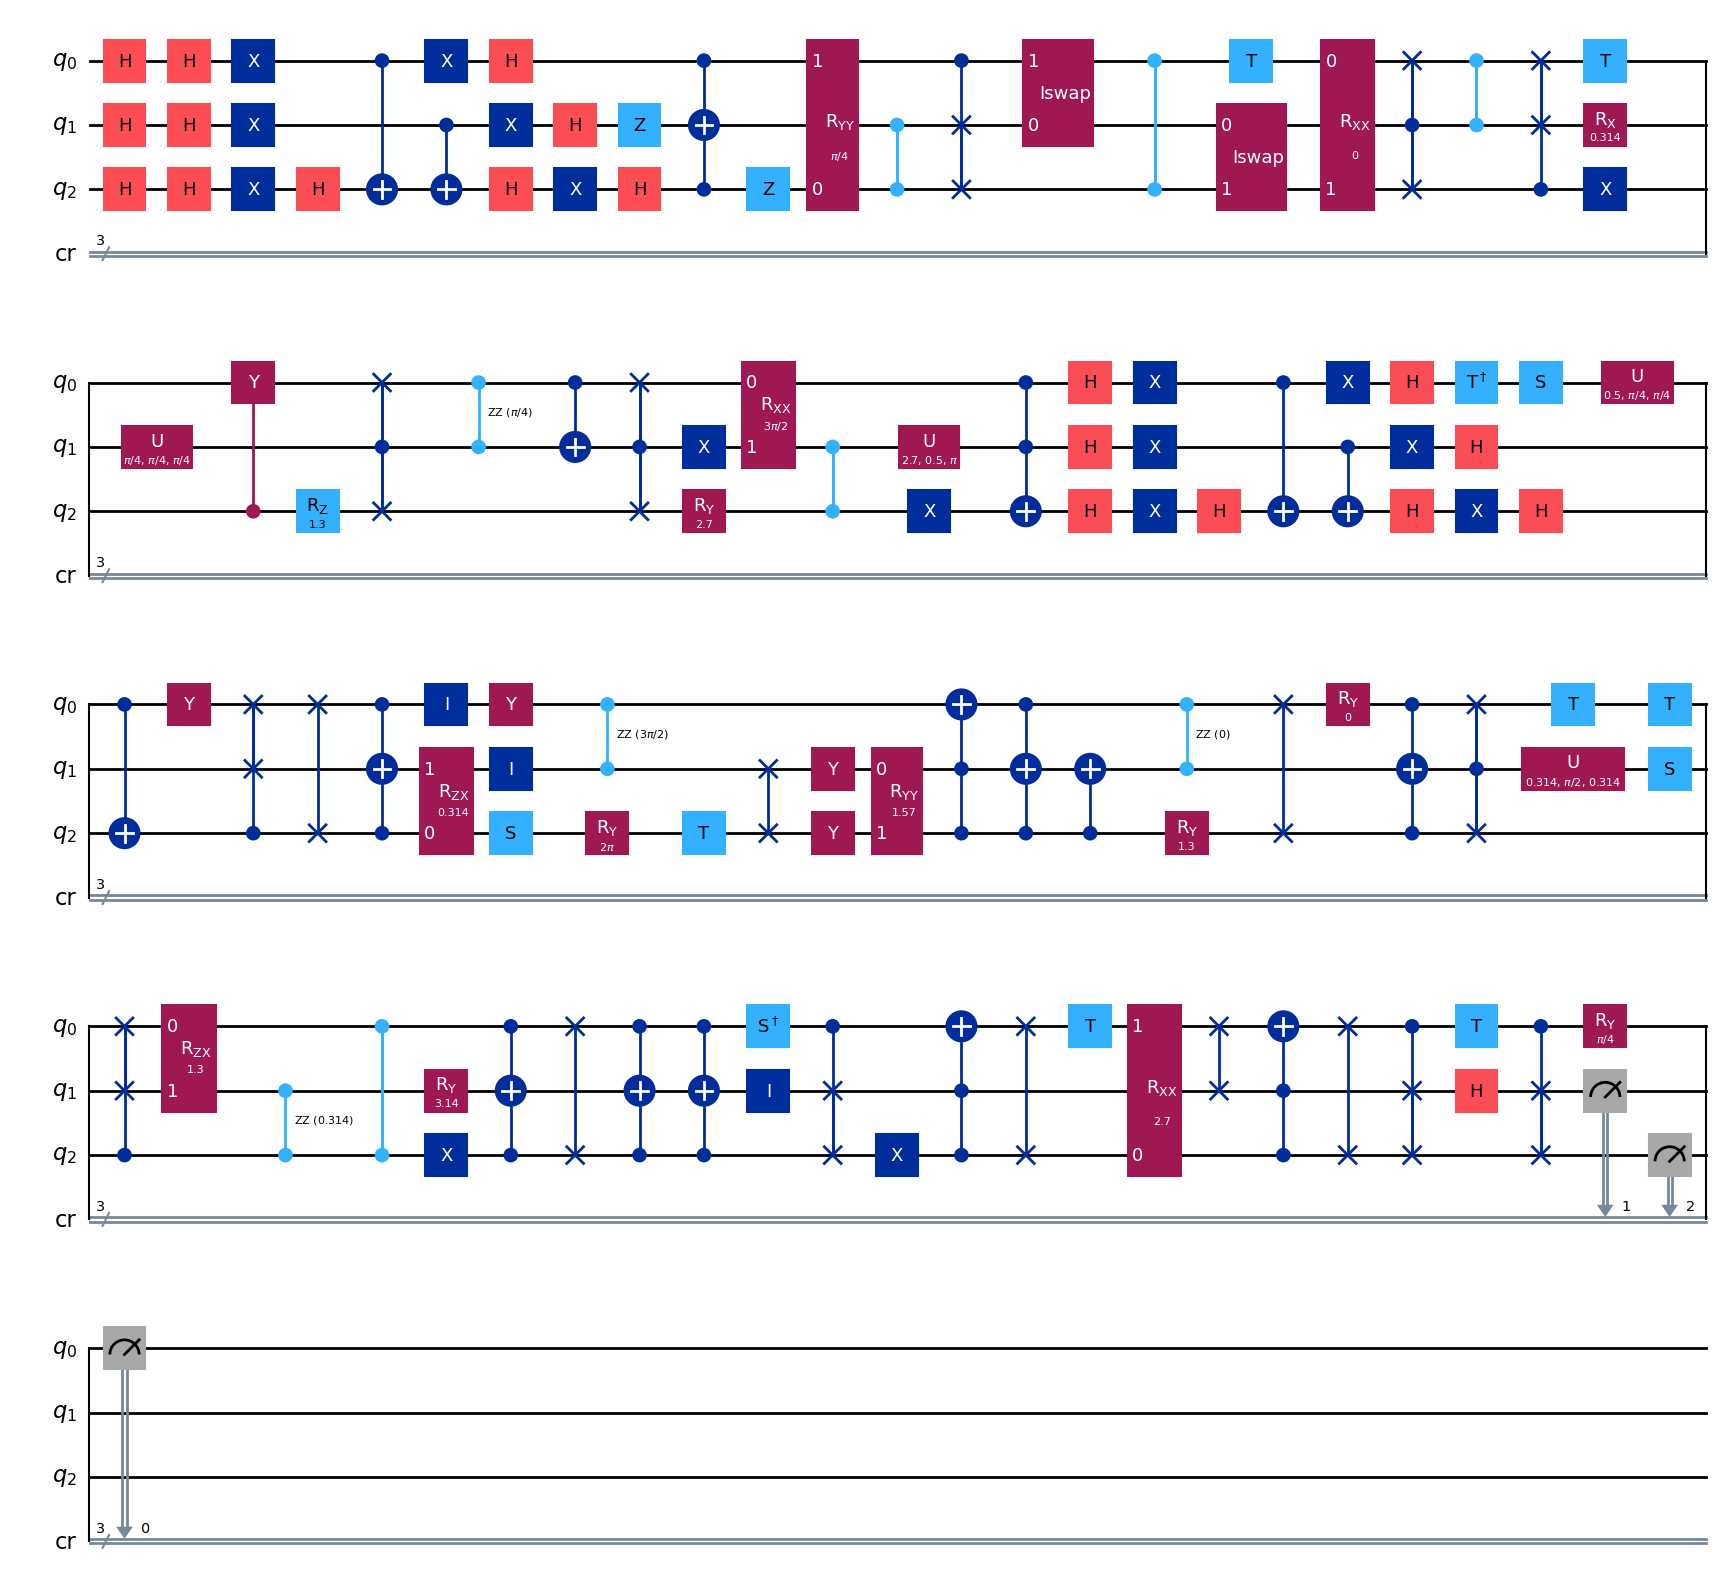

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 7

[Generation 23] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


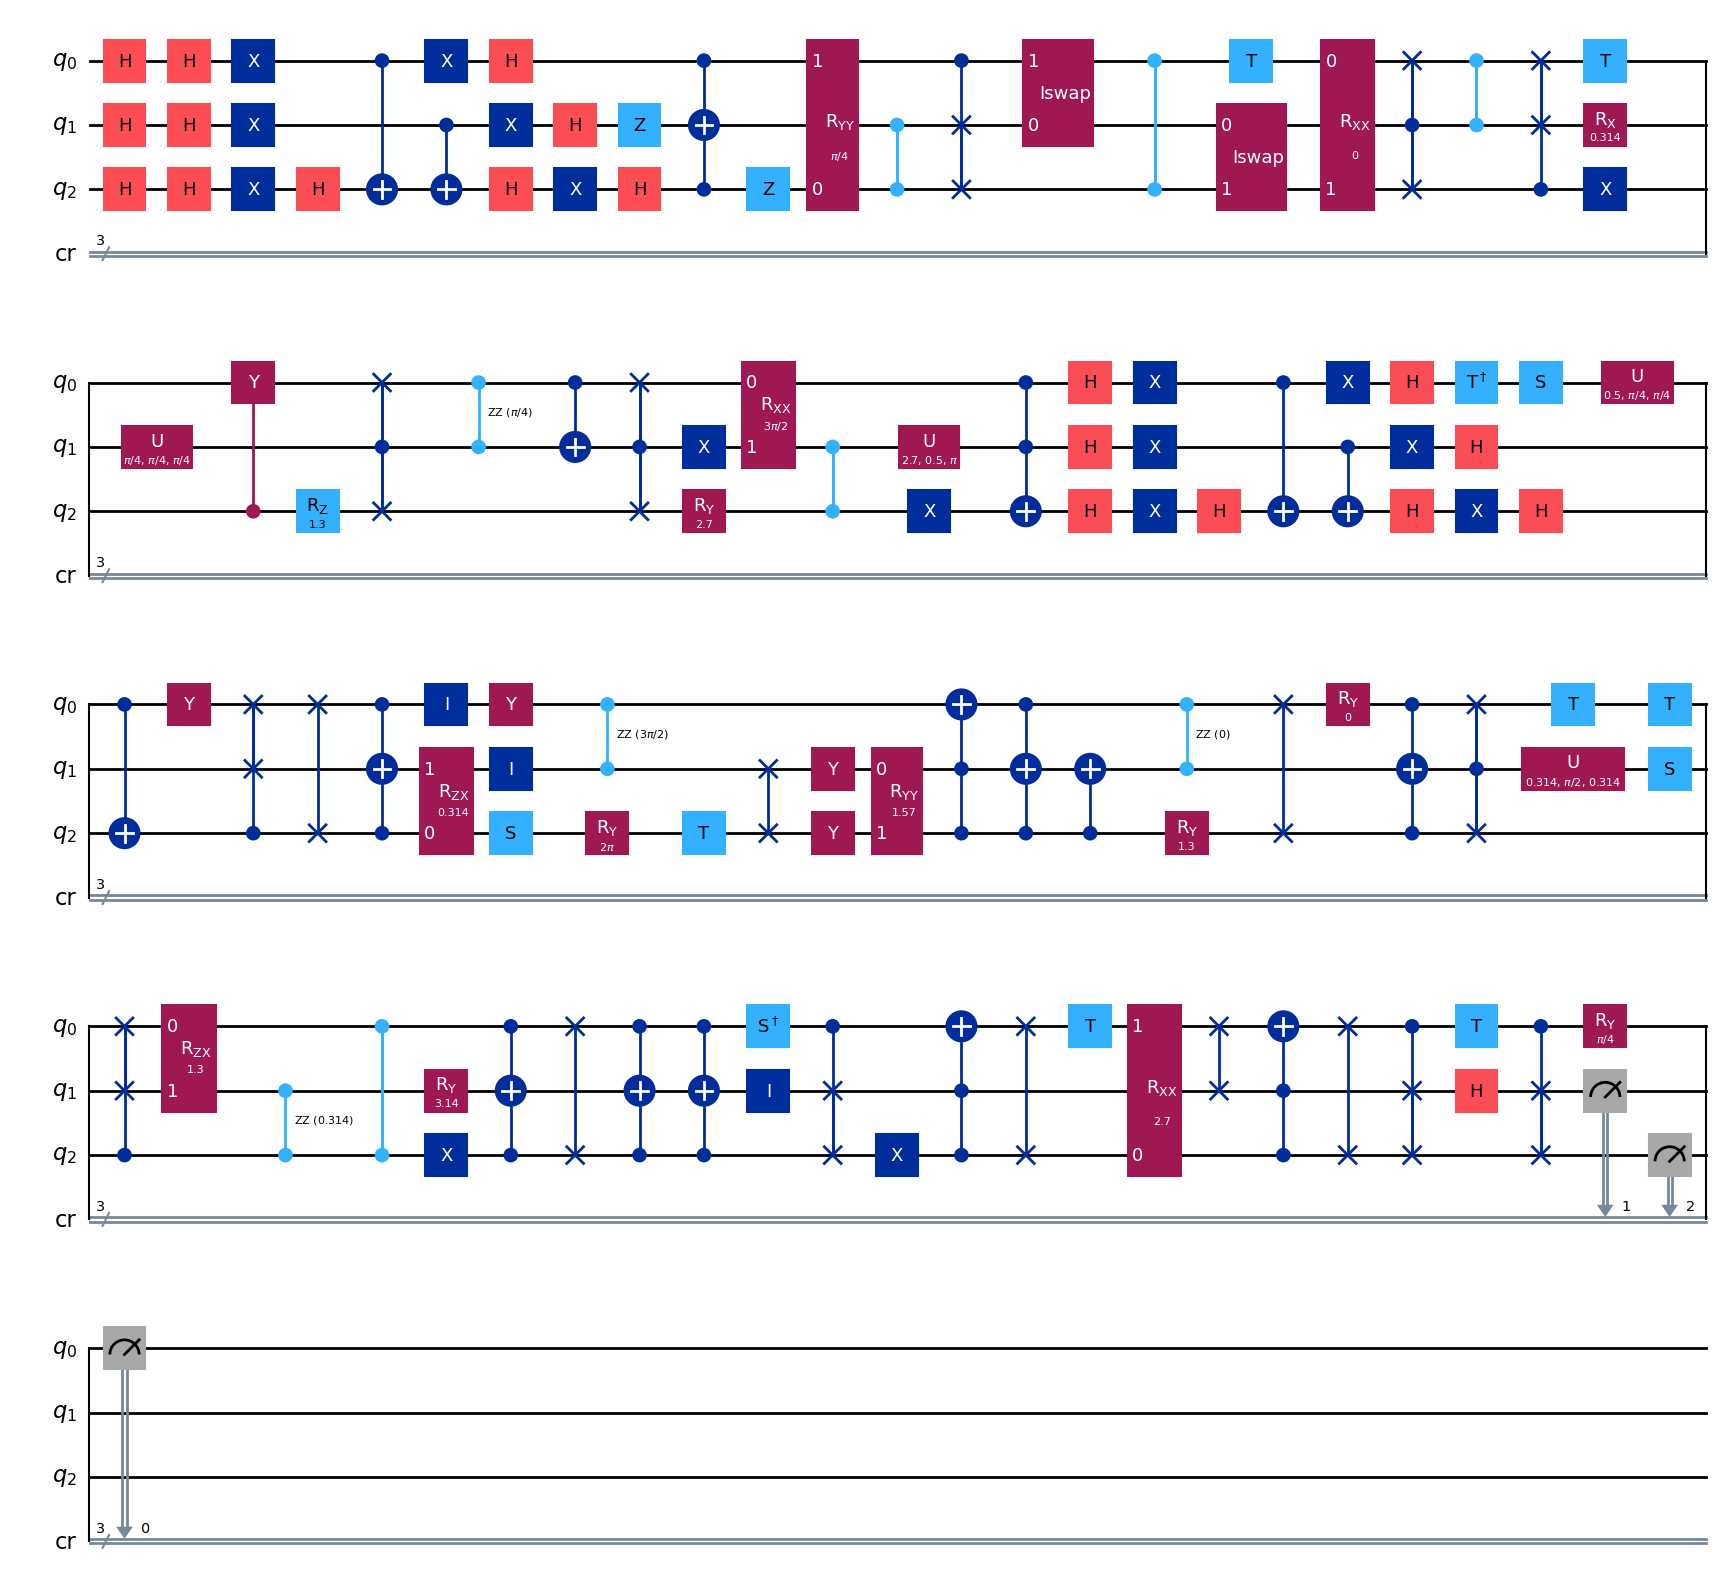

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 3

[Generation 24] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


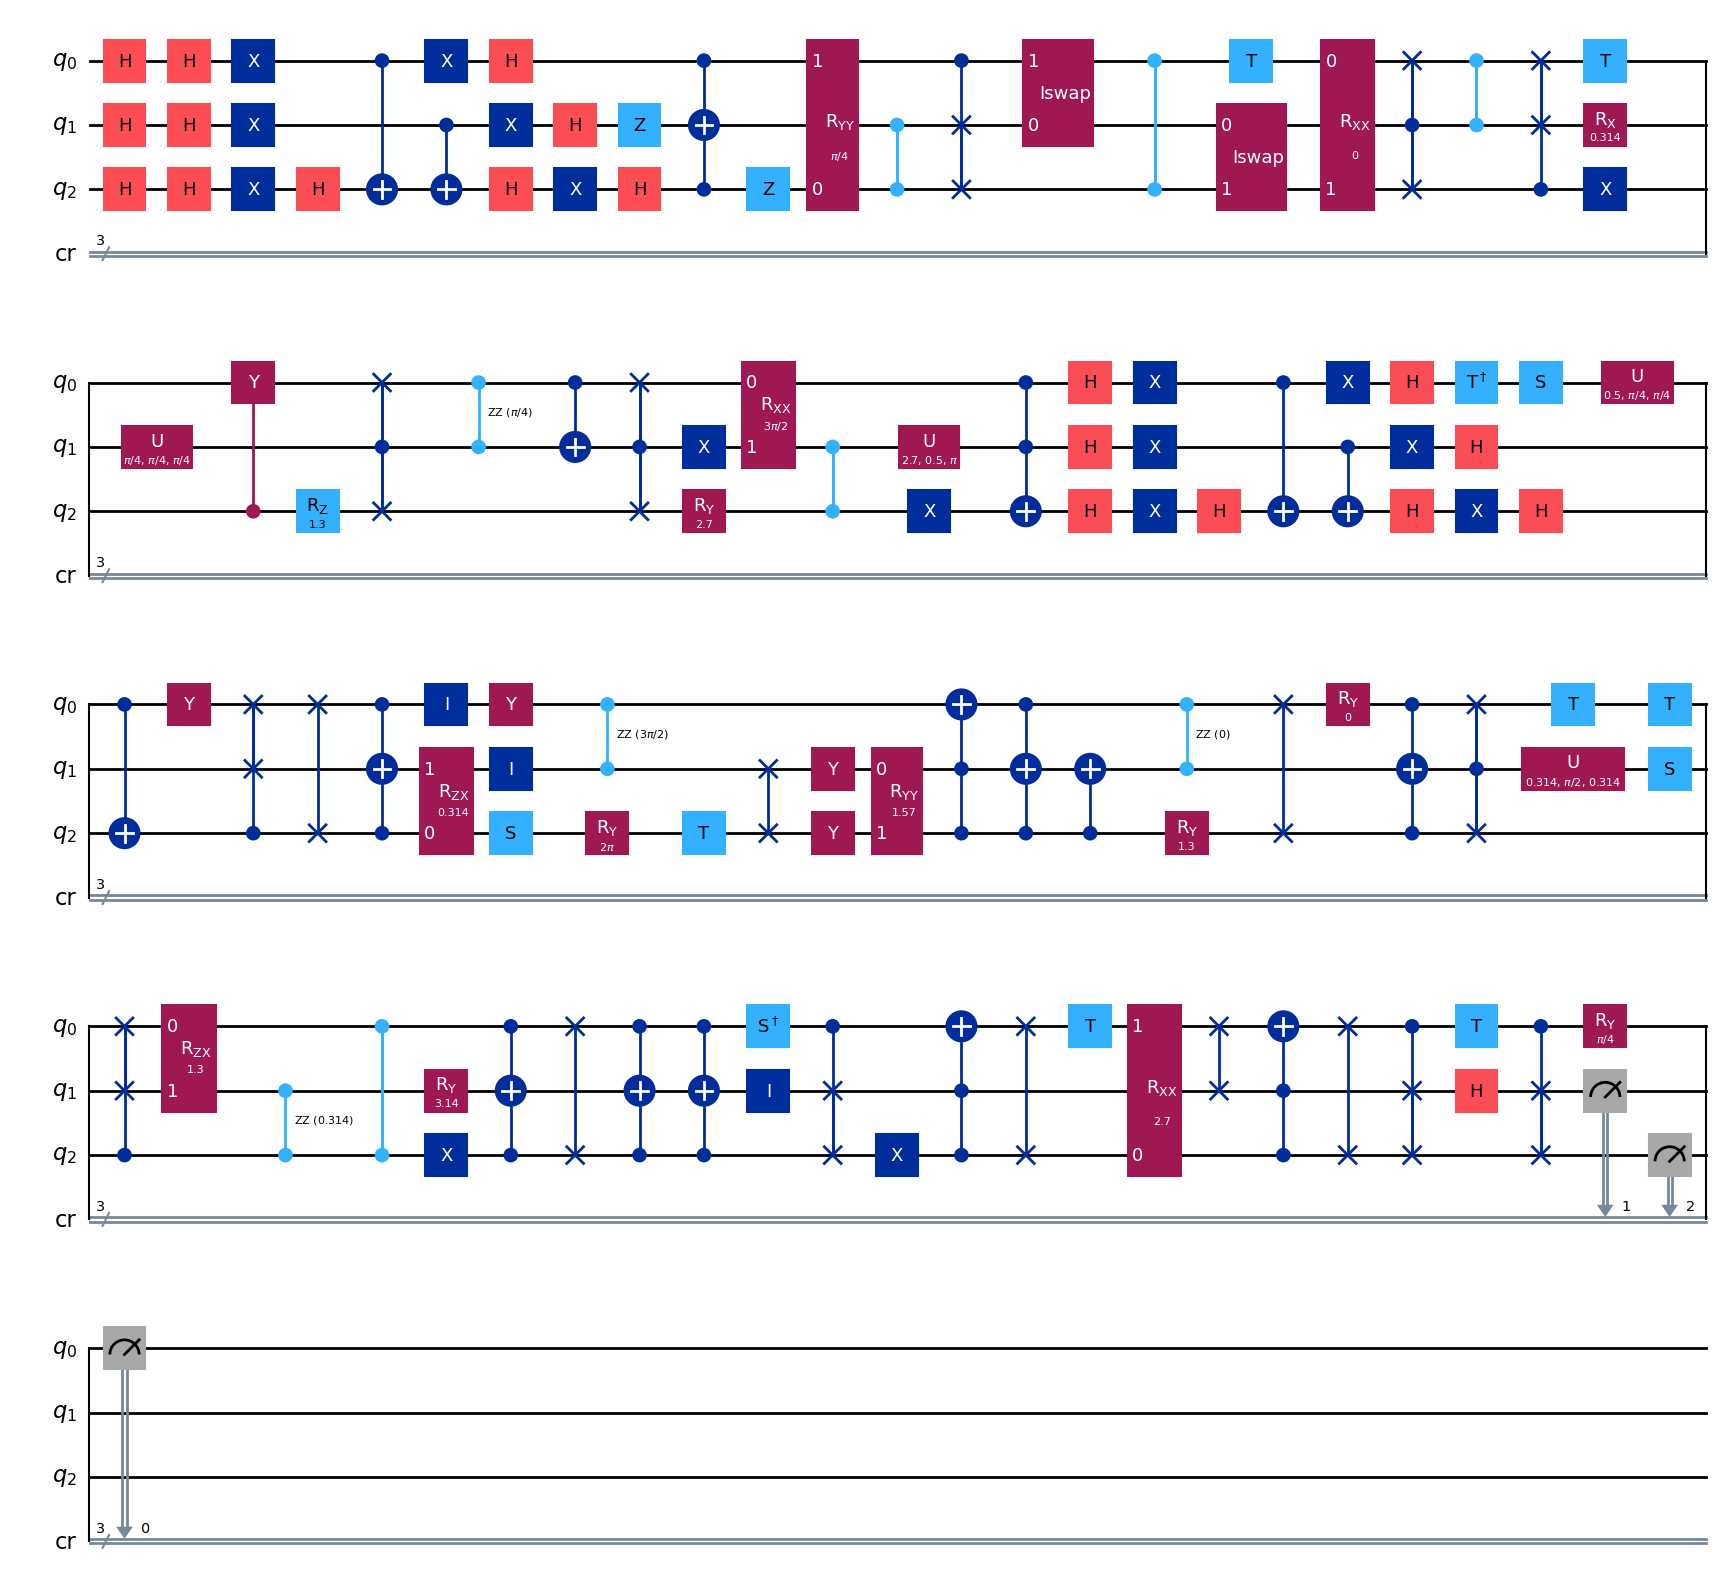

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 10

[Generation 25] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


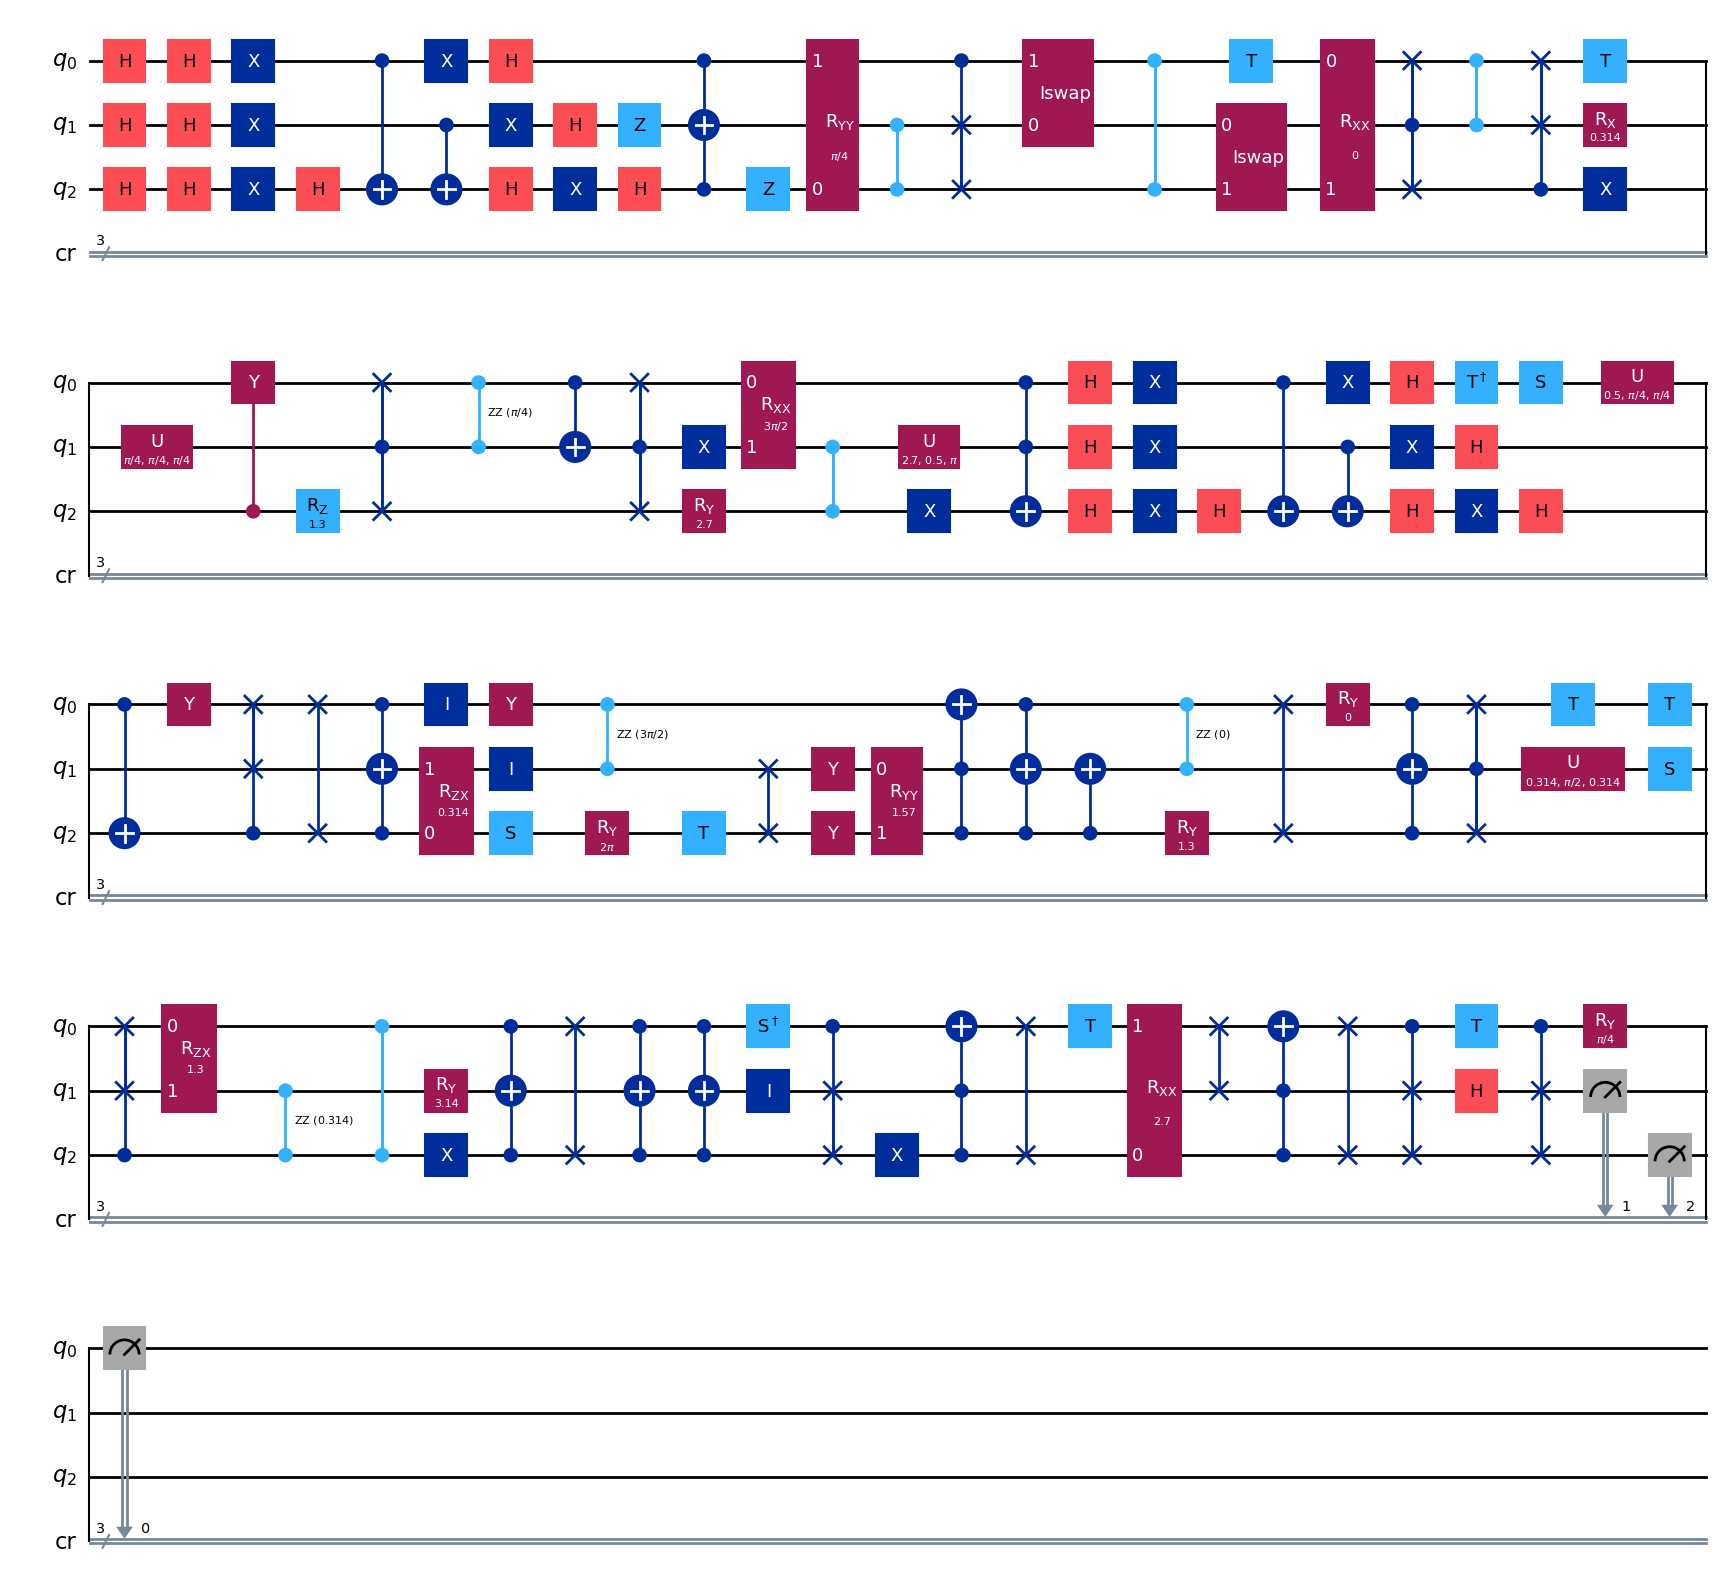

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 9

[Generation 26] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


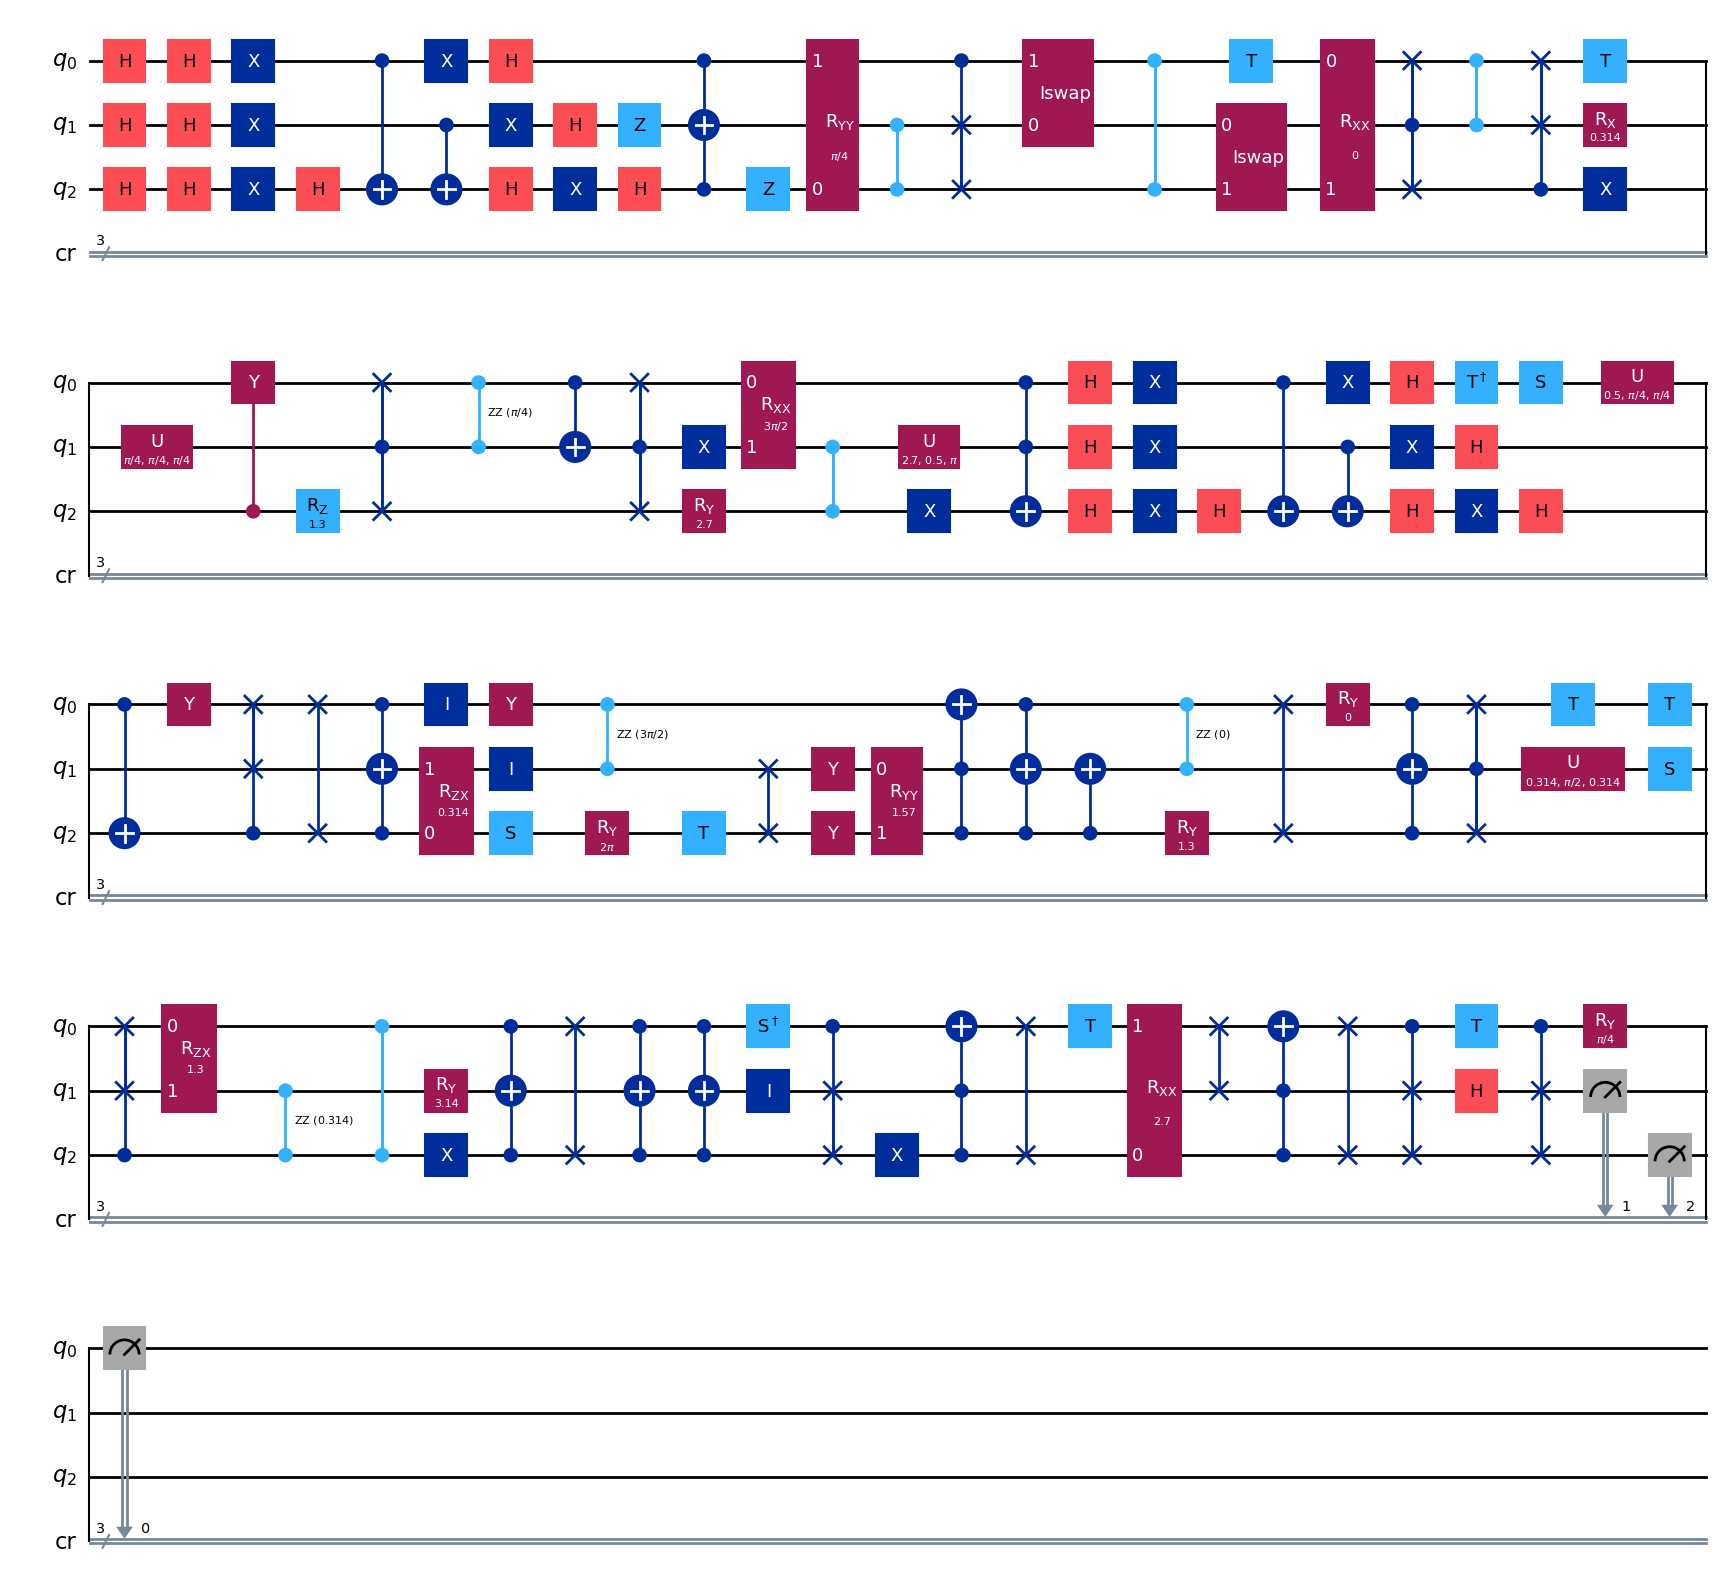

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 10

[Generation 27] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


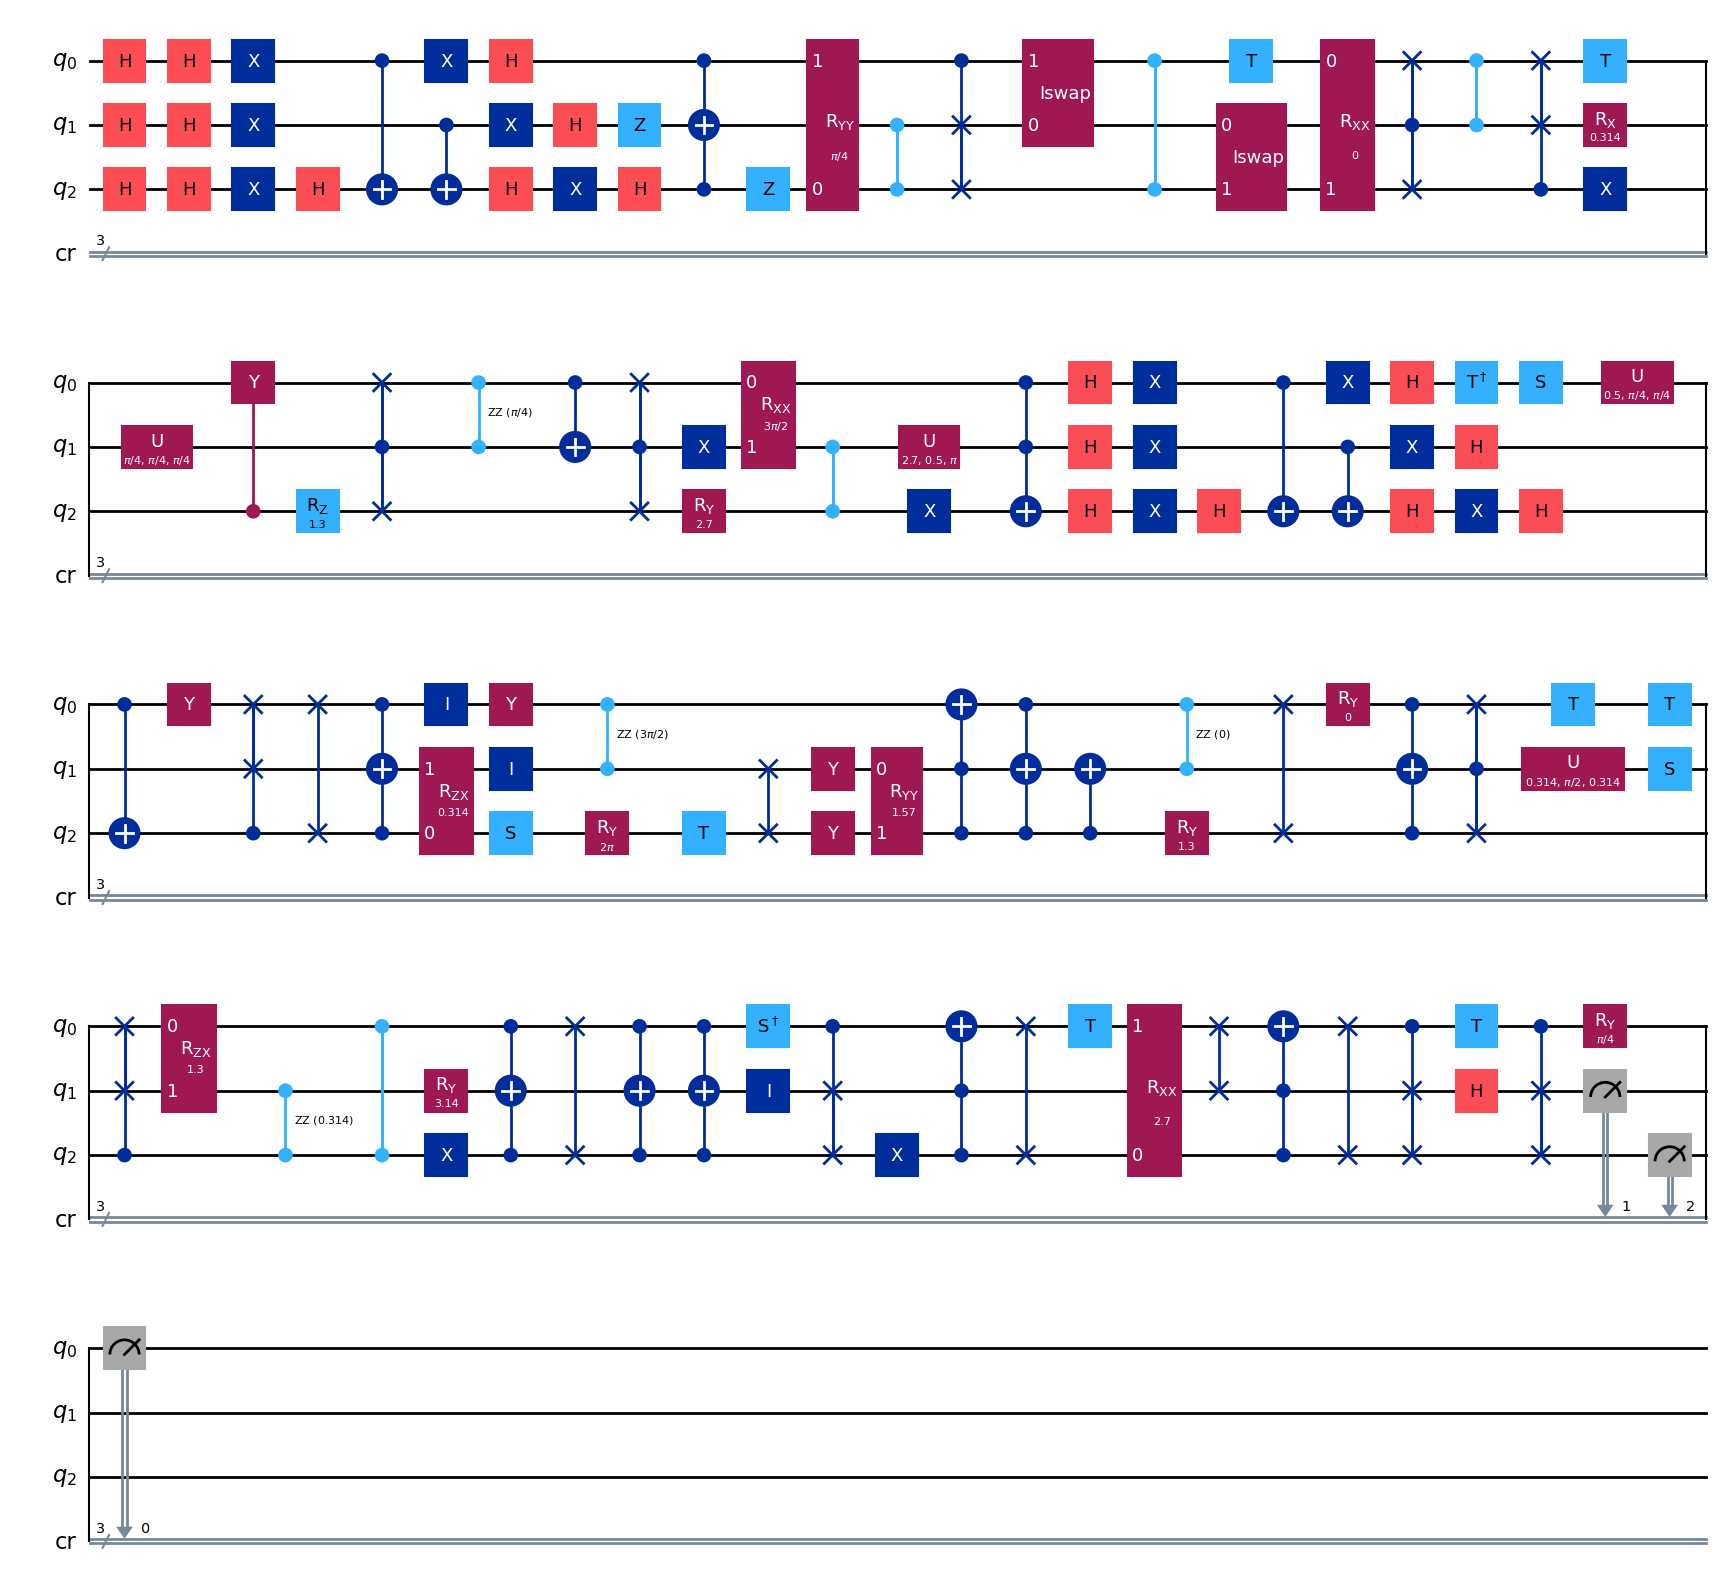

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 8

[Generation 28] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


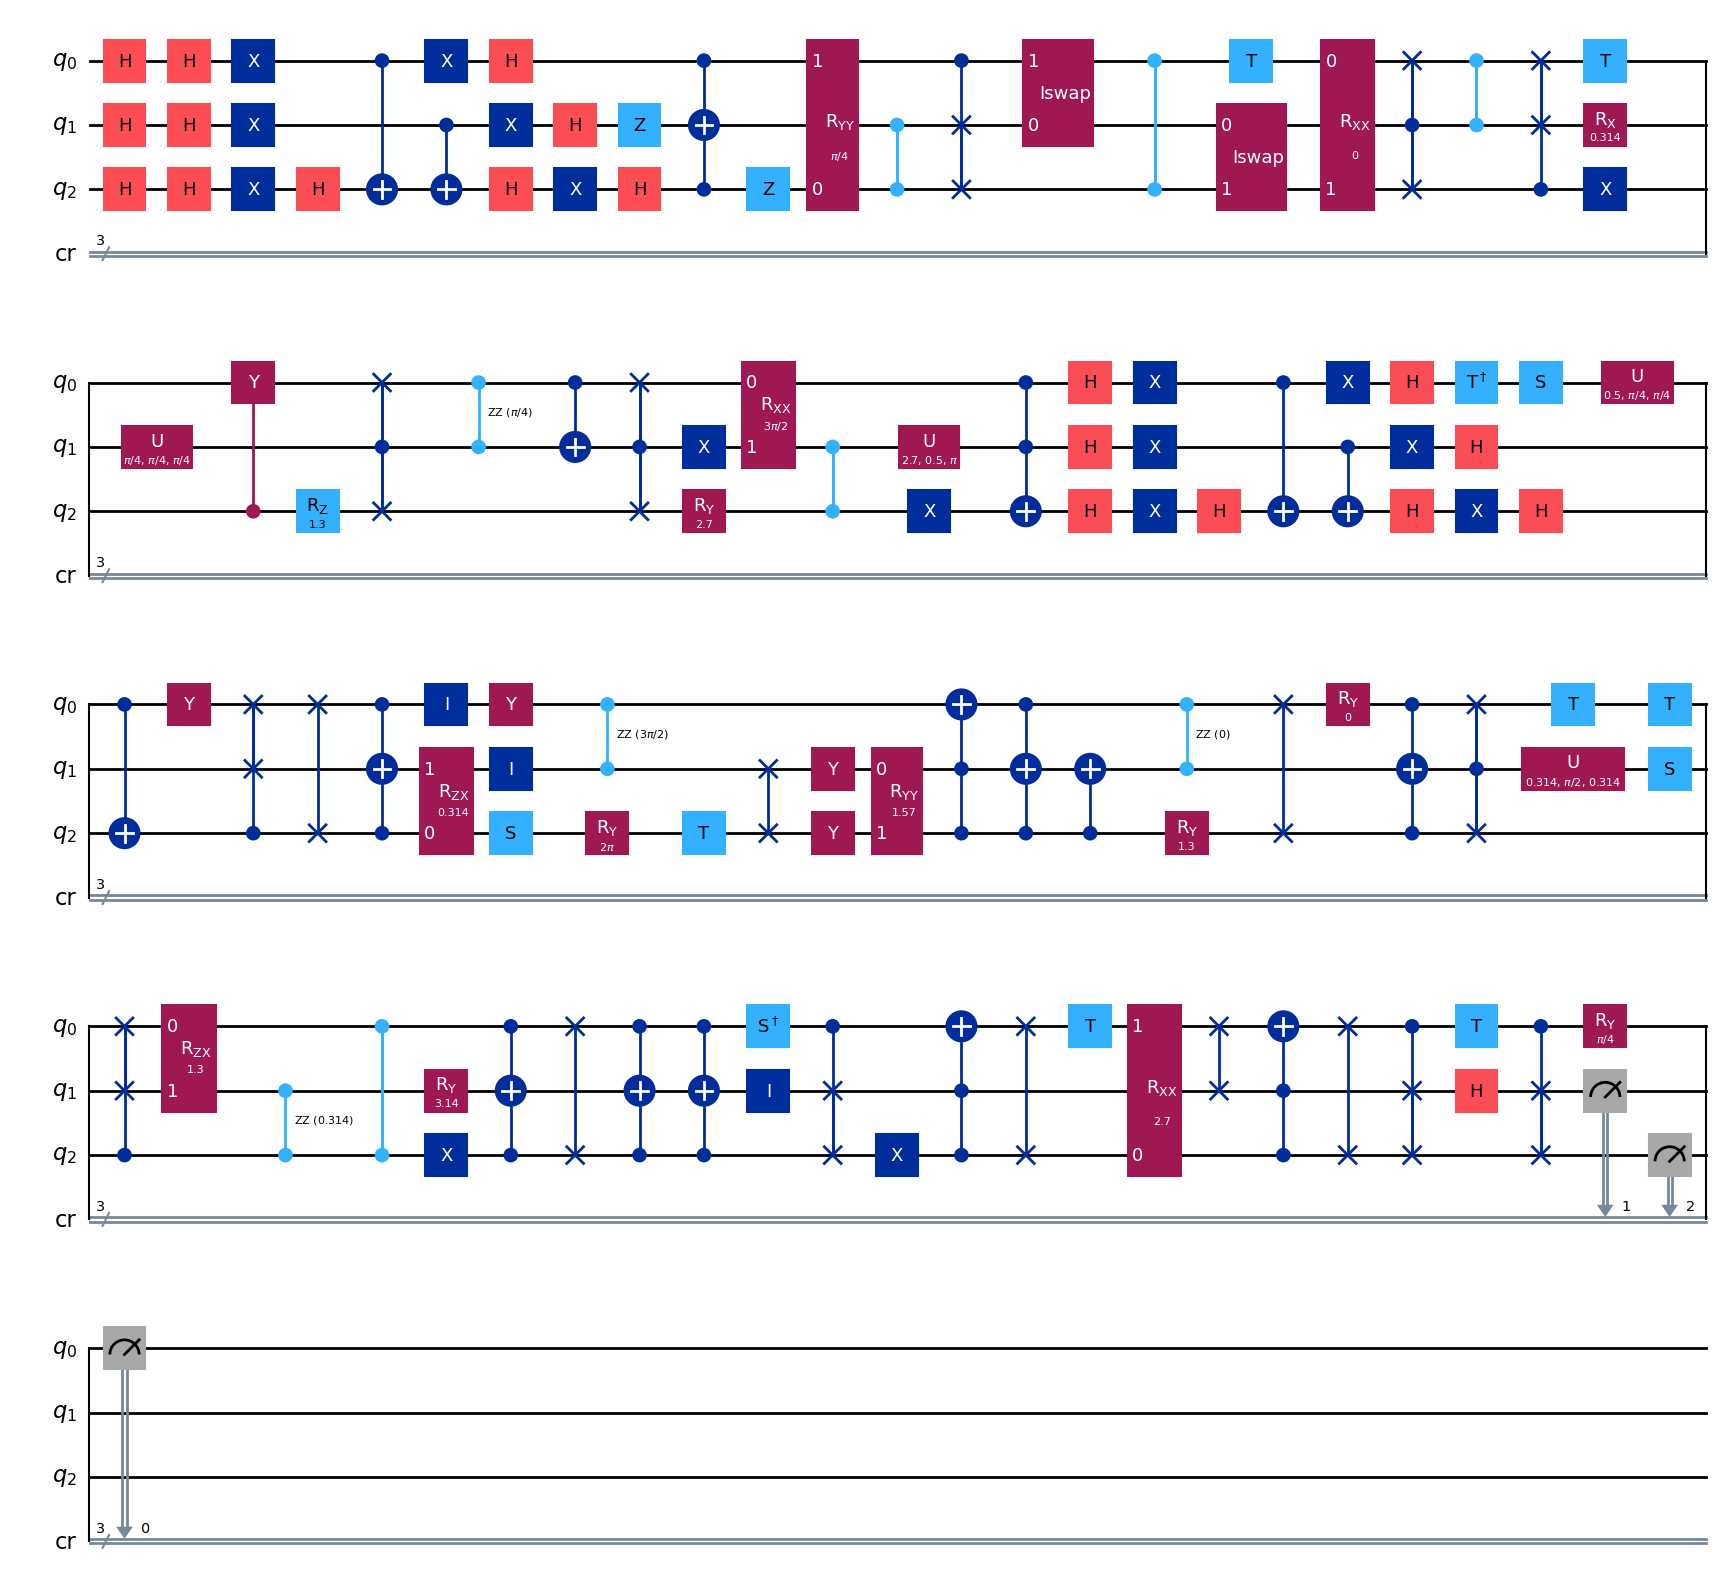

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (2.717421875,) , Number of invalids = 14

[Generation 29] Best Fitness: 2.7174


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


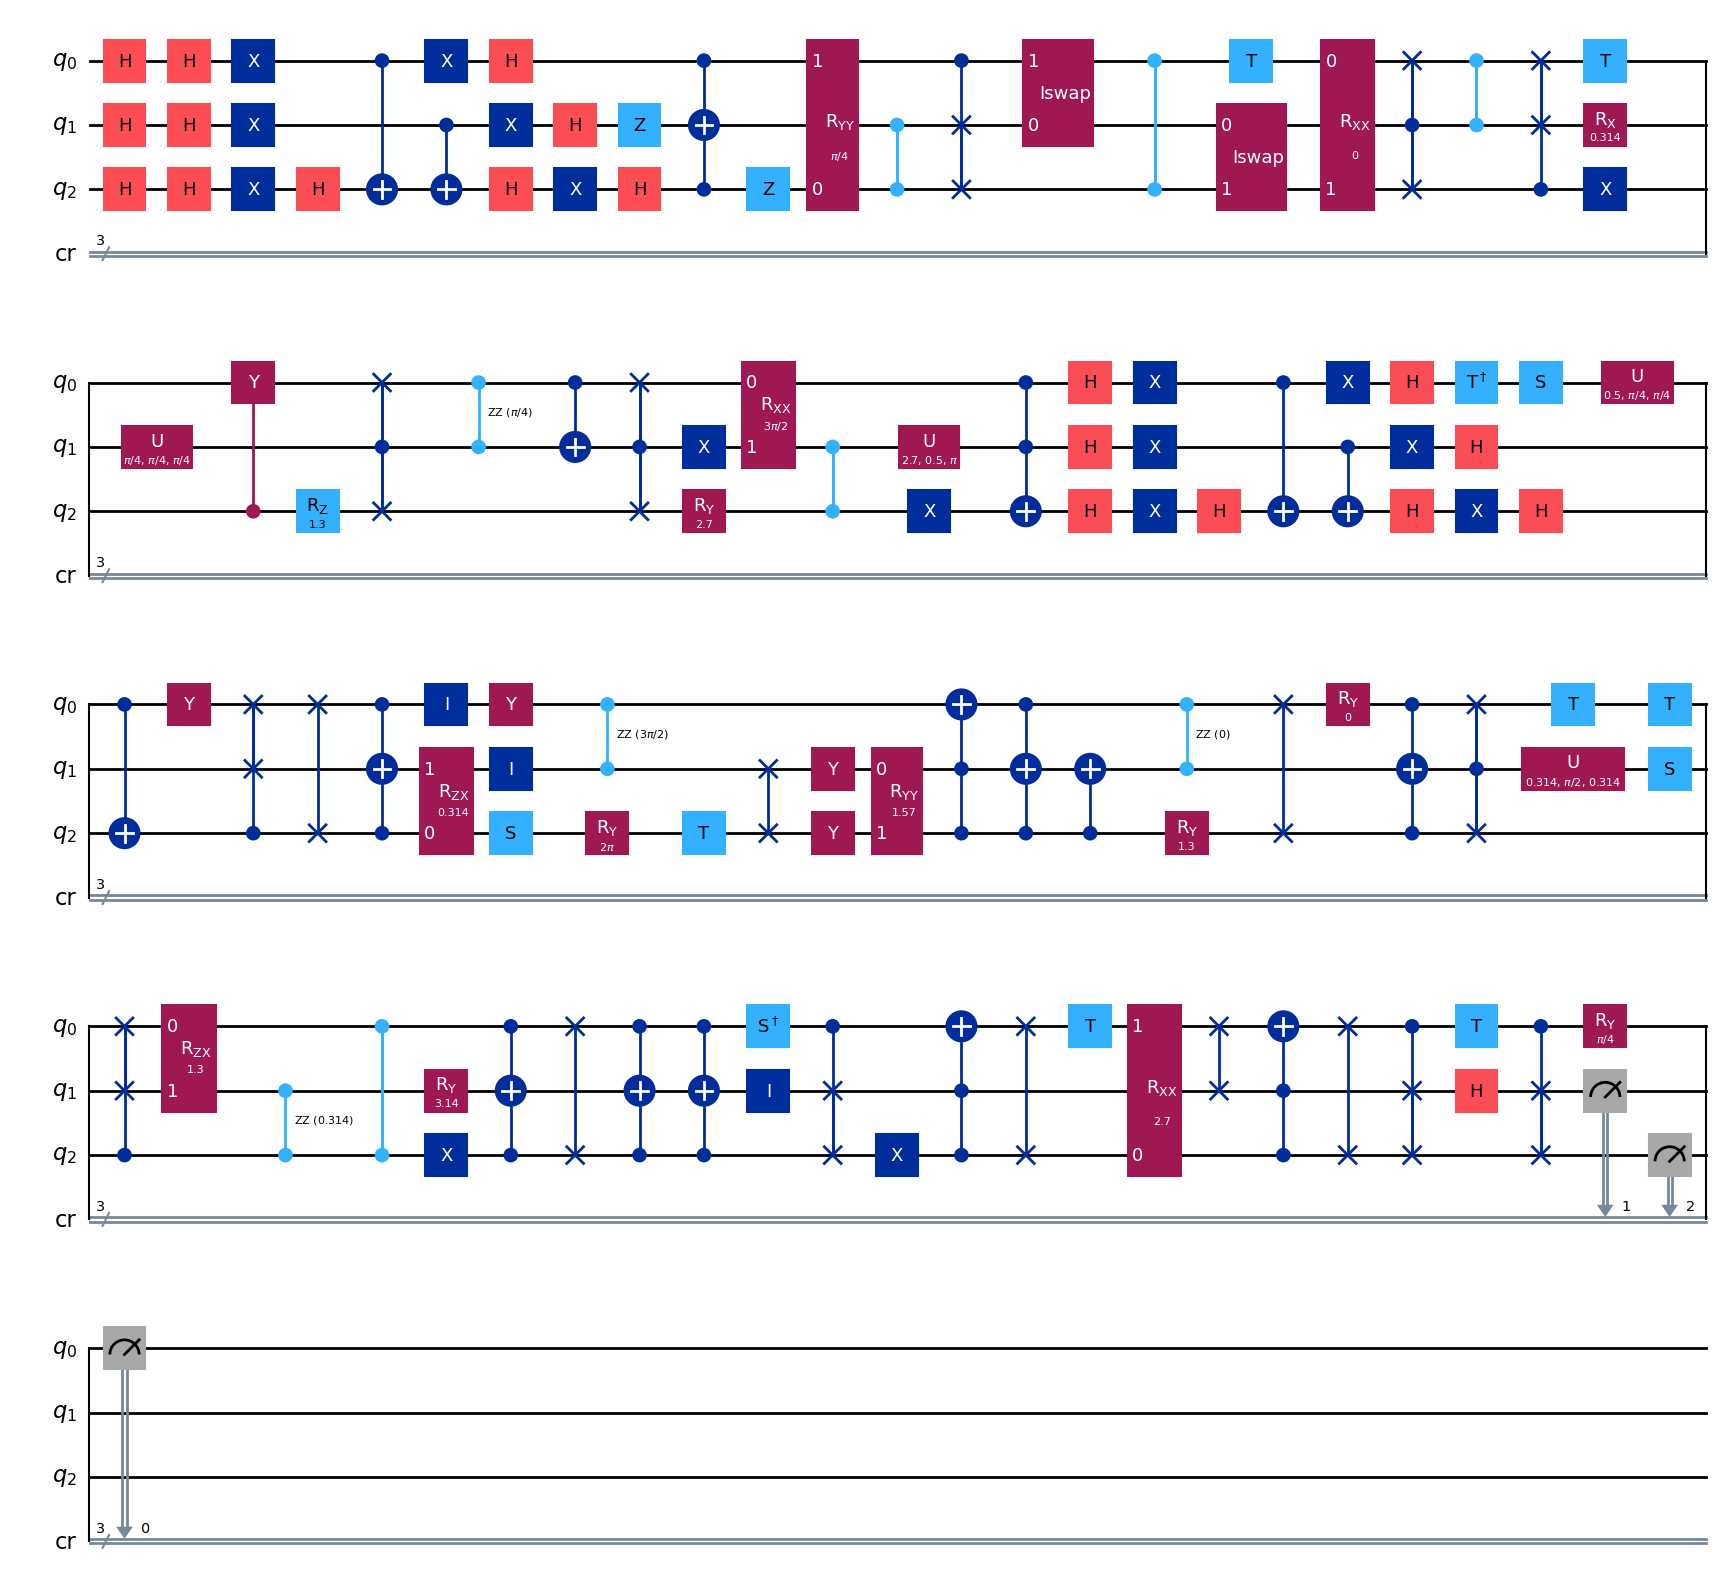

gen = 0 , Best fitness = (2.717421875,)
gen = 1 , Best fitness = (1.518515625,) , Number of invalids = 13

[Generation 30] Best Fitness: 1.5185


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


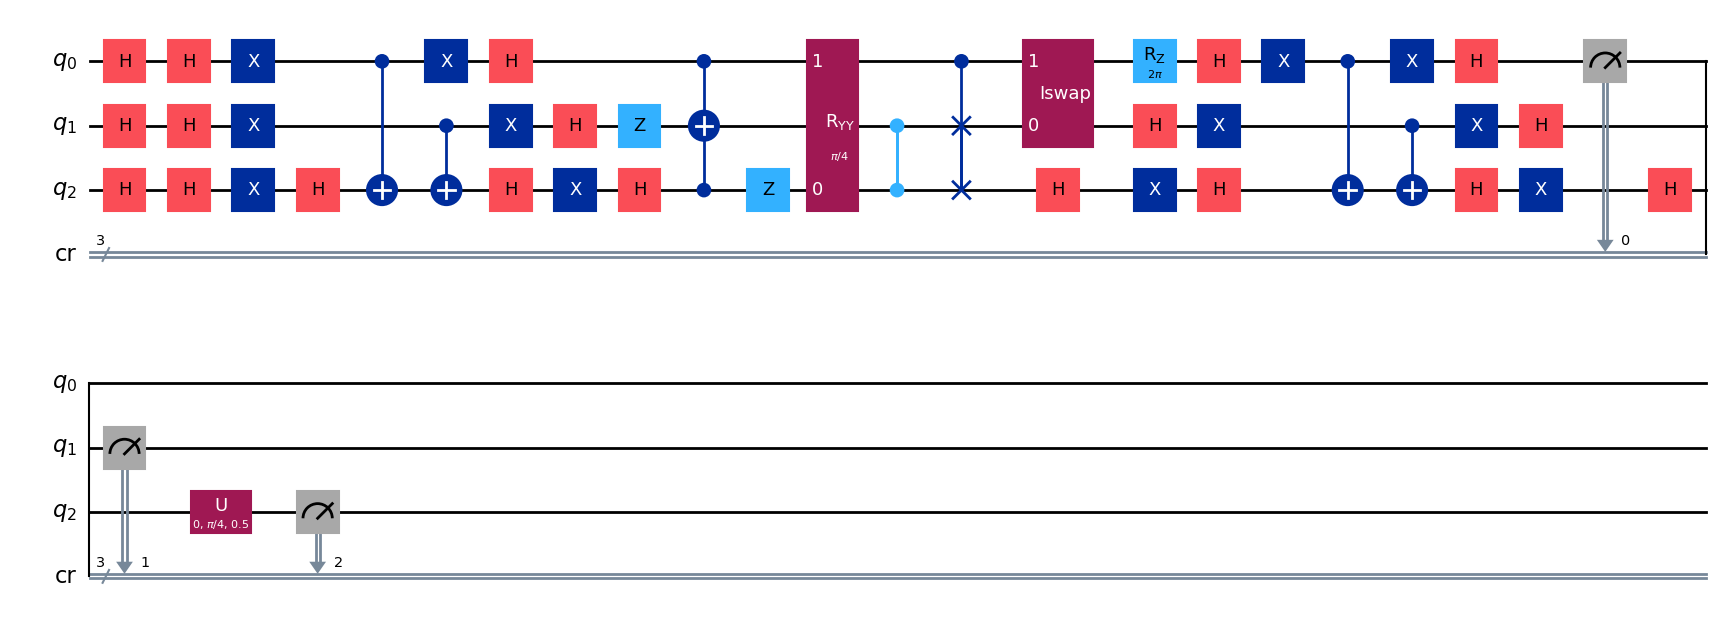

gen = 0 , Best fitness = (1.518515625,)
gen = 1 , Best fitness = (1.518515625,) , Number of invalids = 8

[Generation 31] Best Fitness: 1.5185


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


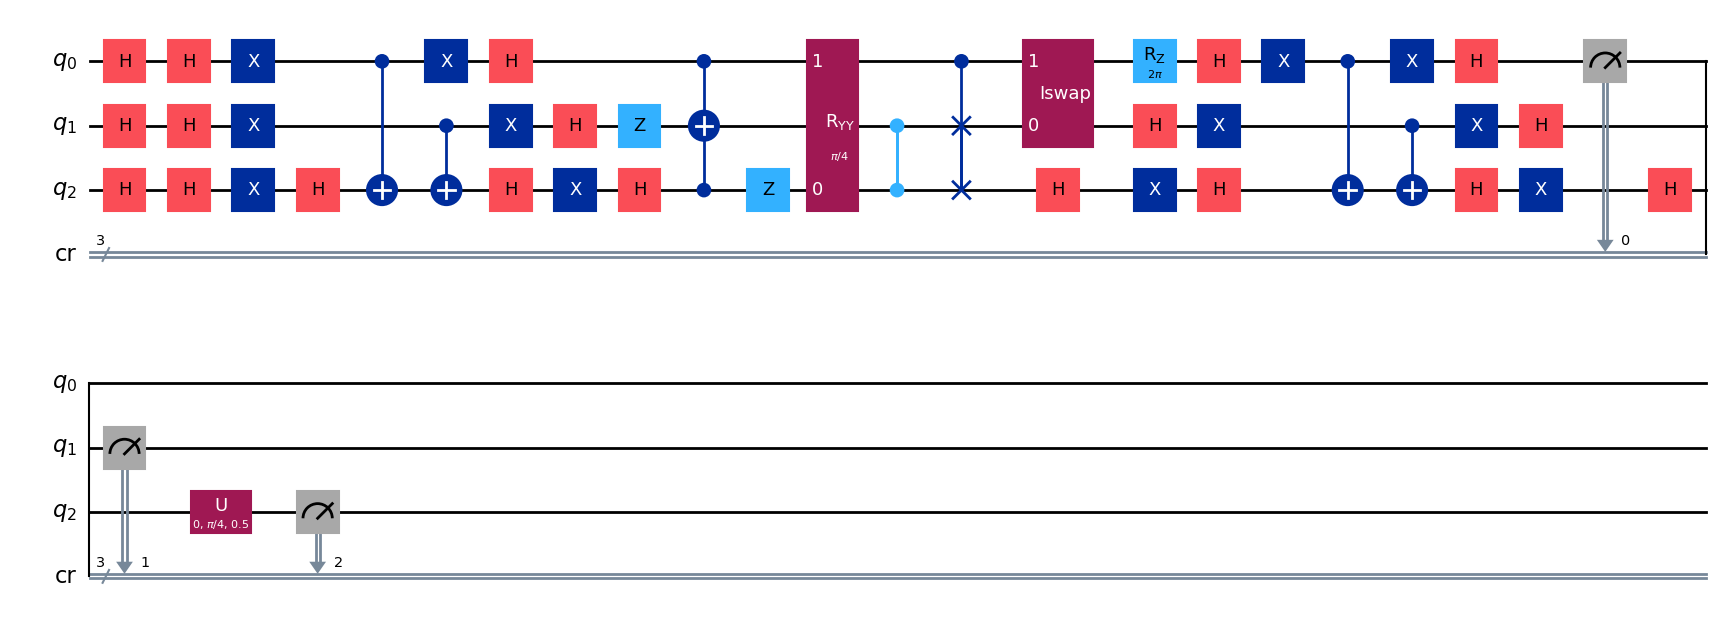

gen = 0 , Best fitness = (1.518515625,)
gen = 1 , Best fitness = (1.518515625,) , Number of invalids = 6

[Generation 32] Best Fitness: 1.5185


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


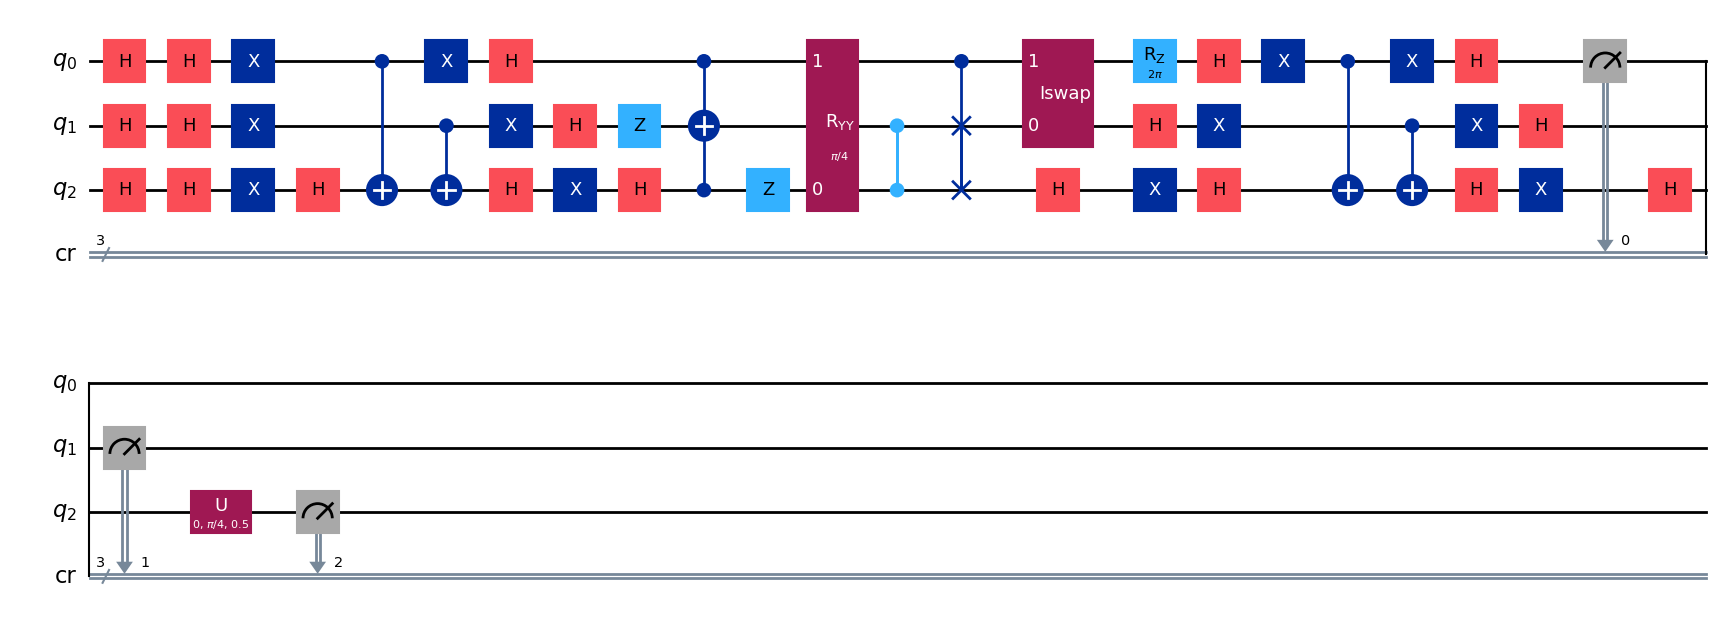

gen = 0 , Best fitness = (1.518515625,)
gen = 1 , Best fitness = (1.518515625,) , Number of invalids = 2

[Generation 33] Best Fitness: 1.5185


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


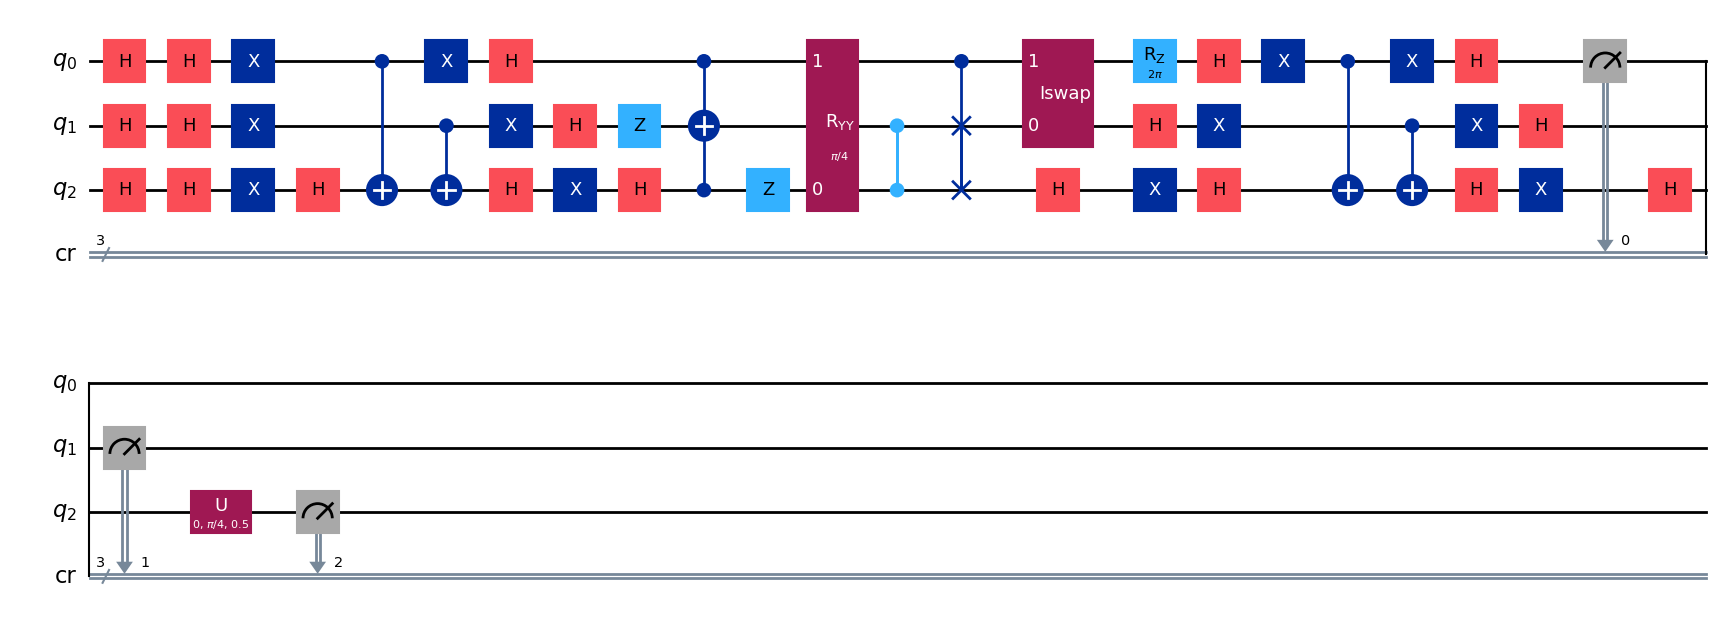

gen = 0 , Best fitness = (1.518515625,)
gen = 1 , Best fitness = (1.5136328125,) , Number of invalids = 2

[Generation 34] Best Fitness: 1.5136


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


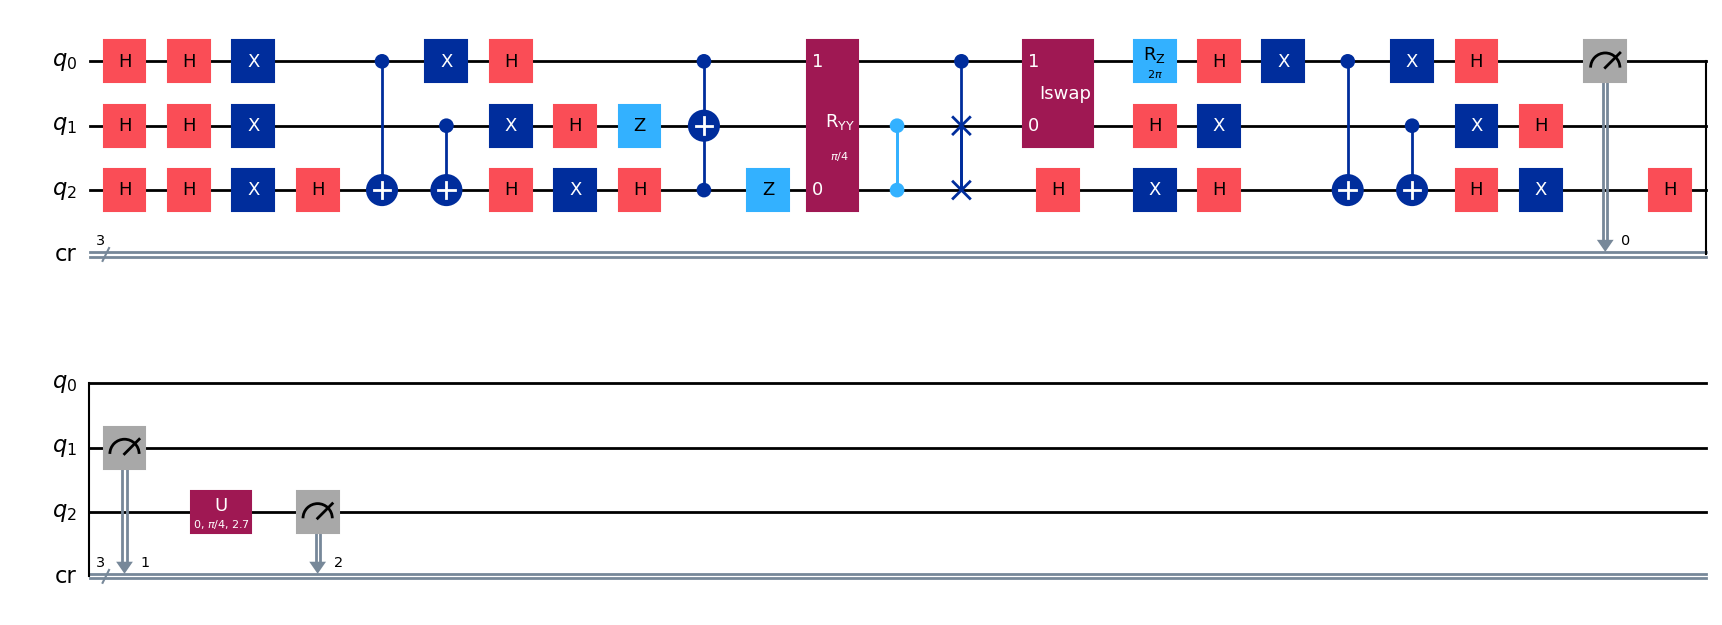

gen = 0 , Best fitness = (1.5136328125,)
gen = 1 , Best fitness = (1.5136328125,) , Number of invalids = 7

[Generation 35] Best Fitness: 1.5136


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


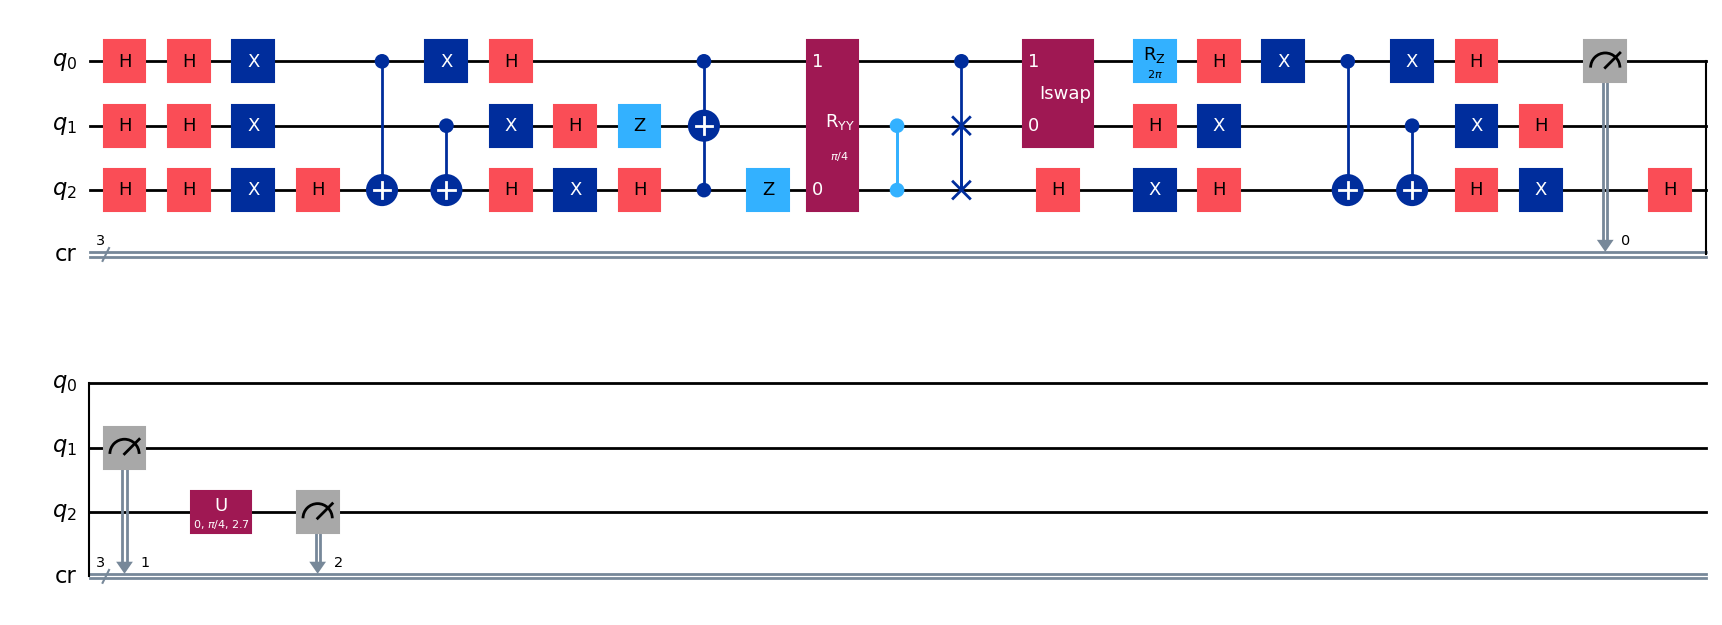

gen = 0 , Best fitness = (1.5136328125,)
gen = 1 , Best fitness = (1.5077734375,) , Number of invalids = 2

[Generation 36] Best Fitness: 1.5078


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


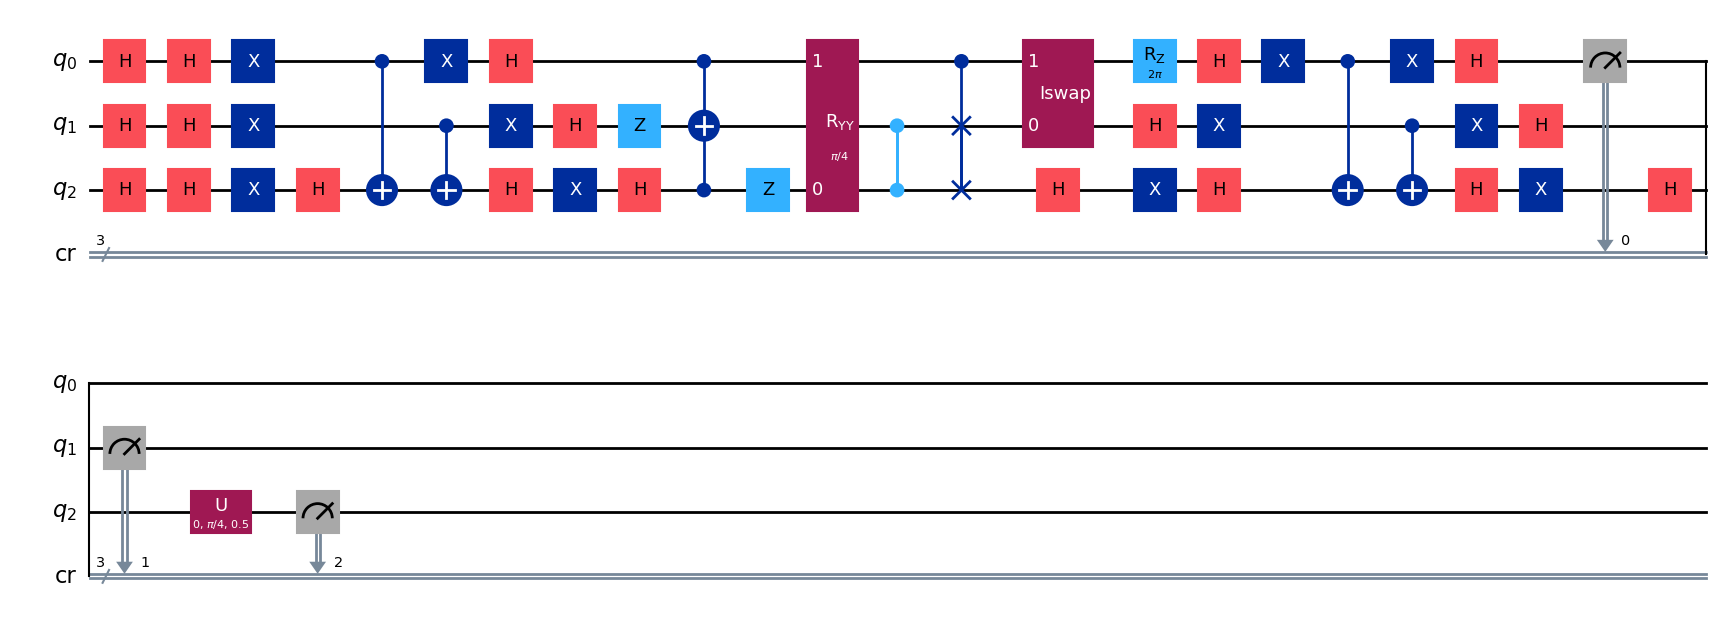

gen = 0 , Best fitness = (1.5077734375,)
gen = 1 , Best fitness = (1.305625,) , Number of invalids = 7

[Generation 37] Best Fitness: 1.3056


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


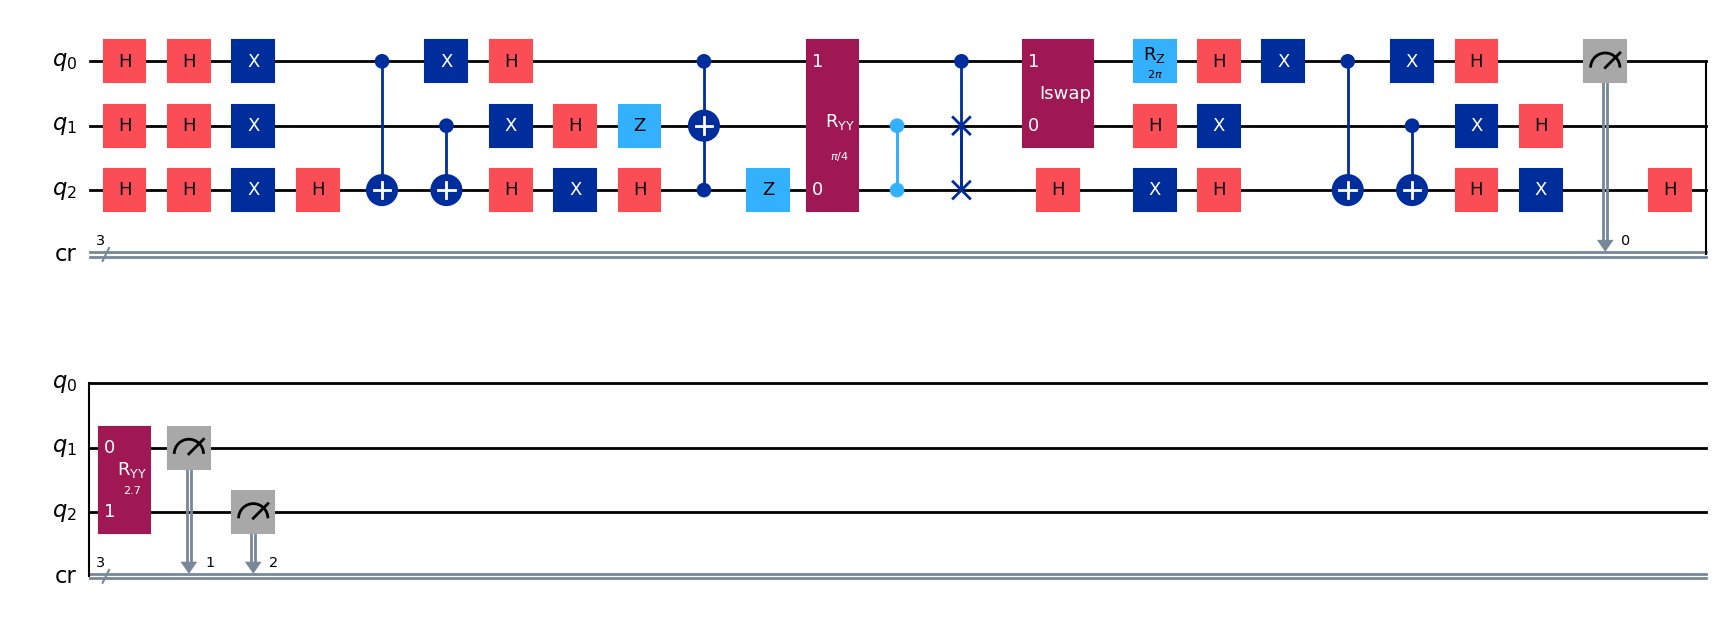

gen = 0 , Best fitness = (1.305625,)
gen = 1 , Best fitness = (1.305625,) , Number of invalids = 1

[Generation 38] Best Fitness: 1.3056


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


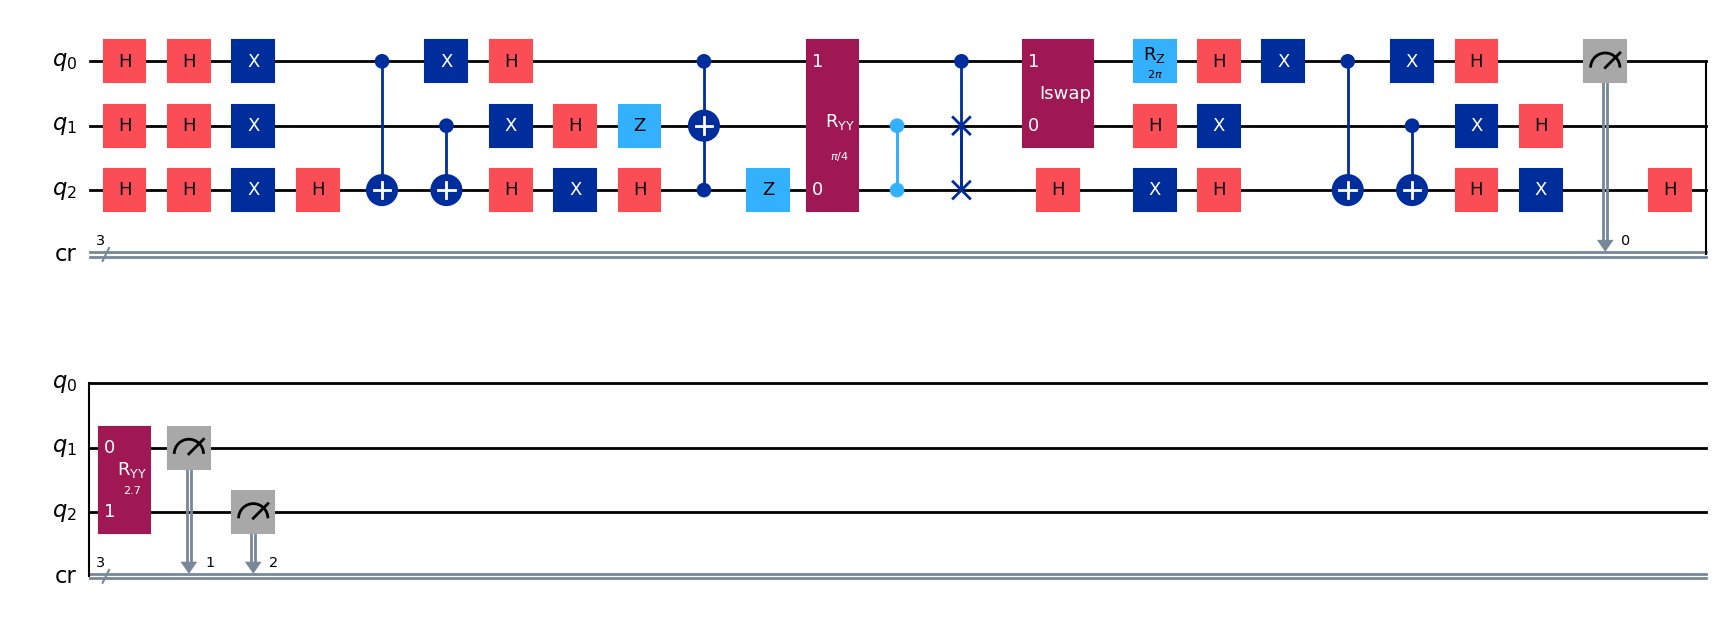

gen = 0 , Best fitness = (1.305625,)
gen = 1 , Best fitness = (1.305625,) , Number of invalids = 7

[Generation 39] Best Fitness: 1.3056


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


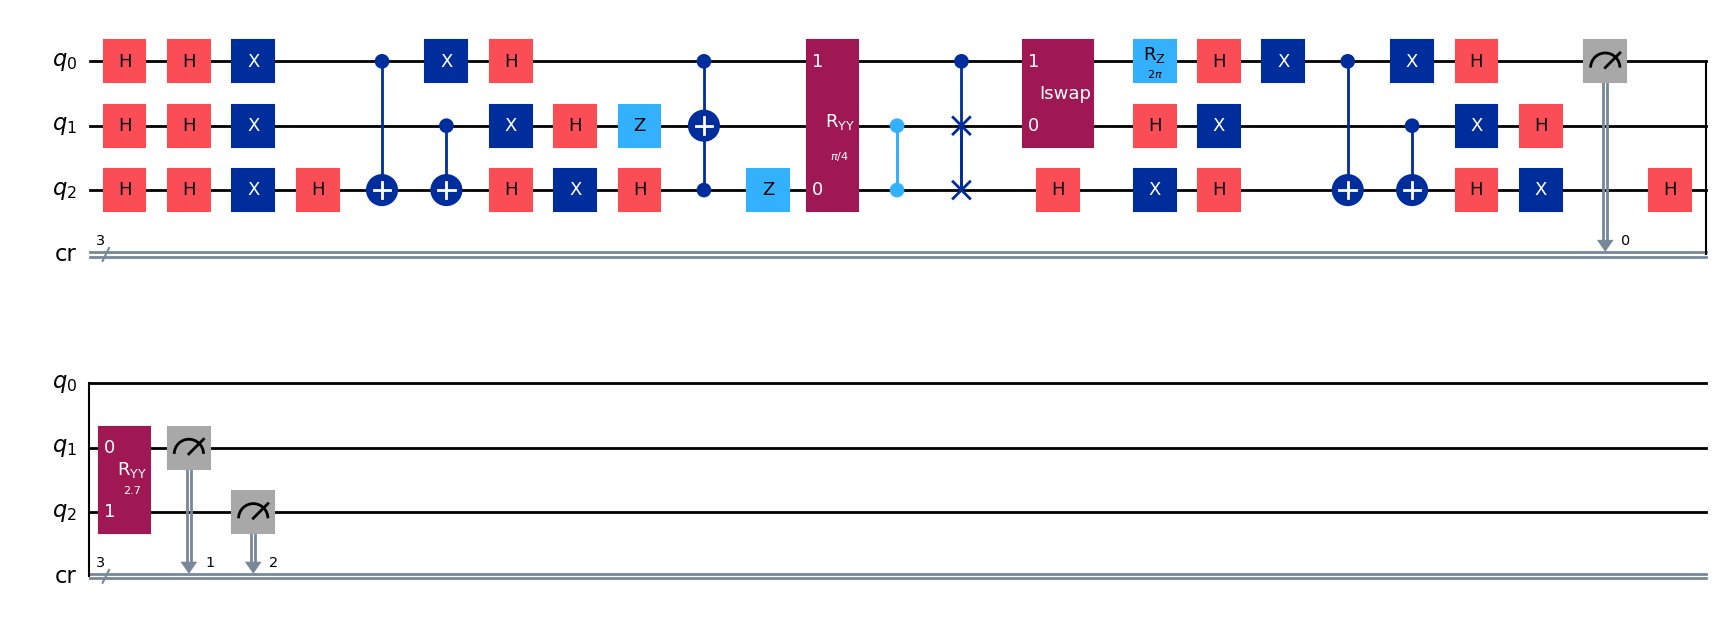

gen = 0 , Best fitness = (1.305625,)
gen = 1 , Best fitness = (0.9677734375,) , Number of invalids = 5

[Generation 40] Best Fitness: 0.9678


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


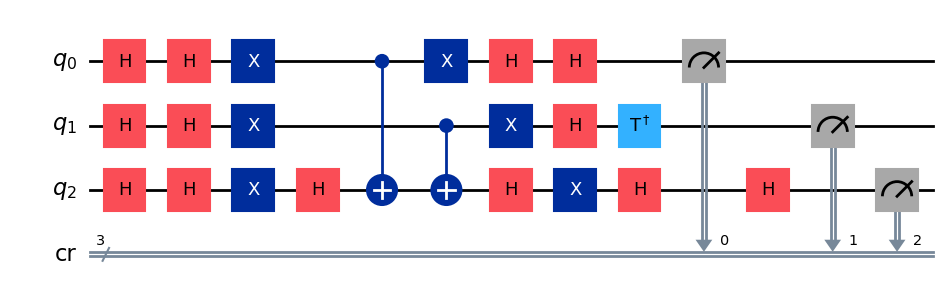

gen = 0 , Best fitness = (0.9677734375,)
gen = 1 , Best fitness = (0.9677734375,) , Number of invalids = 2

[Generation 41] Best Fitness: 0.9678


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


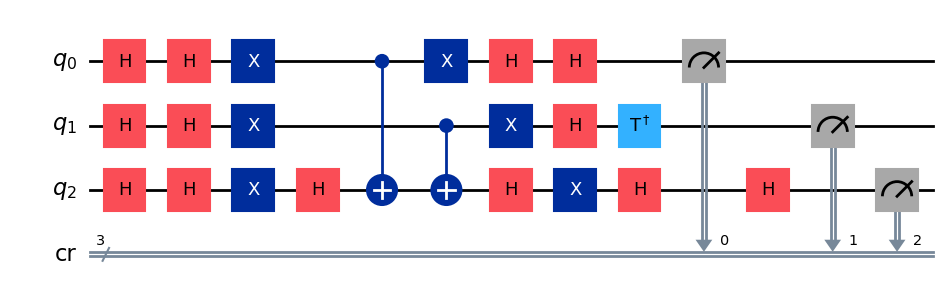

gen = 0 , Best fitness = (0.9677734375,)
gen = 1 , Best fitness = (0.9677734375,) , Number of invalids = 1

[Generation 42] Best Fitness: 0.9678


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


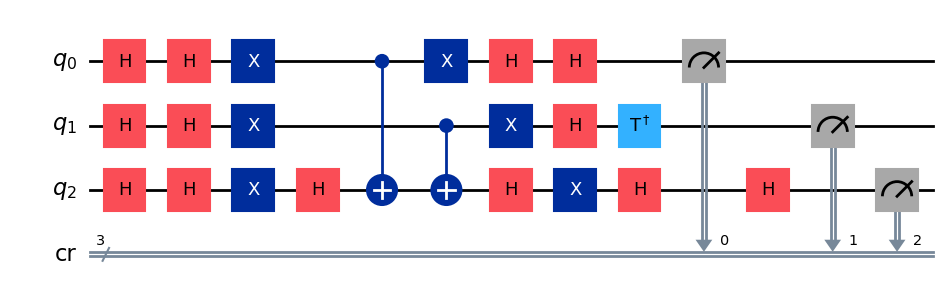

gen = 0 , Best fitness = (0.9677734375,)
gen = 1 , Best fitness = (0.9580078125,) , Number of invalids = 2

[Generation 43] Best Fitness: 0.9580


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


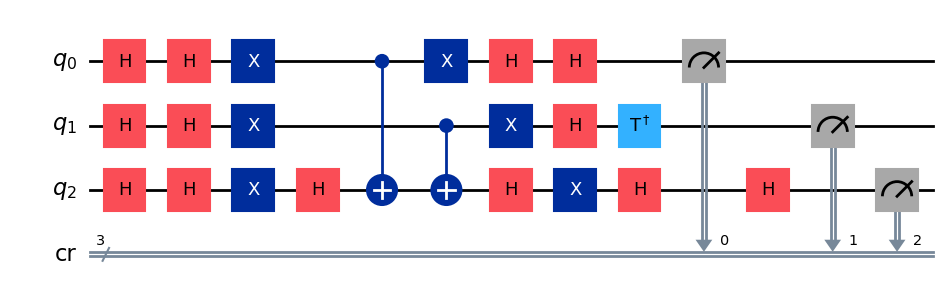

gen = 0 , Best fitness = (0.9580078125,)
gen = 1 , Best fitness = (0.9580078125,) , Number of invalids = 3

[Generation 44] Best Fitness: 0.9580


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


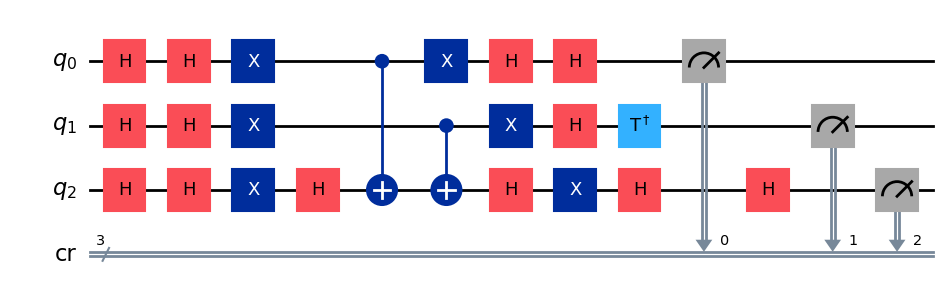

gen = 0 , Best fitness = (0.9580078125,)
gen = 1 , Best fitness = (0.54,) , Number of invalids = 2

[Generation 45] Best Fitness: 0.5400


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


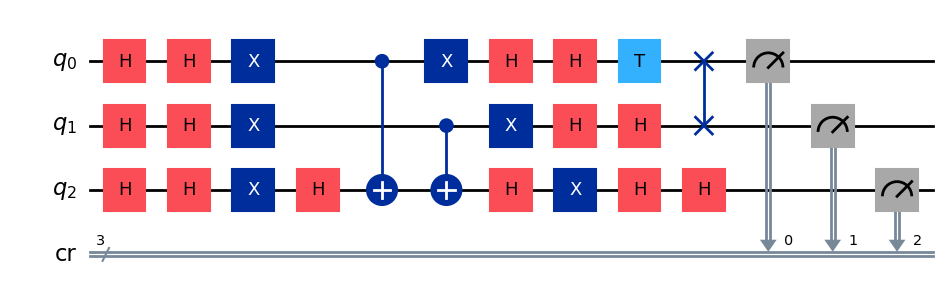

gen = 0 , Best fitness = (0.54,)
gen = 1 , Best fitness = (0.54,) , Number of invalids = 8

[Generation 46] Best Fitness: 0.5400


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


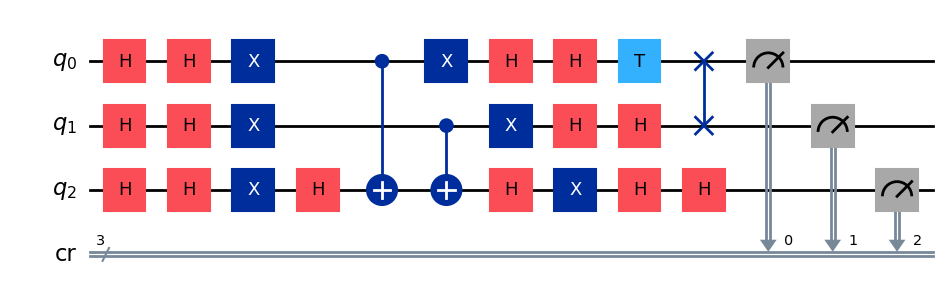

gen = 0 , Best fitness = (0.54,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 6

[Generation 47] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


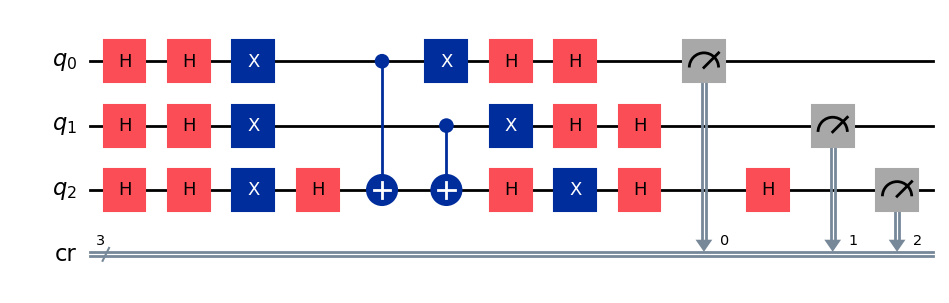

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 6

[Generation 48] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


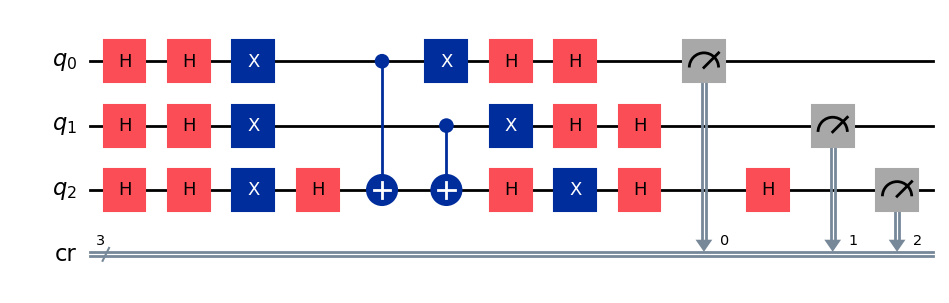

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 10

[Generation 49] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


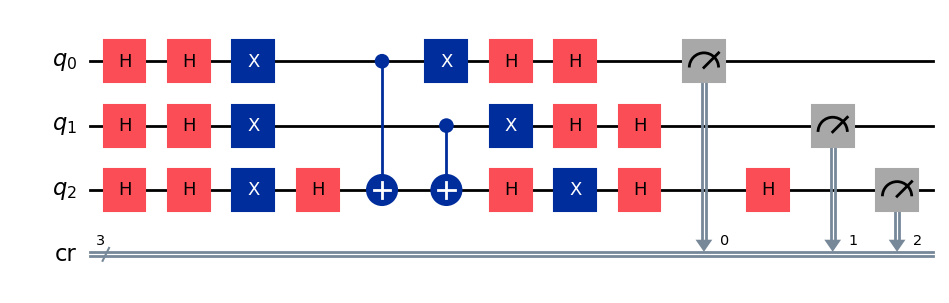

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 10

[Generation 50] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


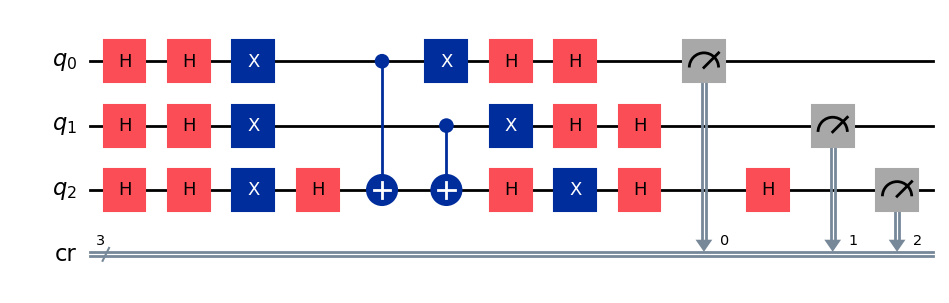

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 7

[Generation 51] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


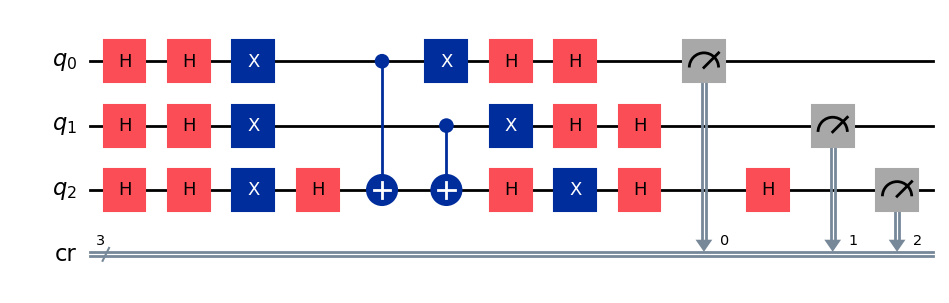

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 8

[Generation 52] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


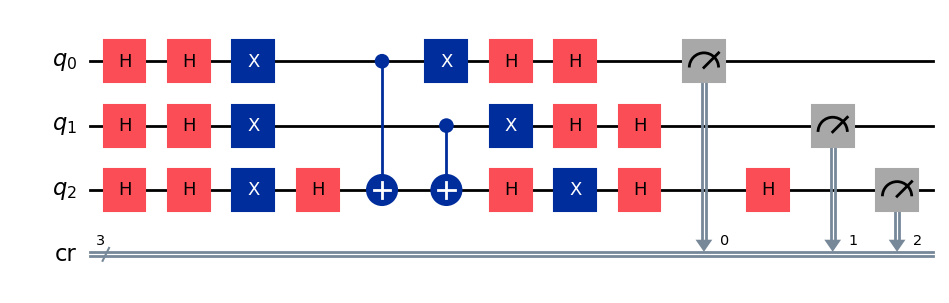

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 53] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


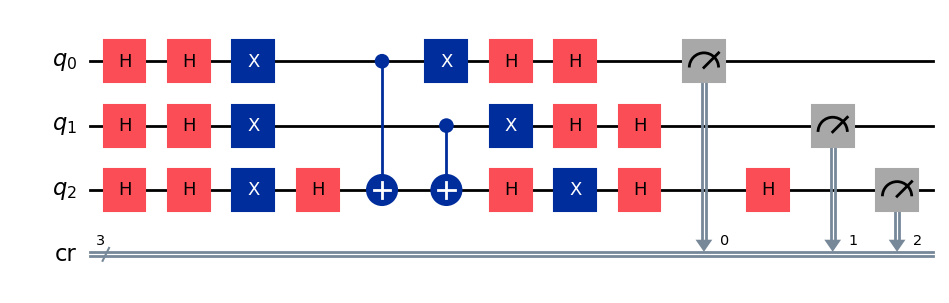

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 11

[Generation 54] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


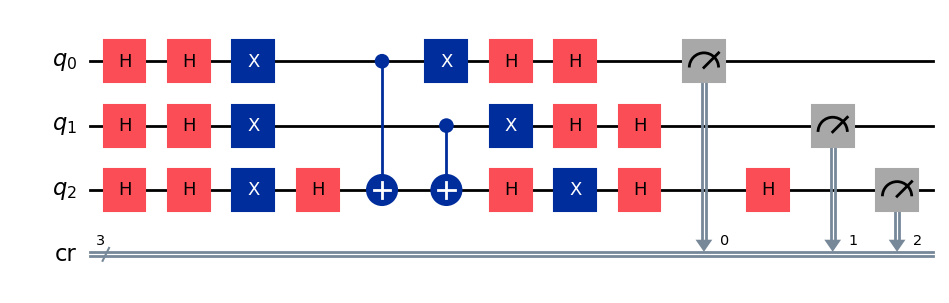

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 55] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


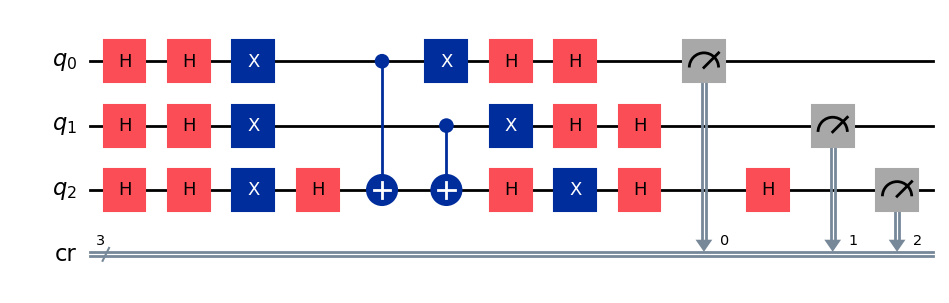

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 5

[Generation 56] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


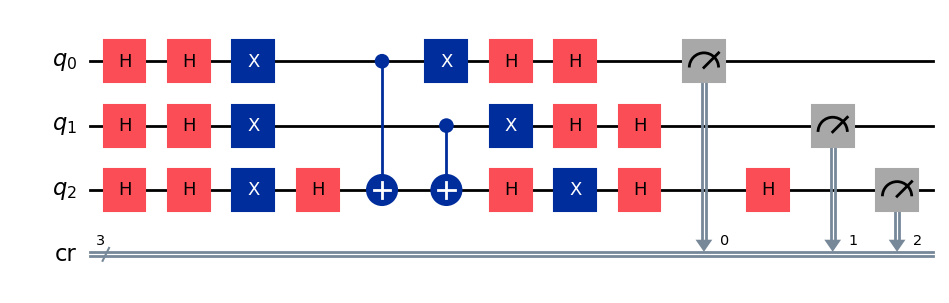

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 7

[Generation 57] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


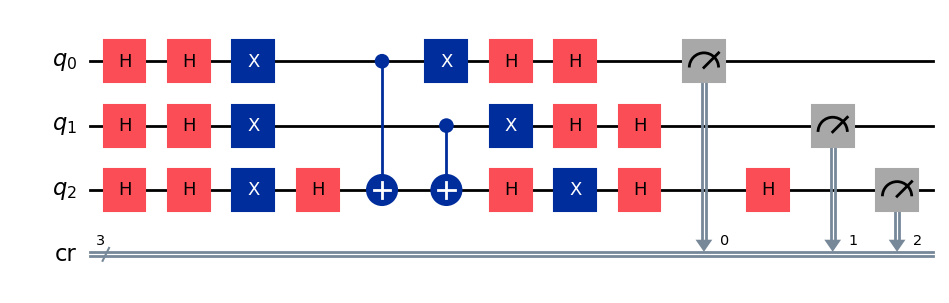

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 14

[Generation 58] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


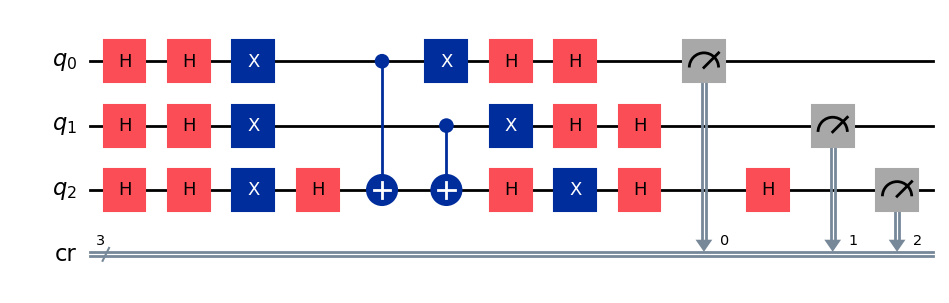

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 59] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


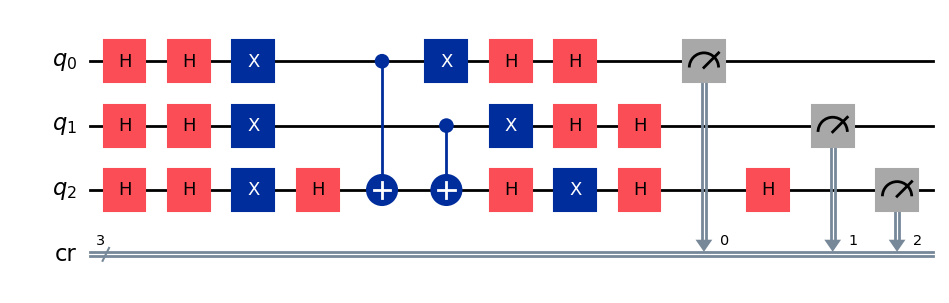

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 60] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


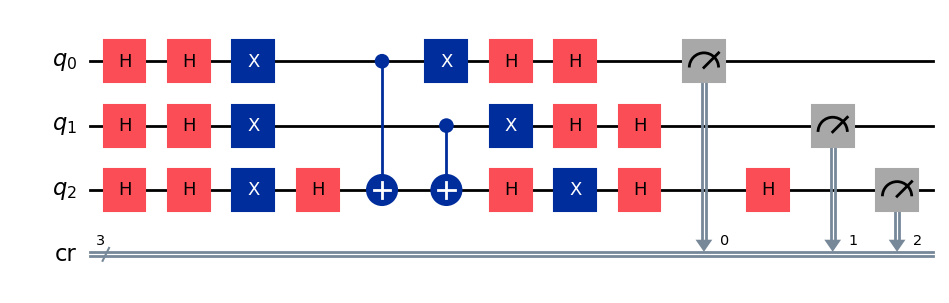

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 8

[Generation 61] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


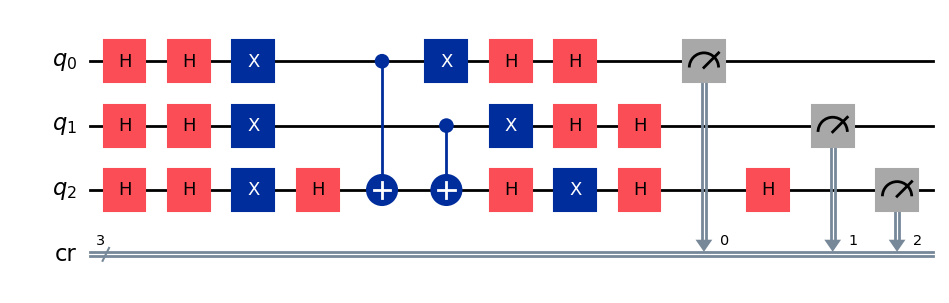

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 5

[Generation 62] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


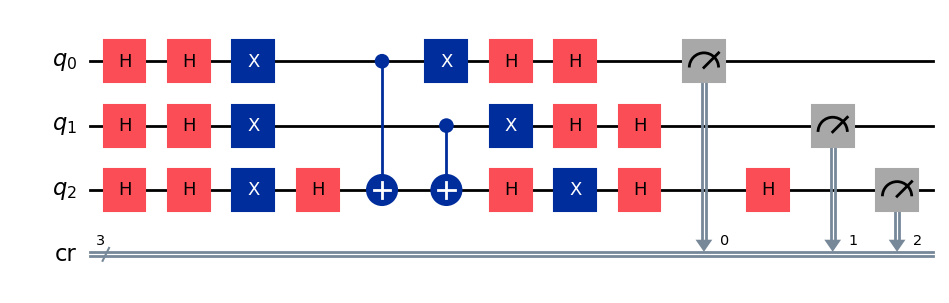

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 63] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


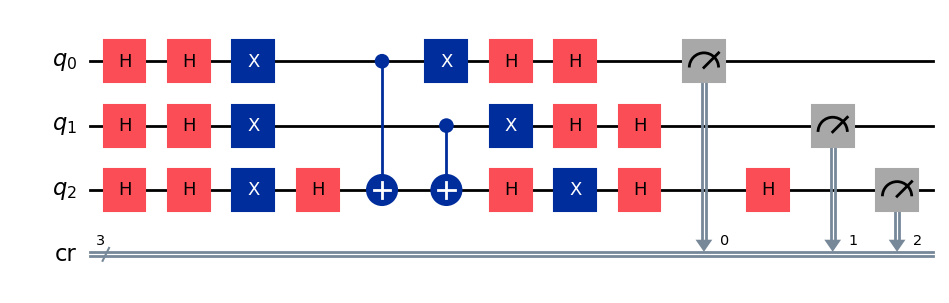

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 64] Best Fitness: 0.5000


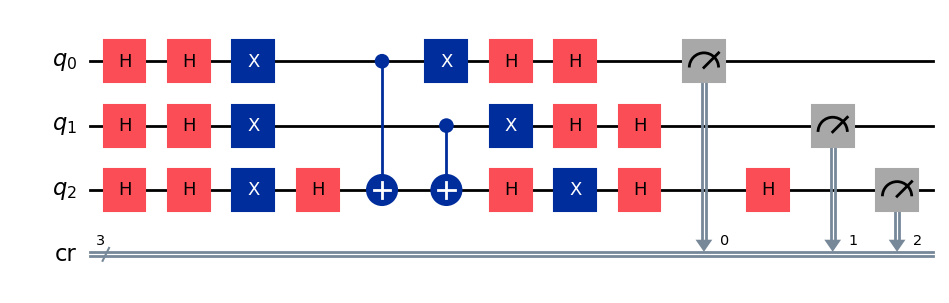

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 65] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


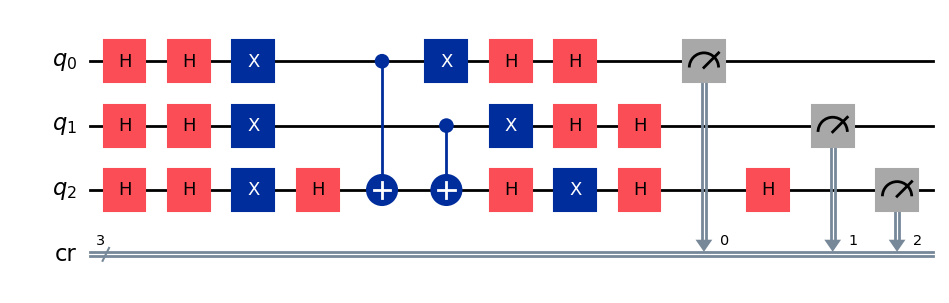

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 3

[Generation 66] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


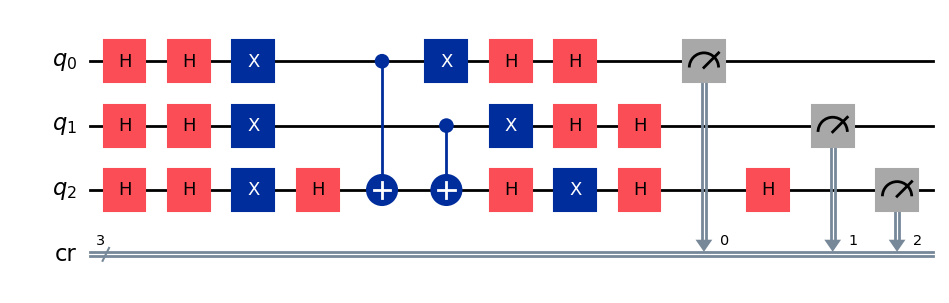

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 67] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


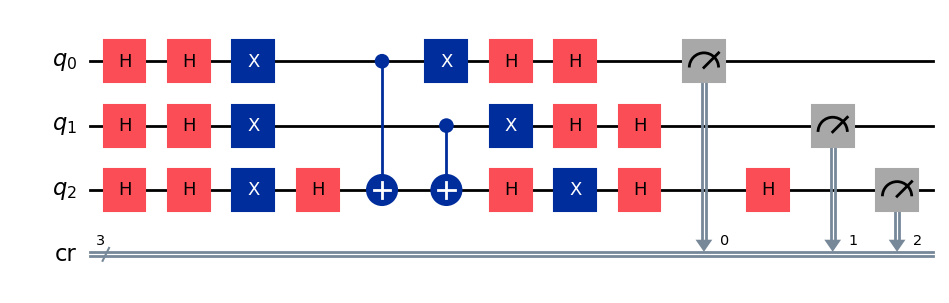

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 5

[Generation 68] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


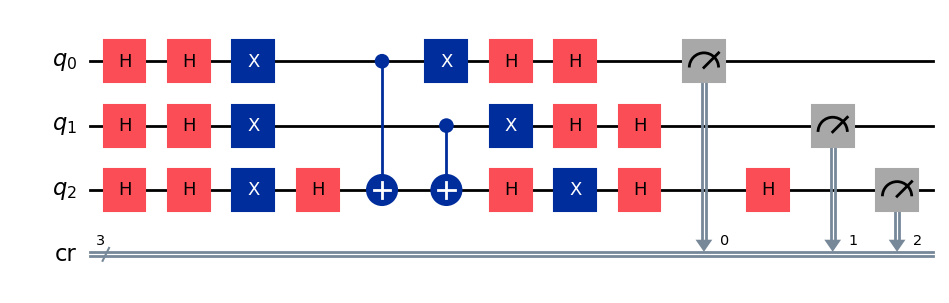

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 69] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


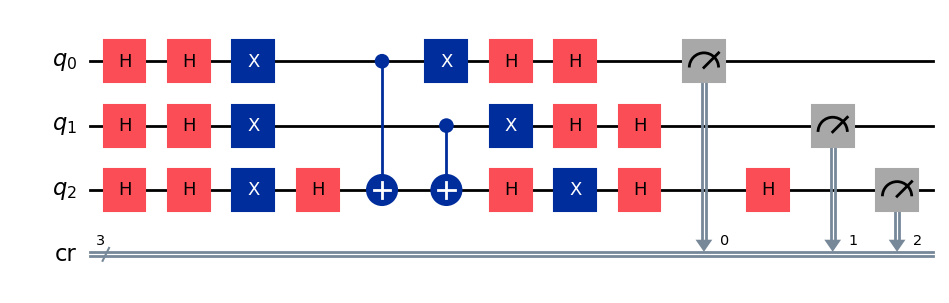

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 3

[Generation 70] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


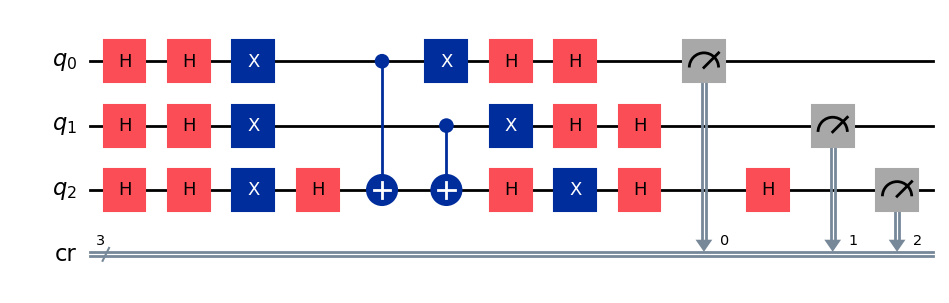

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 71] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


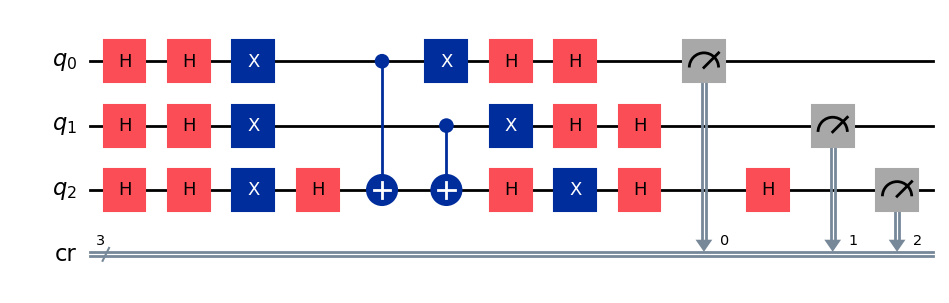

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 72] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


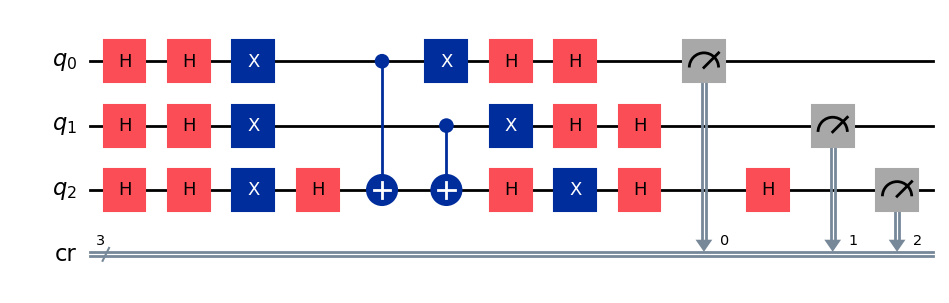

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 73] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


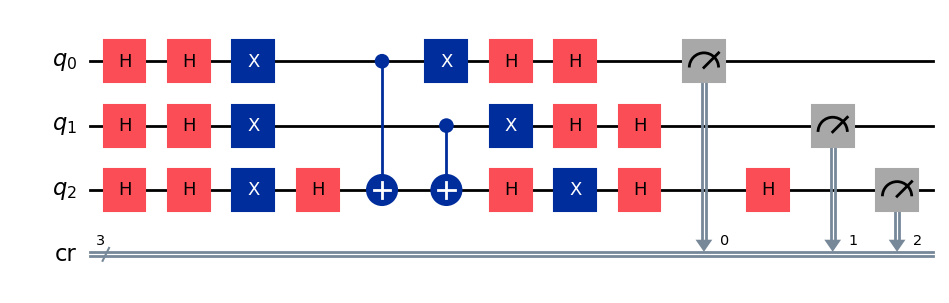

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 74] Best Fitness: 0.5000


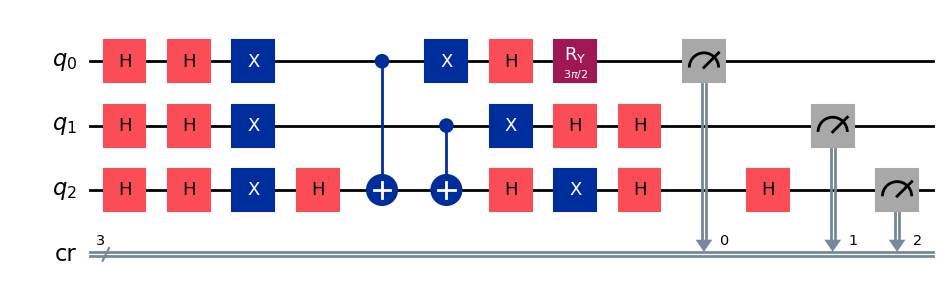

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 75] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


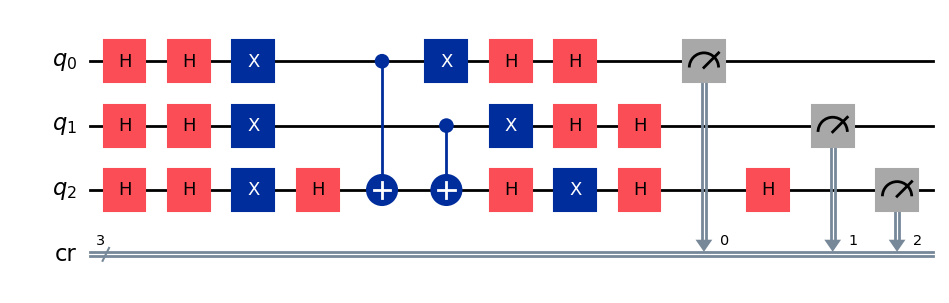

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 76] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


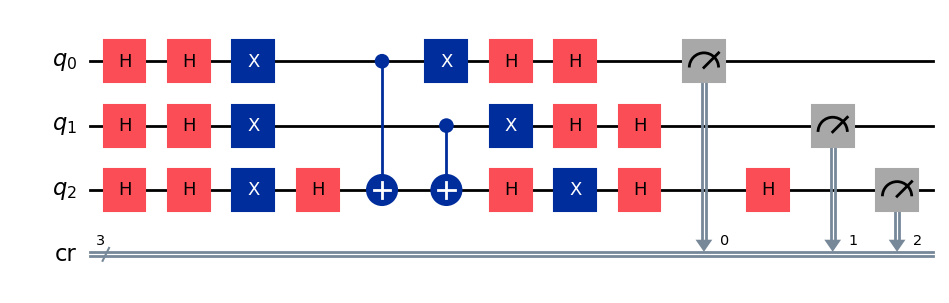

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 77] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


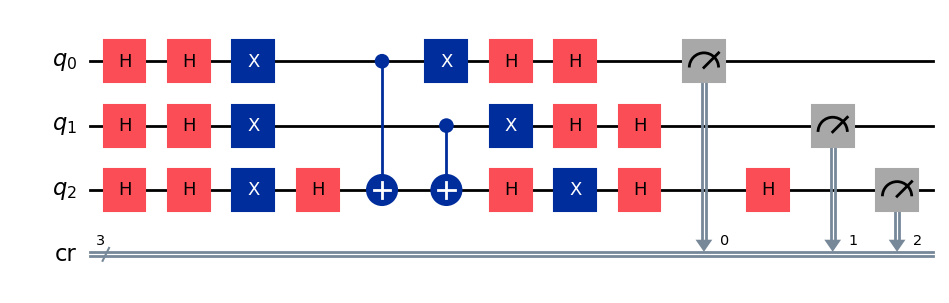

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 7

[Generation 78] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


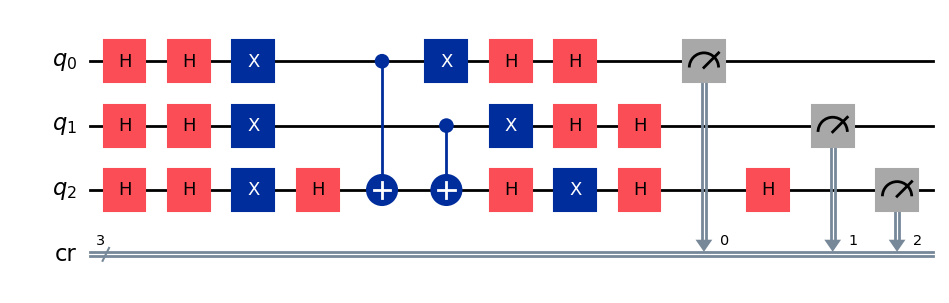

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 79] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


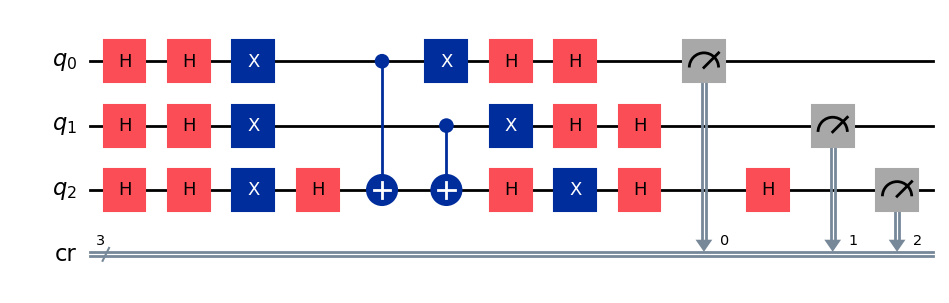

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 80] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


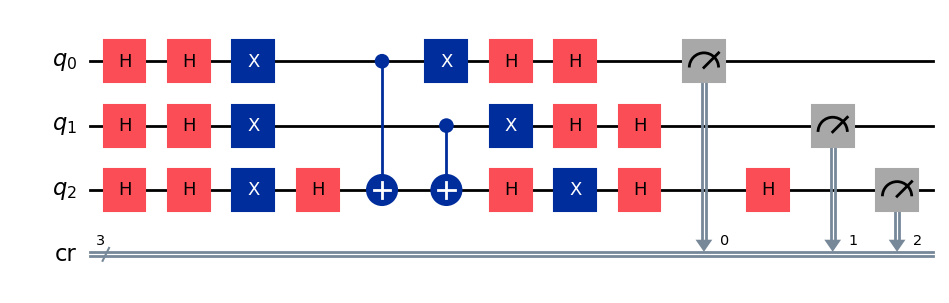

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 81] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


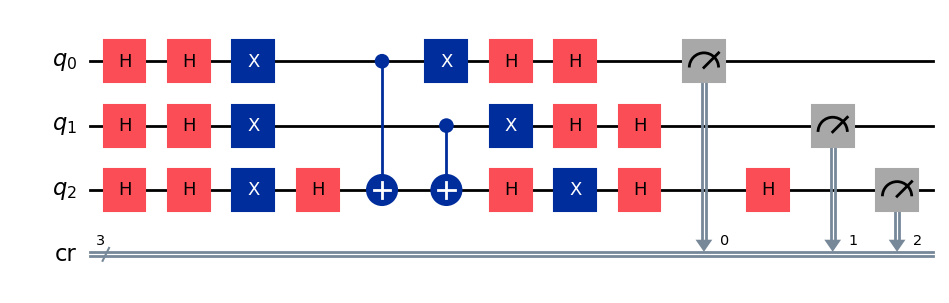

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 9

[Generation 82] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


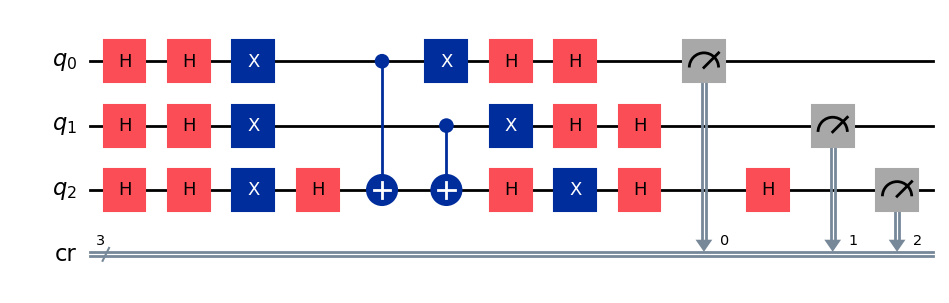

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 12

[Generation 83] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


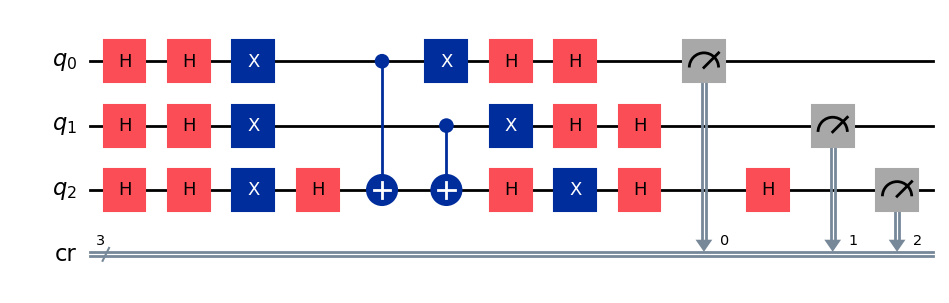

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 5

[Generation 84] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


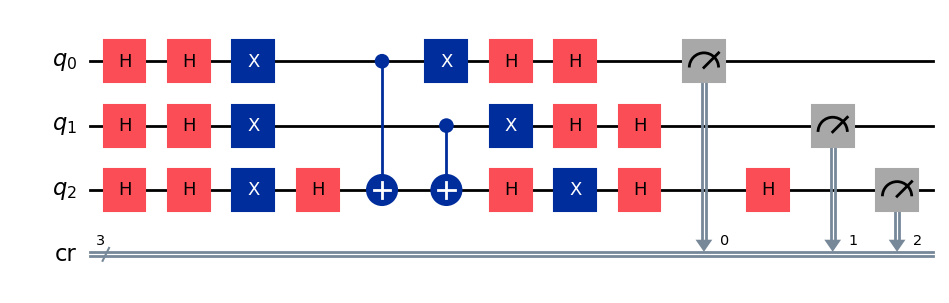

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 6

[Generation 85] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


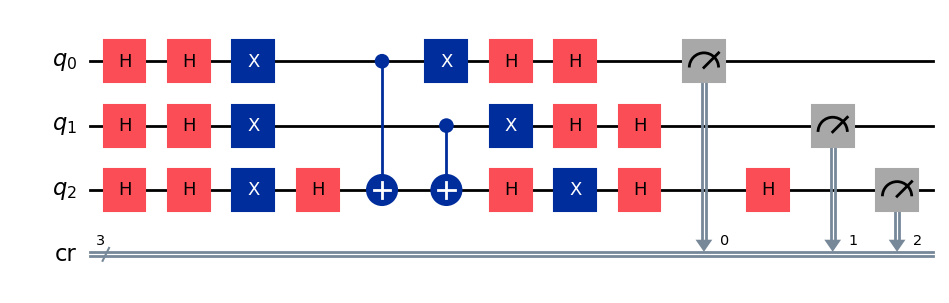

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 10

[Generation 86] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


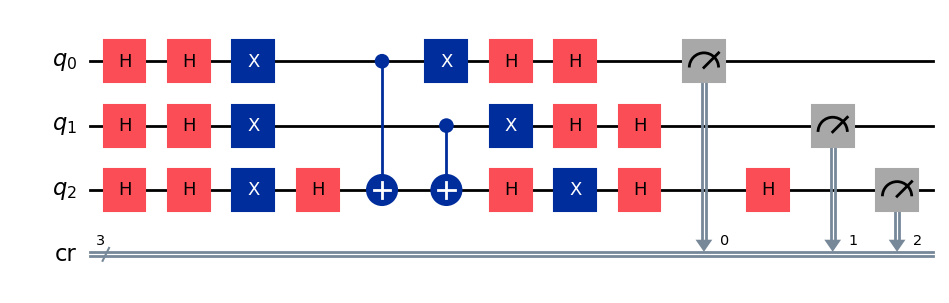

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 87] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


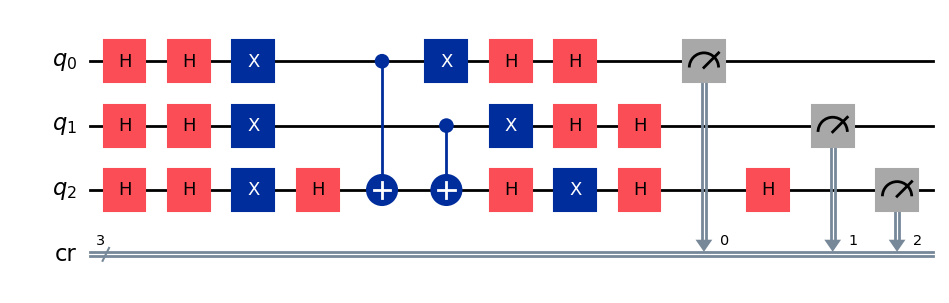

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 88] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


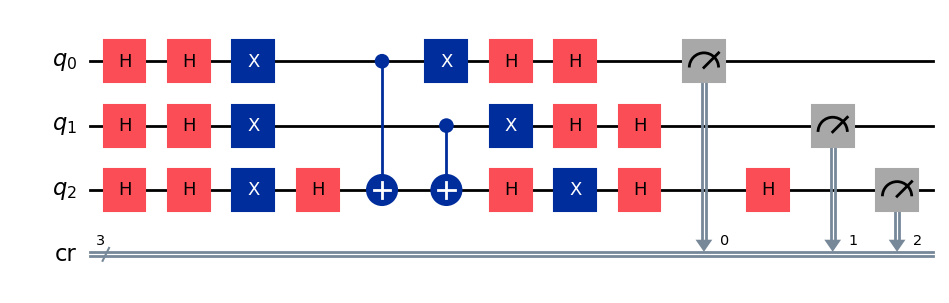

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 3

[Generation 89] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


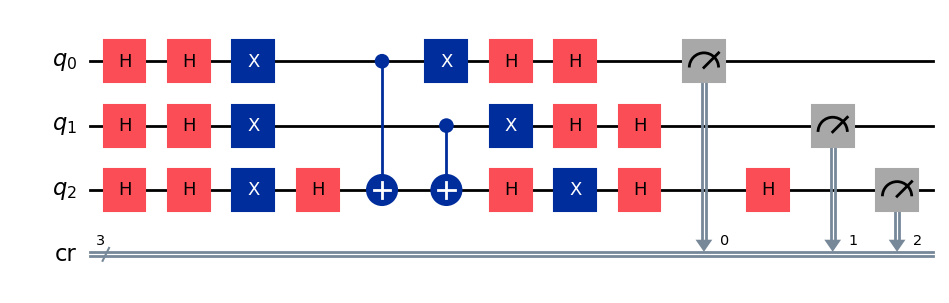

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 6

[Generation 90] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


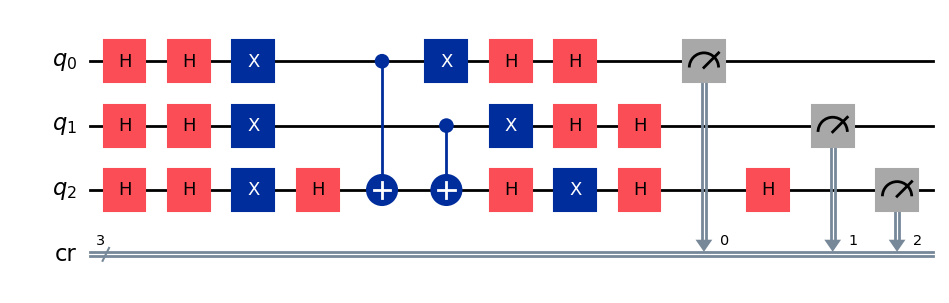

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 91] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


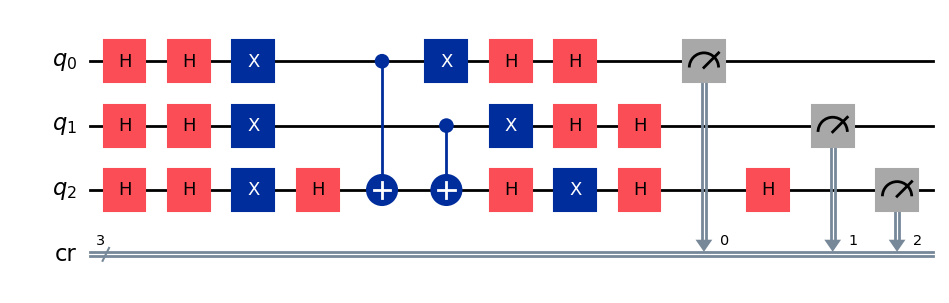

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 92] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


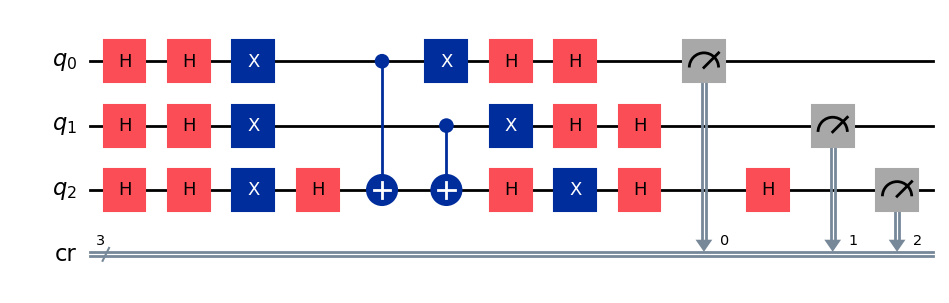

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 4

[Generation 93] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


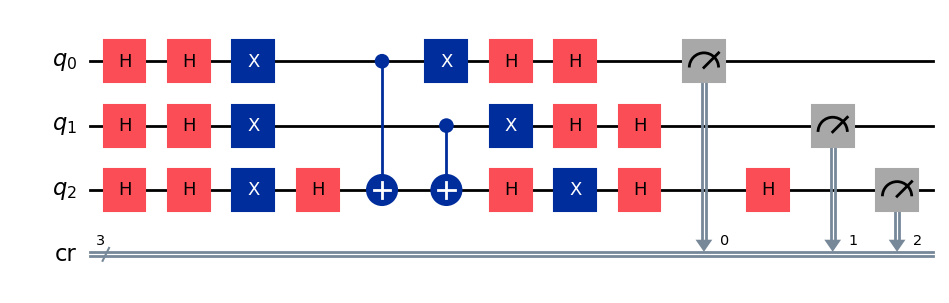

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 3

[Generation 94] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


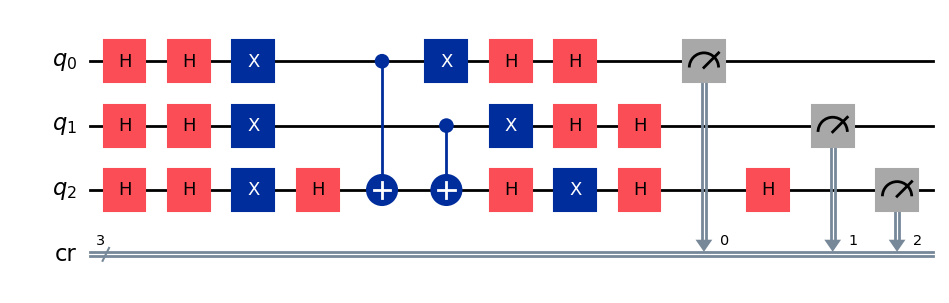

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 95] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


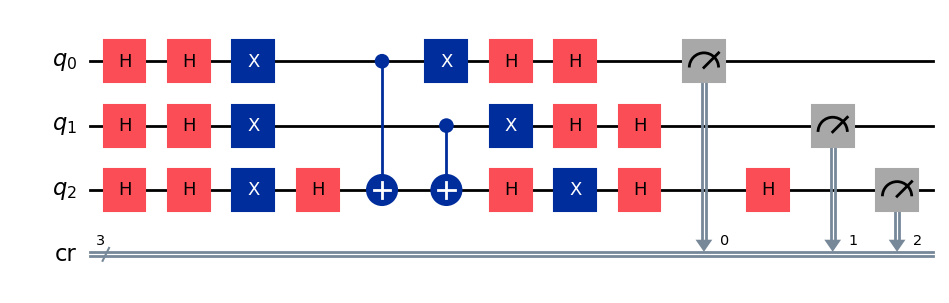

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 96] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


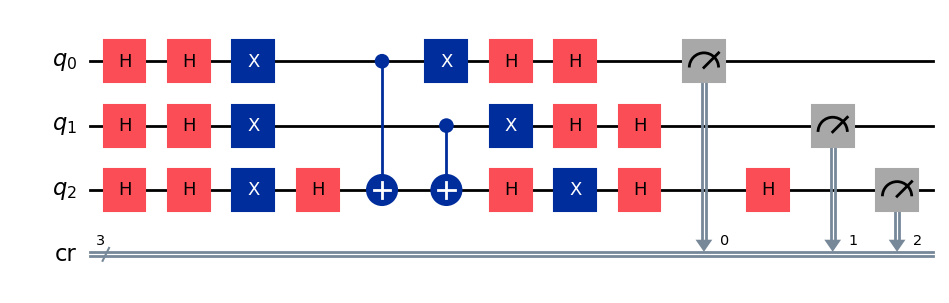

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 97] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


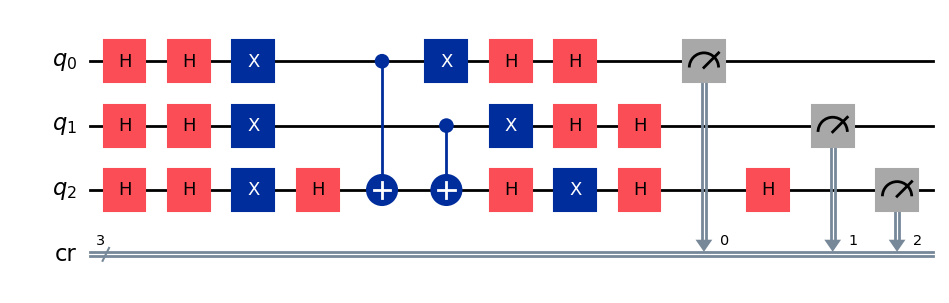

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 3

[Generation 98] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


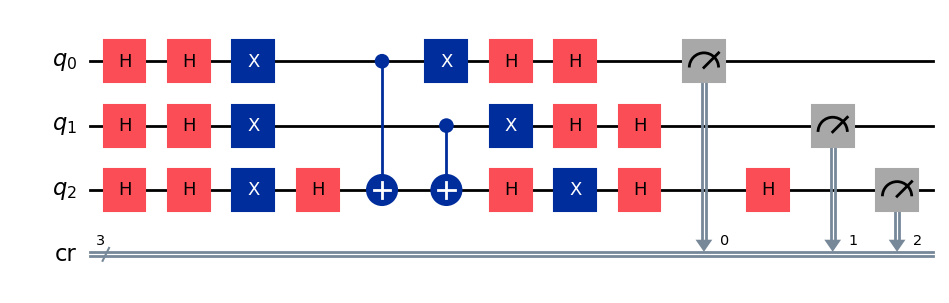

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 99] Best Fitness: 0.5000


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


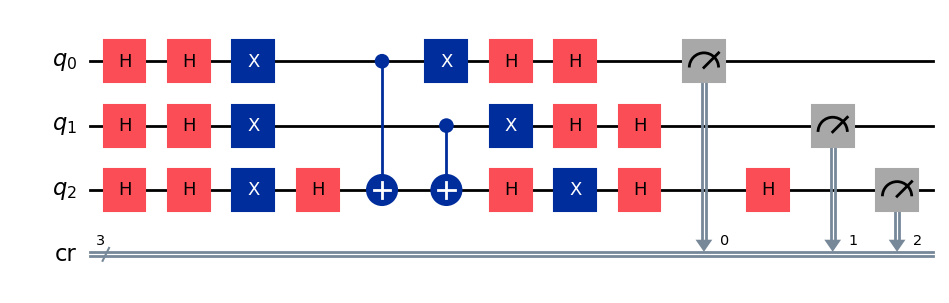

In [15]:
evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR)

population = toolbox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,
    max_init_depth=MAX_INIT_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

generations_list = []
best_fitness_list = []
avg_gate_count_list = []
invalid_list = []

for gen in range(MAX_GENERATIONS):
    population, logbook = algorithms.ge_eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=N_GEN,
        elite_size=ELITE_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        codon_size=CODON_SIZE,
        max_tree_depth=MAX_TREE_DEPTH,
        codon_consumption=CODON_CONSUMPTION,
        report_items=REPORT_ITEMS,
        genome_representation=GENOME_REPRESENTATION,
        stats=stats,
        halloffame=hof,
        verbose=False
    )

    best_ind = tools.selBest(population, 1)[0]
    best_ind.generation = gen

    best_phenotype = evaluator.decode_individual(best_ind)
    if best_phenotype is not None:
        fitness_val, logs = fitness_function_specialized_state_000(
            best_phenotype, 
            shots=NUM_SHOTS, 
            threshold=SUCCESS_THRESHOLD, 
            gate_penalty_weight=GATE_PENALTY_WEIGHT,
            target_state=TARGET_STATE, 
            log_states=True
        )
        best_fitness_list.append(fitness_val)
        if logs:
            avg_gate = np.mean([log["gate_count"] for log in logs])
        else:
            avg_gate = 0
        avg_gate_count_list.append(avg_gate)
        generations_list.append(gen)
        invalid_list.append(logbook.select('invalid')[0])

    qc = evaluator.execute_circuit(best_phenotype)
    if qc:
        print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f}")
        display(qc.draw("mpl"))
pool.close()
pool.join()


[HALL OF FAME]
Individual 1:
Genome: [236, 55, 195, 340, 111, 340, 167, 340, 111, 54, 214, 156, 57, 257, 57, 257, 153, 360, 19, 168, 187, 259, 324, 97, 186, 215, 315, 42, 132, 276, 188, 25, 394]
Phenotype: "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "## Begin Diffuser\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "qc.x(0)\n" "qc.x(1)\n" "qc.x(2)\n" "qc.h(2)\n" "qc.cx(0,2)\n" "qc.cx(1,2)\n" "qc.h(2)\n" "qc.x(0)\n" "qc.x(1)\n" "qc.x(2)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "qc.h(" "1" ")\n" "qc.h(" "0" ")\n" "qc.h(" "2" ")\n" "## End Diffuser\n" "qc.measure(0, 0)\n" "qc.measure(1, 1)\n" "qc.measure(2, 2)\n"
Fitness: 0.5
Marked State: 000
Oracle:
qc.x(0)
qc.x(1)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(1)
qc.x(2)

p(marked): 1.0000, error: 0.0000
Gate Count: 25


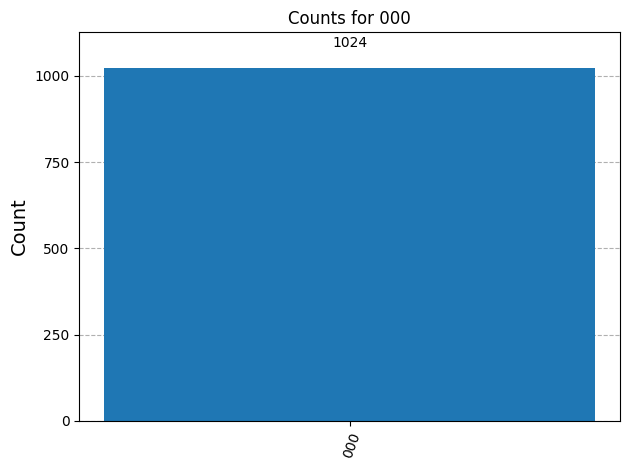

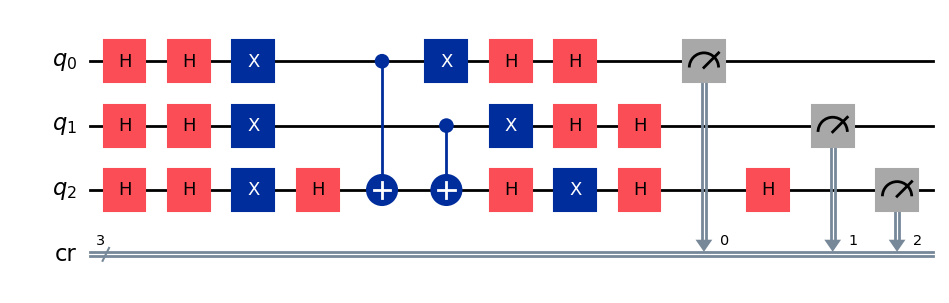


Best Individual's Fitness: 0.5


In [16]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)
fitness, log_per_state = fitness_function_specialized_state_000(best_phenotype, log_states=True)
# Explicitly write logs to disk.
evaluator.log_evaluation(log_per_state, 0, best_ind)

for log in log_per_state:
    print(f"Marked State: {log['state']}")
    print(f"Oracle:\n{log['oracle']}")
    print(f"p(marked): {log['p_marked']:.4f}, error: {log['error']:.4f}")
    print(f"Gate Count: {log['gate_count']}")
    display(plot_histogram(log["counts"], title=f"Counts for {log['state']}"))

best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw("mpl"))
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])


## Evolution Metrics Over Generations

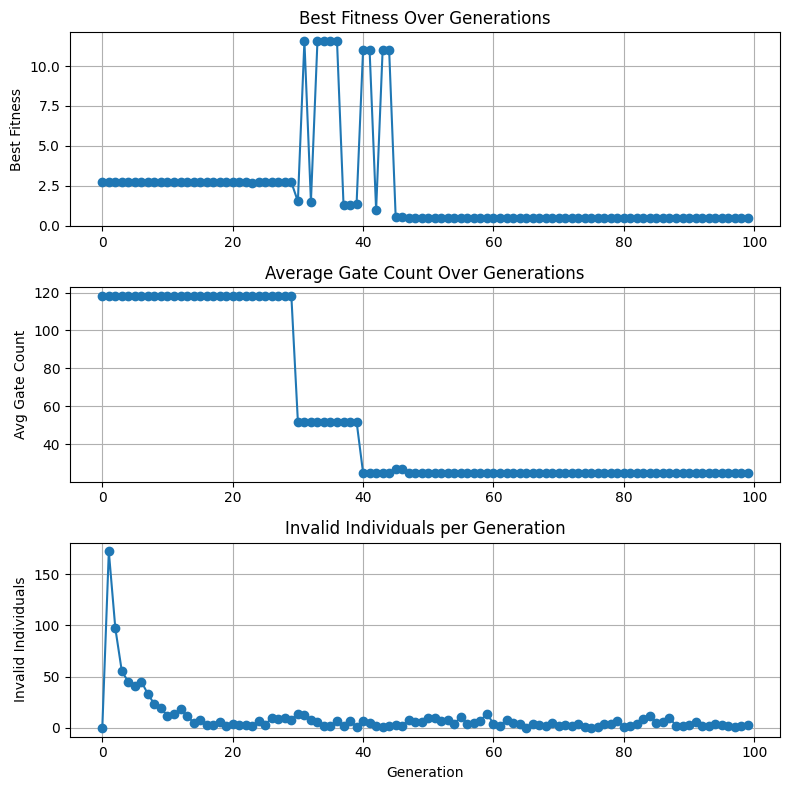

In [17]:
# Plot best fitness, average gate count, and invalid counts over generations
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# 1) Best Fitness
axs[0].plot(generations_list, best_fitness_list, marker='o', linestyle='-')
axs[0].set_ylabel('Best Fitness')
axs[0].set_title('Best Fitness Over Generations')
axs[0].grid(True)

# 2) Average Gate Count
axs[1].plot(generations_list, avg_gate_count_list, marker='o', linestyle='-')
axs[1].set_ylabel('Avg Gate Count')
axs[1].set_title('Average Gate Count Over Generations')
axs[1].grid(True)

# 3) Invalid Individuals
axs[2].plot(generations_list, invalid_list, marker='o', linestyle='-')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Invalid Individuals')
axs[2].set_title('Invalid Individuals per Generation')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Send circuit Job to IBM

In [ ]:
def run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE):
    """
    Run Hall of Fame individual on IBM hardware.
    """
    # Init IBM Runtime
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.least_busy(operational=True, simulator=False)
    print(f"[QPU] Running on: {backend.name}")

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = evaluator.shots

    # Loop over HOF individuals
    for i, ind in enumerate(hof.items):
        print(f"\n[HOF Individual {i+1}] Fitness: {ind.fitness.values[0]}")

        # Decode + Execute
        pheno_code = evaluator.decode_individual(ind)
        
        # Inject register definitions so that the circuit includes a classical register 'cr'
        pheno_code = re.sub(
            r"qc\s*=\s*QuantumCircuit\(\s*3\s*,\s*3\s*\)",
            "qr = QuantumRegister(3, name='q')\ncr = ClassicalRegister(3, name='cr')\nqc = QuantumCircuit(qr, cr)",
            pheno_code
        )
        
        qc = evaluator.execute_circuit(pheno_code)
        if qc is None:
            print(" Invalid circuit. Skipping.")
            continue

        # Transpile the circuit for the target backend
        pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
        circuit_isa = pm.run(qc)

        ops_evolved = circuit_isa.count_ops()
        print("Evolved transpiled count_ops:", ops_evolved)
        
        depth = circuit_isa.depth()
        print("Evolved transpiled depth:", depth)
        
        display(circuit_isa.draw(output="mpl", idle_wires=False))
        # Run on hardware
        result = sampler.run([circuit_isa]).result()

        # Extract counts from the classical register 'cr'
        try:
            counts = result[0].data.cr.get_counts()
        except AttributeError as e:
            print("Error accessing counts:", e)
            continue

        # Plot results
        display(plot_histogram(counts, title=f"HOF #{i+1} on {backend.name}"))

[QPU] Running on: ibm_brisbane

[HOF Individual 1] Fitness: 0.5
Evolved transpiled count_ops: OrderedDict([('rz', 9), ('sx', 4), ('measure', 3), ('ecr', 2), ('x', 2)])


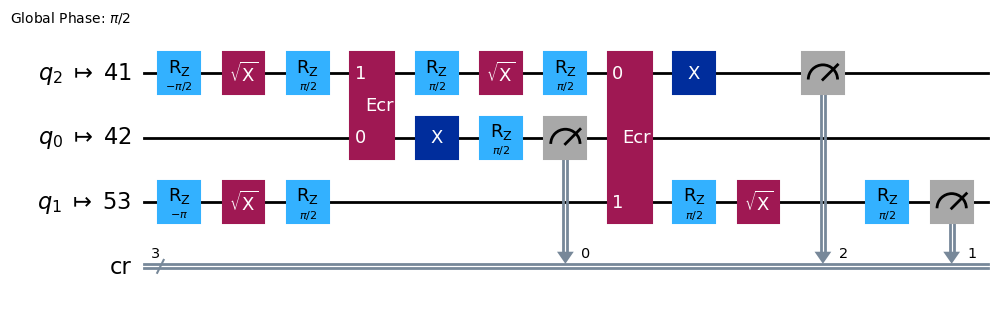

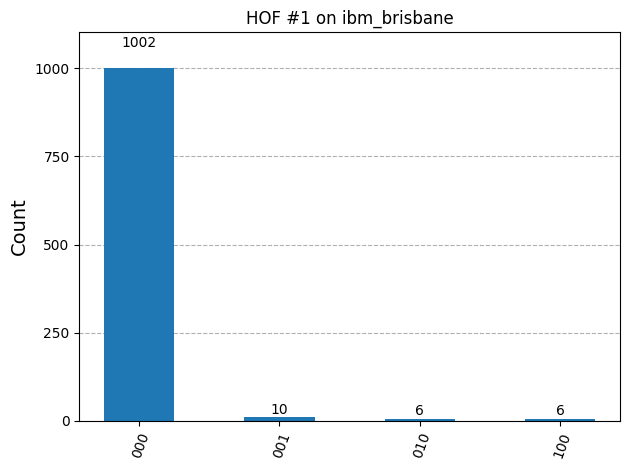

In [19]:
# GE is done, run HOF on real QPU
run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE)

In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import re


def analyze_phenotype_circuit(phenotype_str, backend_name="ibm_brisbane"):
    """
    Transpile and analyze an evolved phenotype circuit.
    Prints and returns gate counts and depth after hardware mapping.
    """
    # Insert named registers if needed
    modified_code = re.sub(
        r"qc\s*=\s*QuantumCircuit\(\s*3\s*,\s*3\s*\)",
        "qr = QuantumRegister(3, name='q')\ncr = ClassicalRegister(3, name='cr')\nqc = QuantumCircuit(qr, cr)",
        phenotype_str
    )

    # Execute to obtain circuit
    local_vars = {}
    try:
        exec(modified_code, globals(), local_vars)
        qc = local_vars.get("qc", None)
        if qc is None:
            print("[Error] Circuit 'qc' not found in phenotype.")
            return None
    except Exception as e:
        print(f"[Execution Error] {e}")
        return None

    # Load backend and transpile
    try:
        service = QiskitRuntimeService(channel="ibm_quantum")
        backend = service.backend(name=backend_name)
        pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
        transpiled = pm.run(qc)
    except Exception as e:
        print(f"[Backend Error] {e}")
        return None

    # Analyze
    ops = transpiled.count_ops()
    depth = transpiled.depth()

    print("\n Evolved Transpiled Circuit Analysis:")
    print("Gate counts:", ops)
    print("Circuit depth:", depth)
    
    return {"gate_counts": ops, "depth": depth, "circuit": transpiled}


 Evolved Transpiled Circuit Analysis:
Gate counts: OrderedDict([('rz', 8), ('sx', 4), ('measure', 3), ('x', 2), ('ecr', 2)])
Circuit depth: 12


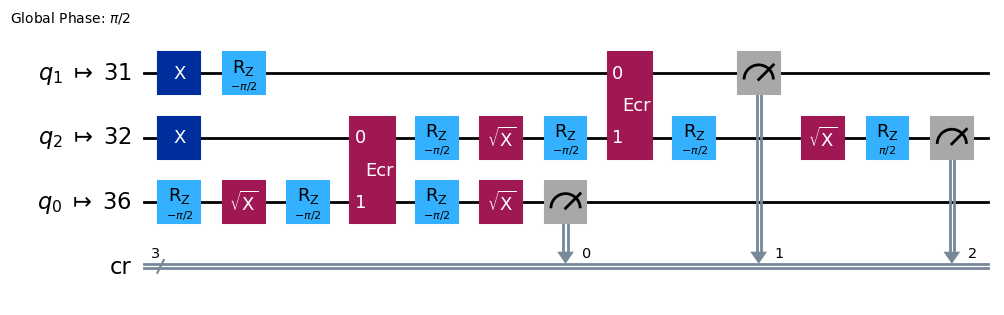

In [13]:
phenotype_code = """
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.h(1)
qc.h(2)
## Begin Diffuser
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(0)
qc.x(1)
qc.x(2)
qc.h(2)
qc.cx(0,2)
qc.cx(1,2)
qc.h(2)
qc.x(0)
qc.x(1)
qc.x(2)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(1)
qc.h(0)
qc.h(2)
## End Diffuser
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
"""

result = analyze_phenotype_circuit(phenotype_code)

if result:
    display(result["circuit"].draw("mpl", idle_wires=False))